# Team Based Model

## Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from tqdm import tqdm
from nba_api.stats.static import players, teams

import sys

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from src.data.make_team_dataset import load_team_data


from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import LinearSVR
import xgboost as xgb
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor
import lightgbm as lgb
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.multioutput import MultiOutputRegressor

from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import confusion_matrix
import pickle


In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-

In [2]:
pd.options.display.max_columns=230
pd.options.display.max_rows=100

## Gather Team Level Basic, Advanced, and Scoring Data

In [3]:
team_data = load_team_data()

In [4]:
from src.data.make_team_dataset import clean_team_data

clean_team_df = clean_team_data(team_data)

In [5]:
clean_team_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,HOME_GAME
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,0,240,34,74,0.459,2,9,0.222,28,40,0.700,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,0.529,1.00,14.1,0.289,0.667,0.478,18.256,18.9,0.473,0.535,1.0,0.197,98.32,95.5,79.58,95.0,0.446,0.878,0.122,0.653,0.163,0.061,0.102,0.286,0.204,0.490,0.563,0.438,0.000,1.000,0.529,0.471,1
1,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,20000008,2000-10-31,MIN @ HOU,1,240,43,88,0.489,6,11,0.545,14,16,0.875,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,0.674,1.81,20.7,0.333,0.711,0.522,16.320,16.7,0.523,0.558,1.0,0.195,98.32,95.5,79.58,96.0,0.554,0.875,0.125,0.698,0.396,0.170,0.085,0.132,0.208,0.302,0.622,0.378,1.000,0.000,0.674,0.326,0
2,2000-01,22000,1610612751,BKN,New Jersey Nets,20000002,2000-10-31,BKN vs. CLE,0,240,31,85,0.365,3,10,0.300,17,26,0.654,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,0.774,1.60,17.7,0.276,0.698,0.477,15.084,15.3,0.382,0.425,1.0,0.196,99.76,98.0,81.67,98.0,0.488,0.882,0.118,0.683,0.171,0.110,0.110,0.207,0.256,0.512,0.750,0.250,1.000,0.000,0.774,0.226,1
3,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,20000002,2000-10-31,CLE @ BKN,1,240,32,78,0.410,2,7,0.286,20,32,0.625,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,0.500,0.84,12.6,0.302,0.724,0.523,18.985,19.4,0.423,0.467,1.0,0.202,99.76,98.0,81.67,98.0,0.512,0.910,0.090,0.698,0.279,0.070,0.163,0.233,0.140,0.419,0.467,0.533,1.000,0.000,0.500,0.500,0
4,2000-01,22000,1610612754,IND,Indiana Pacers,20000009,2000-10-31,IND @ SAS,0,240,36,80,0.450,4,17,0.235,9,13,0.692,9,26,35,19,5,4,17,32,85,-13,90.7,90.4,106.1,104.3,-15.4,-13.8,0.528,1.12,15.6,0.239,NaN,NaN,18.139,18.1,0.475,0.496,1.0,0.199,93.06,94.0,78.33,94.0,0.359,0.788,0.213,0.753,0.447,0.141,0.106,0.106,0.259,0.306,0.469,0.531,1.000,0.000,0.528,0.472,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51343,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900404,2020-10-06,LAL @ MIA,1,240,35,79,0.443,14,39,0.359,18,21,0.857,10,32,42,25,5,4,15,14,102,6,109.4,110.9,101.7,104.3,7.7,6.5,0.714,1.67,19.5,0.289,0.783,0.538,16.088,16.3,0.532,0.578,1.0,0.200,93.84,92.0,76.67,92.0,0.559,0.506,0.494,0.412,0.078,0.412,0.069,0.176,0.186,0.333,0.619,0.381,0.857,0.143,0.714,0.286,0
51344,2019-20,42019,1610612748,MIA,Miami Heat,41900405,2020-10-09,MIA @ LAL,1,240,38,83,0.458,14,33,0.424,21,22,0.955,9,26,35,26,7,3,13,19,111,3,114.8,119.4,114.6,114.9,0.2,4.5,0.684,2.00,19.7,0.267,0.667,0.467,13.446,14.0,0.542,0.599,1.0,0.199,95.46,93.5,77.92,93.0,0.512,0.602,0.398,0.432,0.144,0.378,0.036,0.189,0.180,0.288,0.542,0.458,0.929,0.071,0.684,0.316,0
51345,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900405,2020-10-09,LAL vs. MIA,0,240,38,82,0.463,14,38,0.368,18,21,0.857,12,29,41,21,10,5,15,21,108,-3,114.6,114.9,114.8,119.4,-0.2,-4.5,0.553,1.40,16.5,0.333,0.733,0.533,15.917,16.0,0.549,0.592,1.0,0.200,95.46,93.5,77.92,94.0,0.488,0.537,0.463,0.444,0.056,0.389,0.231,0.167,0.130,0.389,0.458,0.542,0.714,0.286,0.553,0.447,1
51346,2019-20,42019,1610612748,MIA,Miami Heat,41900406,2020-10-11,MIA vs. LAL,0,240,35,79,0.443,10,28,0.357,13,22,0.591,9,32,41,25,4,4,15,18,93,-13,98.2,100.0,109.1,112.8,-

In [6]:
from src.data.make_team_dataset import prep_for_aggregation
ready_for_agg_df = prep_for_aggregation(clean_team_df)
ready_for_agg_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,TEAM_SCORE,point_diff,WL,MIN,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,POSS,PIE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,240,0,32,65,2,9,28,40,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.0,0.446,15,9,19,48,18,14,0,2
1,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,20000008,2000-10-31,MIN @ HOU,0,106,8,1,240,1,37,77,6,11,14,16,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,96.0,0.554,41,9,22,32,23,13,6,0
2,2000-01,22000,1610612751,BKN,New Jersey Nets,20000002,2000-10-31,BKN vs. CLE,1,82,-4,0,240,0,28,75,3,10,17,26,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.0,0.488,14,9,20,41,21,7,3,0
3,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,20000002,2000-10-31,CLE @ BKN,0,86,4,1,240,1,30,71,2,7,20,32,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,98.0,0.512,23,14,12,36,14,15,2,0
4,2000-01,22000,1610612754,IND,Indiana Pacers,20000009,2000-10-31,IND @ SAS,0,85,-13,0,240,0,32,63,4,17,9,13,9,26,35,19,5,4,17,32,85,-13,90.7,90.4,106.1,104.3,-15.4,-13.8,94.0,0.359,37,9,22,26,15,16,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51343,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900404,2020-10-06,LAL @ MIA,0,102,6,1,240,1,21,40,14,39,18,21,10,32,42,25,5,4,15,14,102,6,109.4,110.9,101.7,104.3,7.7,6.5,92.0,0.559,7,7,18,33,12,8,11,2
51344,2019-20,42019,1610612748,MIA,Miami Heat,41900405,2020-10-09,MIA @ LAL,0,111,3,1,240,1,24,50,14,33,21,22,9,26,35,26,7,3,13,19,111,3,114.8,119.4,114.6,114.9,0.2,4.5,93.0,0.512,15,3,19,31,13,10,13,0
51345,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900405,2020-10-09,LAL vs. MIA,1,108,-3,0,240,0,24,44,14,38,18,21,12,29,41,21,10,5,15,21,108,-3,114.6,114.9,114.8,119.4,-0.2,-4.5,94.0,0.488,6,24,14,42,10,13,9,4
51346,2019-20,42019,1610612748,MIA,Miami Heat,41900406,2020-10-11,MIA vs. LAL,1,93,-13,0,240,0,25,51,10,28,13,22,9,32,41,25,4,4,15,18,93,-13,98.2,100.0,109.1,112.8,-10.9,-12.8,93.0,0.456,6,7,14,43,18,7,7,3


In [7]:
from src.data import make_team_dataset

matchups = make_team_dataset.create_matchups(ready_for_agg_df)

matchups

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,TEAM_SCORE_team,point_diff_team,WL_team,MIN_team,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,SEASON_YEAR_opp,SEASON_ID_opp,TEAM_ID_opp,TEAM_ABBREVIATION_opp,TEAM_NAME_opp,GAME_DATE_opp,MATCHUP_opp,HOME_GAME_opp,TEAM_SCORE_opp,point_diff_opp,WL_opp,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp
1,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,240,0,32,65,2,9,28,40,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.0,0.446,15,9,19,48,18,14,0,2,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,2000-10-31,MIN @ HOU,0,106,8,1,240,1,37,77,6,11,14,16,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,96.0,0.554,41,9,22,32,23,13,6,0
2,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,20000008,2000-10-31,MIN @ HOU,0,106,8,1,240,1,37,77,6,11,14,16,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,96.0,0.554,41,9,22,32,23,13,6,0,2000-01,22000,1610612745,HOU,Houston Rockets,2000-10-31,HOU vs. MIN,1,98,-8,0,240,0,32,65,2,9,28,40,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.0,0.446,15,9,19,48,18,14,0,2
5,2000-01,22000,1610612751,BKN,New Jersey Nets,20000002,2000-10-31,BKN vs. CLE,1,82,-4,0,240,0,28,75,3,10,17,26,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.0,0.488,14,9,20,41,21,7,3,0,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,2000-10-31,CLE @ BKN,0,86,4,1,240,1,30,71,2,7,20,32,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,98.0,0.512,23,14,12,36,14,15,2,0
6,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,20000002,2000-10-31,CLE @ BKN,0,86,4,1,240,1,30,71,2,7,20,32,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,98.0,0.512,23,14,12,36,14,15,2,0,2000-01,22000,1610612751,BKN,New Jersey Nets,2000-10-31,BKN vs. CLE,1,82,-4,0,240,0,28,75,3,10,17,26,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.0,0.488,14,9,20,41,21,7,3,0
9,2000-01,22000,1610612754,IND,Indiana Pacers,20000009,2000-10-31,IND @ SAS,0,85,-13,0,240,0,32,63,4,17,9,13,9,26,35,19,5,4,17,32,85,-13,90.7,90.4,106.1,104.3,-15.4,-13.8,94.0,0.359,37,9,22,26,15,16,4,0,2000-01,22000,1610612759,SAS,San Antonio Spurs,2000-10-31,SAS vs. IND,1,98,13,1,240,1,29,56,4,8,28,35,5,32,37,17,6,4,18,22,98,13,106.1,104.3,90.7,90.4,15.4,13.8,94.0,0.641,42,5,14,15,12,16,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102678,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900404,2020-10-06,LAL @ MIA,0,102,6,1,240,1,21,40,14,39,18,21,10,32,42,25,5,4,15,14,102,6,109.4,110.9,101.7,104.3,7.7,6.5,92.0,0.559,7,7,18,33,12,8,11,2,2019-20,42019,1610612748,MIA,Miami Heat,2020-10-06,MIA vs. LAL,1,96,-6,0,240,0,21,43,11,32,21,26,7,32,39,18,8,3,15,21,96,-6,101.7,104.3,109.4,110.9,-7.7,-6.5,92.0,0.441,9,4,12,31,6,14,11,0
102681,2019-20,42019,1610612748,MIA,Miami Heat,41900405,2020-10-09,MIA @ LAL,0,111,3,1,240,1,24,50,14,33,21,22,9,26,35,26,7,3,13,19,111

In [8]:
from src.data.make_team_dataset import get_team_and_opp_avg
avg_data = get_team_and_opp_avg(matchups)

Progress: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.11it/s]


In [9]:
avg_data

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,TEAM_SCORE_team,point_diff_team,WL_team,MIN_team,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,TEAM_SCORE_opp,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01,22000,1610612745,HOU,Houston Rockets,20000023,2000-11-02,HOU vs. MIL,1,115,22,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01,22000,1610612745,HOU,Houston Rockets,20000044,2000-11-04,HOU @ LAC,0,74,-3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01,22000,1610612745,HOU,Houston Rockets,20000048,2000-11-05,HOU @ PHX,0,99,-5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01,22000,1610612745,HOU,Houston Rockets,20000058,2000-11-07,HOU vs. LAL,1,84,10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51339,2019-20,22019,1610612740,NOP,New Orleans Pelicans,21901268,2020-08-06,NOP @ SAC,0,125,-15,0,242.5,0.4,31.5,59.5,11.1,33.0,17.9,26.0,11.8,37.3,49.1,28.3,8.7,3.4,17.8,20.9,114.2,-1.0,103.95,107.11,105.67,107.63,-1.74,-0.51,106.6,0.5058,7.8,17.2,15.6,54.5,17.8,12.8,9.5,0.9,115.2,242.5,0.6,28.6,54.6,13.5,38.4,17.5,22.7,9.3,34.0,43.3,25.0,9.3,6.9,15.3,22.7,115.2,1.0,105.67,107.63,103.95,107.11,1.74,0.51,107.0,0.4942,6.1,17.0,21.0,50.7,14.4,13.5,9.8,3.1
51340,2019-20,22019,1610612740,NOP,New Orleans Pelicans,21901278,2020-08-07,NOP vs. WAS,1,118,11,1,242.5,0.4,31.7,58.4,11.7,33.7,17.3,25.3,11.7,35.9,47.6,28.3,8.1,3.5,17.5,21.1,115.8,-1.6,106.33,109.58,108.91,110.73,-2.60,-1.14,105.7,0.5030,8.5,14.6,14.7,54.4,17.2,13.6,10.1,0.8,117.4,242.5,0.6,28.8,54.8,13.8,37.3,18.4,23.9,9.2,32.9,42.1,24.9,9.4,6.0,14.5,22.7,117.4,1.6,108.91,110.73,106.33,109.58,2.60,1.14,10

## Feature Engineering

We will calculate OREB_PCT, DREB_PCT, TS_PCT,
<br>EFG_PCT, AST_RATIO, TOV_PCT for both team and opp
<br>which we removed earlier, from the averaged raw numbers.


In [10]:
from src.features.build_team_features import add_rest_days
from src.features.build_team_features import add_percentage_features


In [11]:
avg_data_2 = add_percentage_features(avg_data)


In [12]:
avg_data_3 = add_rest_days(avg_data_2)
avg_data_3

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,TEAM_SCORE_team,point_diff_team,WL_team,MIN_team,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,OREB_PCT_team,DREB_PCT_team,REB_PCT_team,TS_PCT_team,EFG_PCT_team,AST_RATIO_team,TOV_PCT_team,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,OREB_PCT_opp,DREB_PCT_opp,REB_PCT_opp,TS_PCT_opp,EFG_PCT_opp,AST_RATIO_opp,TOV_PCT_opp,rest
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01,22000,1610612745,HOU,Houston Rockets,20000023,2000-11-02,HOU vs. MIL,1,115,22,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,2000-01,22000,1610612745,HOU,Houston Rockets,20000044,2000-11-04,HOU @ LAC,0,74,-3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,2000-01,22000,1610612745,HOU,Houston Rockets,20000048,2000-11-05,HOU @ PHX,0,99,-5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,2000-01,22000,1610612745,HOU,Houston Rockets,20000058,2000-11-07,HOU vs. LAL,1,84,10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51339,2019-20,22019,1610612740,NOP,New Orleans Pelicans,21901268,2020-08-06,NOP @ SAC,0,125,-15,0,242.5,0.4,31.5,59.5,11.1,33.0,17.9,26.0,11.8,37.3,49.1,28.3,8.7,3.4,17.8,20.9,114.2,-1.0,103.95,107.11,105.67,107.63,-1.74,-0.51,106.6,0.5058,7.8,17.2,15.6,54.5,17.8,12.8,9.5,0.9,0.257642,0.800429,0.531385,0.581348,0.520541,26.547842,14.621324,242.5,0.6,28.6,54.6,1

In [13]:
home_teams = avg_data_3.loc[avg_data_3['HOME_GAME_team'] == 1]
away_teams = avg_data_3.loc[avg_data_3['HOME_GAME_team'] == 0]
away_teams = away_teams.drop(columns = ['GAME_DATE_team',
                                        'SEASON_YEAR_team',
                                        'SEASON_ID_team',
                                        'TEAM_ID_team',
                                        'TEAM_ABBREVIATION_team',
                                        'TEAM_NAME_team',
                                        'GAME_DATE_team',
                                        'MATCHUP_team',
                                        'HOME_GAME_team',
                                        'point_diff_team',
                                        'WL_team'])

full_df = pd.merge(avg_data_3, avg_data_3, on='GAME_ID')
full_df = full_df.loc[full_df['TEAM_ABBREVIATION_team_x'] != full_df['TEAM_ABBREVIATION_team_y']]

# new_cols = []
# for col in full_df.columns:
#     if col.endswith('_x'):
#         col = col[:-2]
#     if col.endswith('_y'):
#         col = col[:-2] + '_opp'
#     if col.endswith('_team'):
#         col = col[:-5]
        
#     new_cols.append(col)
    
# full_df.columns = new_cols


columns = full_df.columns.tolist()
columns.remove('TEAM_SCORE_team_y')
columns.insert(10, 'TEAM_SCORE_team_y')

full_df = full_df[columns]
full_df = full_df.drop(columns=['SEASON_YEAR_team_y','SEASON_ID_team_y','TEAM_ID_team_y','TEAM_ABBREVIATION_team_y','TEAM_NAME_team_y',
                                'GAME_DATE_team_y','MATCHUP_team_y','HOME_GAME_team_y','point_diff_team_y','WL_team_y'])
full_df = full_df.reset_index(drop=True)

full_df = full_df.rename(columns = {'SEASON_YEAR_team_x':'SEASON_YEAR',
                          'SEASON_ID_team_x':'SEASON_ID',
                          'TEAM_ID_team_x':'TEAM_ID',
                          'TEAM_ABBREVIATION_team_x':'TEAM_ABBREVIATION',
                          'TEAM_NAME_team_x':'TEAM_NAME_team',
                          'GAME_ID':'GAME_ID',
                          'GAME_DATE_team_x':'GAME_DATE',
                          'MATCHUP_team_x':'MATCHUP'})

full_df.sort_values(['GAME_DATE', 'GAME_ID'])
                                    
                                    


,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME_team,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME_team_x,TEAM_SCORE_team_x,TEAM_SCORE_team_y,point_diff_team_x,WL_team_x,MIN_team_x,RECORD_team_x,FG2M_team_x,FG2A_team_x,FG3M_team_x,FG3A_team_x,FTM_team_x,FTA_team_x,OREB_team_x,DREB_team_x,REB_team_x,AST_team_x,STL_team_x,BLK_team_x,TOV_team_x,PF_team_x,PTS_team_x,PLUS_MINUS_team_x,E_OFF_RATING_team_x,OFF_RATING_team_x,E_DEF_RATING_team_x,DEF_RATING_team_x,E_NET_RATING_team_x,NET_RATING_team_x,POSS_team_x,PIE_team_x,PTS_2PT_MR_team_x,PTS_FB_team_x,PTS_OFF_TOV_team_x,PTS_PAINT_team_x,AST_2PM_team_x,UAST_2PM_team_x,AST_3PM_team_x,UAST_3PM_team_x,OREB_PCT_team_x,DREB_PCT_team_x,REB_PCT_team_x,TS_PCT_team_x,EFG_PCT_team_x,AST_RATIO_team_x,TOV_PCT_team_x,MIN_opp_x,RECORD_opp_x,FG2M_opp_x,FG2A_opp_x,FG3M_opp_x,FG3A_opp_x,FTM_opp_x,FTA_opp_x,OREB_opp_x,DREB_opp_x,REB_opp_x,AST_opp_x,STL_opp_x,BLK_opp_x,TOV_opp_x,PF_opp_x,PTS_opp_x,PLUS_MINUS_opp_x,E_OFF_RATING_opp_x,OFF_RATING_opp_x,E_DEF_RATING_opp_x,DEF_RATING_opp_x,E_NET_RATING_opp_x,NET_RATING_opp_x,POSS_opp_x,PIE_opp_x,PTS_2PT_MR_opp_x,PTS_FB_opp_x,PTS_OFF_TOV_opp_x,PTS_PAINT_opp_x,AST_2PM_opp_x,UAST_2PM_opp_x,AST_3PM_opp_x,UAST_3PM_opp_x,OREB_PCT_opp_x,DREB_PCT_opp_x,REB_PCT_opp_x,TS_PCT_opp_x,EFG_PCT_opp_x,AST_RATIO_opp_x,TOV_PCT_opp_x,rest_x,MIN_team_y,RECORD_team_y,FG2M_team_y,FG2A_team_y,FG3M_team_y,FG3A_team_y,FTM_team_y,FTA_team_y,OREB_team_y,DREB_team_y,REB_team_y,AST_team_y,STL_team_y,BLK_team_y,TOV_team_y,PF_team_y,PTS_team_y,PLUS_MINUS_team_y,E_OFF_RATING_team_y,OFF_RATING_team_y,E_DEF_RATING_team_y,DEF_RATING_team_y,E_NET_RATING_team_y,NET_RATING_team_y,POSS_team_y,PIE_team_y,PTS_2PT_MR_team_y,PTS_FB_team_y,PTS_OFF_TOV_team_y,PTS_PAINT_team_y,AST_2PM_team_y,UAST_2PM_team_y,AST_3PM_team_y,UAST_3PM_team_y,OREB_PCT_team_y,DREB_PCT_team_y,REB_PCT_team_y,TS_PCT_team_y,EFG_PCT_team_y,AST_RATIO_team_y,TOV_PCT_team_y,MIN_opp_y,RECORD_opp_y,FG2M_opp_y,FG2A_opp_y,FG3M_opp_y,FG3A_opp_y,FTM_opp_y,FTA_opp_y,OREB_opp_y,DREB_opp_y,REB_opp_y,AST_opp_y,STL_opp_y,BLK_opp_y,TOV_opp_y,PF_opp_y,PTS_opp_y,PLUS_MINUS_opp_y,E_OFF_RATING_opp_y,OFF_RATING_opp_y,E_DEF_RATING_opp_y,DEF_RATING_opp_y,E_NET_RATING_opp_y,NET_RATING_opp_y,POSS_opp_y,PIE_opp_y,PTS_2PT_MR_opp_y,PTS_FB_opp_y,PTS_OFF_TOV_opp_y,PTS_PAINT_opp_y,AST_2PM_opp_y,UAST_2PM_opp_y,AST_3PM_opp_y,UAST_3PM_opp_y,OREB_PCT_opp_y,DREB_PCT_opp_y,REB_PCT_opp_y,TS_PCT_opp_y,EFG_PCT_opp_y,AST_RATIO_opp_y,TOV_PCT_opp_y,rest_y
1458,2000-01,22000,1610612755,PHI,Philadelphia 76ers,20000001,2000-10-31,PHI @ NYK,0,101,72,29,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1459,2000-01,22000,1610612752,NYK,New York Knicks,20000001,2000-10-31,NYK vs. PHI,1,72,101,-29,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
328,2000-01,22000,16106

## Add ELO Rating

In [14]:
# Helper functions go generate ELO rating

def get_K(MOV, elo_diff):
    """This K multiplier """
    K_0 = 20    

    if MOV > 0:
        multiplier = (MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier = (-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
        
    return K_0*multiplier, K_0*multiplier

def get_S(team_score, opp_score):
    """S is the 1 if the team wins, and 0 if the team loses"""
    S_team, S_opp = 0, 0
    if team_score > opp_score:
        S_team = 1
    else:
        S_opp = 1
    return S_team, S_opp


def elo_prediction(team_rating, opp_rating):
    """Generate the probability of a home victory based on the teams' elo ratings"""
    E_team = 1.0/(1 + 10 ** ((opp_rating - team_rating) / (400.0)))
    return E_team


def elo_update(team_score, opp_score, team_rating, opp_rating):
    # Add 100 to the home_rating for home court advantage   
    
    E_team = elo_prediction(team_rating, opp_rating)
    E_opp = 1.0 - E_team
    
    
    MOV = team_score - opp_score
    
    if MOV > 0:
        elo_diff = team_rating - opp_rating
    else:
        elo_diff = opp_rating - team_rating
        
    S_team, S_opp = get_S(team_score, opp_score)
    
    K_team, K_opp = get_K(MOV, elo_diff)
        
#     print("expected_win_prob: ", E_home, E_away)
#     print("elo_diff:", elo_diff)
#     print("S_home:", S_home, "S_away:", S_away)
#     print("K_home:", K_home, "K_away:", K_away)
#     print(K_home*(S_home-E_home), K_away*(S_away-E_away))
    return K_team*(S_team-E_team), K_opp*(S_opp-E_opp)
    



def season_reset(rating):
    new_rating = 0.75*rating + 0.25*1505
    return new_rating
    

In [15]:
def get_elo_ratings(df = full_df):
    """This function will generate elo_ratings in the elo_df
    """
    
    # Initialize the following columns
    df.sort_values(['GAME_DATE', 'GAME_ID'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['team_elo_pred'] = np.nan

    df['team_rating_i'] = np.nan
    df['team_rating_n'] = np.nan

    df['opp_rating_i'] = np.nan
    df['opp_rating_n'] = np.nan

    elo_dic = {}
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        if (idx > 2) and (row['SEASON_YEAR'] != df.loc[idx-1, 'SEASON_YEAR']):
            for team in elo_dic:
                elo_dic[team] = season_reset(elo_dic[team])

                
        if (idx >= 1) and (row['GAME_ID'] == df.loc[idx-1, 'GAME_ID']):
            df.loc[idx, 'team_rating_i'] = df.loc[idx-1, 'opp_rating_i']
            df.loc[idx, 'team_rating_n'] = df.loc[idx-1, 'opp_rating_n']
            df.loc[idx, 'opp_rating_i'] = df.loc[idx-1, 'team_rating_i']
            df.loc[idx, 'opp_rating_n'] = df.loc[idx-1, 'team_rating_n']
            df.loc[idx, 'team_elo_pred'] = 1 - df.loc[idx-1, 'team_elo_pred']            
            continue
            
        team_abbr = row['MATCHUP'][:3]
        opp_abbr = row['MATCHUP'][-3:]
            
        if team_abbr not in elo_dic:
            elo_dic[team_abbr] = 1300
            df.loc[idx, 'team_rating_i'] = 1300
        else:
            df.loc[idx, 'team_rating_i'] = elo_dic[team_abbr]            

        if opp_abbr not in elo_dic:
            elo_dic[opp_abbr] = 1300
            df.loc[idx, 'opp_rating_i'] = 1300
        else:
            df.loc[idx, 'opp_rating_i'] = elo_dic[opp_abbr]

        team_score = row['TEAM_SCORE_team_x']
        opp_score = row['TEAM_SCORE_team_y']
            
        team_rating = elo_dic[team_abbr]
        opp_rating = elo_dic[opp_abbr]

        if row['HOME_GAME_team_x'] == 1:
            team_rating_temp = team_rating + 100
            opp_rating_temp = opp_rating
        else:
            opp_rating_temp = opp_rating + 100
            team_rating_temp = team_rating
            
        team_update, opp_update = elo_update(team_score, opp_score, team_rating_temp, opp_rating_temp)

        df.loc[idx, 'team_rating_n'] = team_rating + team_update
        df.loc[idx, 'opp_rating_n'] = opp_rating + opp_update
        

        df.loc[idx, 'team_elo_pred'] = elo_prediction(team_rating_temp, opp_rating_temp)

        elo_dic[team_abbr] = df.loc[idx, 'team_rating_n']
        elo_dic[opp_abbr] = df.loc[idx, 'opp_rating_n']

    df['elo_MOV_pred'] = round((df['team_rating_i'] - df['opp_rating_i'])/28, 2)

    return None

get_elo_ratings(df = full_df)

progress:: 51344it [01:58, 431.61it/s]


In [16]:
full_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME_team,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME_team_x,TEAM_SCORE_team_x,TEAM_SCORE_team_y,point_diff_team_x,WL_team_x,MIN_team_x,RECORD_team_x,FG2M_team_x,FG2A_team_x,FG3M_team_x,FG3A_team_x,FTM_team_x,FTA_team_x,OREB_team_x,DREB_team_x,REB_team_x,AST_team_x,STL_team_x,BLK_team_x,TOV_team_x,PF_team_x,PTS_team_x,PLUS_MINUS_team_x,E_OFF_RATING_team_x,OFF_RATING_team_x,E_DEF_RATING_team_x,DEF_RATING_team_x,E_NET_RATING_team_x,NET_RATING_team_x,POSS_team_x,PIE_team_x,PTS_2PT_MR_team_x,PTS_FB_team_x,PTS_OFF_TOV_team_x,PTS_PAINT_team_x,AST_2PM_team_x,UAST_2PM_team_x,AST_3PM_team_x,UAST_3PM_team_x,OREB_PCT_team_x,DREB_PCT_team_x,REB_PCT_team_x,TS_PCT_team_x,EFG_PCT_team_x,AST_RATIO_team_x,TOV_PCT_team_x,MIN_opp_x,RECORD_opp_x,FG2M_opp_x,FG2A_opp_x,FG3M_opp_x,FG3A_opp_x,FTM_opp_x,FTA_opp_x,OREB_opp_x,DREB_opp_x,REB_opp_x,AST_opp_x,STL_opp_x,BLK_opp_x,TOV_opp_x,PF_opp_x,PTS_opp_x,PLUS_MINUS_opp_x,E_OFF_RATING_opp_x,OFF_RATING_opp_x,E_DEF_RATING_opp_x,DEF_RATING_opp_x,E_NET_RATING_opp_x,NET_RATING_opp_x,POSS_opp_x,PIE_opp_x,PTS_2PT_MR_opp_x,PTS_FB_opp_x,PTS_OFF_TOV_opp_x,PTS_PAINT_opp_x,AST_2PM_opp_x,UAST_2PM_opp_x,AST_3PM_opp_x,UAST_3PM_opp_x,OREB_PCT_opp_x,DREB_PCT_opp_x,REB_PCT_opp_x,TS_PCT_opp_x,EFG_PCT_opp_x,AST_RATIO_opp_x,TOV_PCT_opp_x,rest_x,MIN_team_y,RECORD_team_y,FG2M_team_y,FG2A_team_y,FG3M_team_y,FG3A_team_y,FTM_team_y,FTA_team_y,OREB_team_y,DREB_team_y,REB_team_y,AST_team_y,STL_team_y,BLK_team_y,TOV_team_y,PF_team_y,PTS_team_y,PLUS_MINUS_team_y,E_OFF_RATING_team_y,OFF_RATING_team_y,E_DEF_RATING_team_y,DEF_RATING_team_y,E_NET_RATING_team_y,NET_RATING_team_y,POSS_team_y,PIE_team_y,PTS_2PT_MR_team_y,PTS_FB_team_y,PTS_OFF_TOV_team_y,PTS_PAINT_team_y,AST_2PM_team_y,UAST_2PM_team_y,AST_3PM_team_y,UAST_3PM_team_y,OREB_PCT_team_y,DREB_PCT_team_y,REB_PCT_team_y,TS_PCT_team_y,EFG_PCT_team_y,AST_RATIO_team_y,TOV_PCT_team_y,MIN_opp_y,RECORD_opp_y,FG2M_opp_y,FG2A_opp_y,FG3M_opp_y,FG3A_opp_y,FTM_opp_y,FTA_opp_y,OREB_opp_y,DREB_opp_y,REB_opp_y,AST_opp_y,STL_opp_y,BLK_opp_y,TOV_opp_y,PF_opp_y,PTS_opp_y,PLUS_MINUS_opp_y,E_OFF_RATING_opp_y,OFF_RATING_opp_y,E_DEF_RATING_opp_y,DEF_RATING_opp_y,E_NET_RATING_opp_y,NET_RATING_opp_y,POSS_opp_y,PIE_opp_y,PTS_2PT_MR_opp_y,PTS_FB_opp_y,PTS_OFF_TOV_opp_y,PTS_PAINT_opp_y,AST_2PM_opp_y,UAST_2PM_opp_y,AST_3PM_opp_y,UAST_3PM_opp_y,OREB_PCT_opp_y,DREB_PCT_opp_y,REB_PCT_opp_y,TS_PCT_opp_y,EFG_PCT_opp_y,AST_RATIO_opp_y,TOV_PCT_opp_y,rest_y,team_elo_pred,team_rating_i,team_rating_n,opp_rating_i,opp_rating_n,elo_MOV_pred
0,2000-01,22000,1610612755,PHI,Philadelphia 76ers,20000001,2000-10-31,PHI @ NYK,0,101,72,29,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.359935,1300.000000,1329.684174,1300.000000,1270.315826,0.00
1,2000-01,22000,1610612752,NYK,New York Knicks,20000001,2000-10-31,NYK vs. PHI,1,72,101,-29,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [17]:
full_df.loc[(full_df['TEAM_ABBREVIATION'] == 'LAL') & (full_df['SEASON_YEAR'] == '2019-20'), ['GAME_ID', 'GAME_DATE', 'MATCHUP', 'TEAM_SCORE_team_x', 'TEAM_SCORE_team_y', 'team_rating_i', 'team_rating_n', 'opp_rating_i', 'opp_rating_n']]

,GAME_ID,GAME_DATE,MATCHUP,TEAM_SCORE_team_x,TEAM_SCORE_team_y,team_rating_i,team_rating_n,opp_rating_i,opp_rating_n
49063,21900002,2019-10-22,LAL @ LAC,102,112,1464.194457,1459.021225,1526.819564,1531.992795
49109,21900025,2019-10-25,LAL vs. UTA,95,86,1459.021225,1469.789198,1612.941665,1602.173693
49138,21900040,2019-10-27,LAL vs. CHA,120,101,1469.789198,1480.138127,1465.737611,1455.388682
49166,21900054,2019-10-29,LAL vs. MEM,120,91,1480.138127,1490.425654,1410.688375,1400.400848
49207,21900074,2019-11-01,LAL @ DAL,119,110,1490.425654,1501.907650,1486.833497,1475.351501
49235,21900088,2019-11-03,LAL @ SAS,103,96,1501.907650,1512.843791,1591.349549,1580.413409
49258,21900100,2019-11-05,LAL @ CHI,118,112,1512.843791,1518.261712,1324.223435,1318.805513
49310,21900126,2019-11-08,LAL vs. MIA,95,80,1518.261712,1528.490960,1548.593652,1538.364404
49336,21900139,2019-11-10,LAL vs. TOR,104,113,1528.490960,1520.383980,1705.670705,1713.777685
49360,21900151,2019-11-12,LAL @ PHX,123,115,1520.383980,1528.427801,1388.517238,1380.473417


In [18]:
full_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME_team,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME_team_x,TEAM_SCORE_team_x,TEAM_SCORE_team_y,point_diff_team_x,WL_team_x,MIN_team_x,RECORD_team_x,FG2M_team_x,FG2A_team_x,FG3M_team_x,FG3A_team_x,FTM_team_x,FTA_team_x,OREB_team_x,DREB_team_x,REB_team_x,AST_team_x,STL_team_x,BLK_team_x,TOV_team_x,PF_team_x,PTS_team_x,PLUS_MINUS_team_x,E_OFF_RATING_team_x,OFF_RATING_team_x,E_DEF_RATING_team_x,DEF_RATING_team_x,E_NET_RATING_team_x,NET_RATING_team_x,POSS_team_x,PIE_team_x,PTS_2PT_MR_team_x,PTS_FB_team_x,PTS_OFF_TOV_team_x,PTS_PAINT_team_x,AST_2PM_team_x,UAST_2PM_team_x,AST_3PM_team_x,UAST_3PM_team_x,OREB_PCT_team_x,DREB_PCT_team_x,REB_PCT_team_x,TS_PCT_team_x,EFG_PCT_team_x,AST_RATIO_team_x,TOV_PCT_team_x,MIN_opp_x,RECORD_opp_x,FG2M_opp_x,FG2A_opp_x,FG3M_opp_x,FG3A_opp_x,FTM_opp_x,FTA_opp_x,OREB_opp_x,DREB_opp_x,REB_opp_x,AST_opp_x,STL_opp_x,BLK_opp_x,TOV_opp_x,PF_opp_x,PTS_opp_x,PLUS_MINUS_opp_x,E_OFF_RATING_opp_x,OFF_RATING_opp_x,E_DEF_RATING_opp_x,DEF_RATING_opp_x,E_NET_RATING_opp_x,NET_RATING_opp_x,POSS_opp_x,PIE_opp_x,PTS_2PT_MR_opp_x,PTS_FB_opp_x,PTS_OFF_TOV_opp_x,PTS_PAINT_opp_x,AST_2PM_opp_x,UAST_2PM_opp_x,AST_3PM_opp_x,UAST_3PM_opp_x,OREB_PCT_opp_x,DREB_PCT_opp_x,REB_PCT_opp_x,TS_PCT_opp_x,EFG_PCT_opp_x,AST_RATIO_opp_x,TOV_PCT_opp_x,rest_x,MIN_team_y,RECORD_team_y,FG2M_team_y,FG2A_team_y,FG3M_team_y,FG3A_team_y,FTM_team_y,FTA_team_y,OREB_team_y,DREB_team_y,REB_team_y,AST_team_y,STL_team_y,BLK_team_y,TOV_team_y,PF_team_y,PTS_team_y,PLUS_MINUS_team_y,E_OFF_RATING_team_y,OFF_RATING_team_y,E_DEF_RATING_team_y,DEF_RATING_team_y,E_NET_RATING_team_y,NET_RATING_team_y,POSS_team_y,PIE_team_y,PTS_2PT_MR_team_y,PTS_FB_team_y,PTS_OFF_TOV_team_y,PTS_PAINT_team_y,AST_2PM_team_y,UAST_2PM_team_y,AST_3PM_team_y,UAST_3PM_team_y,OREB_PCT_team_y,DREB_PCT_team_y,REB_PCT_team_y,TS_PCT_team_y,EFG_PCT_team_y,AST_RATIO_team_y,TOV_PCT_team_y,MIN_opp_y,RECORD_opp_y,FG2M_opp_y,FG2A_opp_y,FG3M_opp_y,FG3A_opp_y,FTM_opp_y,FTA_opp_y,OREB_opp_y,DREB_opp_y,REB_opp_y,AST_opp_y,STL_opp_y,BLK_opp_y,TOV_opp_y,PF_opp_y,PTS_opp_y,PLUS_MINUS_opp_y,E_OFF_RATING_opp_y,OFF_RATING_opp_y,E_DEF_RATING_opp_y,DEF_RATING_opp_y,E_NET_RATING_opp_y,NET_RATING_opp_y,POSS_opp_y,PIE_opp_y,PTS_2PT_MR_opp_y,PTS_FB_opp_y,PTS_OFF_TOV_opp_y,PTS_PAINT_opp_y,AST_2PM_opp_y,UAST_2PM_opp_y,AST_3PM_opp_y,UAST_3PM_opp_y,OREB_PCT_opp_y,DREB_PCT_opp_y,REB_PCT_opp_y,TS_PCT_opp_y,EFG_PCT_opp_y,AST_RATIO_opp_y,TOV_PCT_opp_y,rest_y,team_elo_pred,team_rating_i,team_rating_n,opp_rating_i,opp_rating_n,elo_MOV_pred
0,2000-01,22000,1610612755,PHI,Philadelphia 76ers,20000001,2000-10-31,PHI @ NYK,0,101,72,29,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.359935,1300.000000,1329.684174,1300.000000,1270.315826,0.00
1,2000-01,22000,1610612752,NYK,New York Knicks,20000001,2000-10-31,NYK vs. PHI,1,72,101,-29,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

## Add Betting Data

In [19]:
from src.data.make_betting_dataset import clean_spread_data

spread_df = pd.read_csv('../data/all_spreads_sbr.csv', parse_dates=['game_date'])
clean_spread = clean_spread_data(spread_df)
clean_spread

,away_team,home_team,game_date,away_scoreboard,home_scoreboard,away_spread1,away_spread2,away_spread3,away_spread4,home_spread1,home_spread2,home_spread3,home_spread4,away_spread_mode,home_spread_mode
0,CHI,MIA,2006-10-31,"'22', '37', '21', '28', '108'","'16', '14', '21', '15', '66'",4.5,NaN,4.5,NaN,-4.5,NaN,-4.5,NaN,4.5,-4.5
1,PHX,LAL,2006-10-31,"'41', '17', '21', '27', '106'","'26', '27', '34', '27', '114'",-8.5,NaN,-8.0,NaN,8.5,NaN,8.0,NaN,-8.5,8.0
2,ATL,PHI,2006-11-01,"'14', '21', '23', '17', '75'","'29', '20', '24', '15', '88'",6.0,NaN,5.5,NaN,-6.0,NaN,-5.5,NaN,5.5,-6.0
3,NOP,BOS,2006-11-01,"'26', '28', '21', '16', '91'","'16', '25', '24', '22', '87'",3.5,NaN,3.0,NaN,-3.5,NaN,-3.0,NaN,3.0,-3.5
4,TOR,BKN,2006-11-01,"'27', '22', '21', '22', '92'","'28', '25', '21', '28', '102'",7.0,NaN,7.5,NaN,-7.0,NaN,-7.5,NaN,7.0,-7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18286,ATL,HOU,2021-03-16,"'35', '38', '20', '26', '119'","'22', '36', '34', '15', '107'",-9.0,-8.5,-8.5,-8.5,9.0,8.5,8.5,8.5,-8.5,8.5
18287,CLE,MIA,2021-03-16,"'26', '22', '28', '22', '98'","'37', '25', '33', '18', '113'",11.5,11.0,11.5,11.5,-11.5,-11.0,-11.5,-11.5,11.5,-11.5
18288,NYK,PHI,2021-03-16,"'21', '35', '26', '14', '96'","'20', '28', '25', '26', '99'",7.0,7.0,7.0,7.5,-7.0,-7.0,-7.0,-7.5,7.0,-7.0
18289,NOP,POR,2021-03-16,"'34', '30', '31', '29', '124'","'28', '22', '32', '43', '125'",2.0,1.5,1.5,2.0,-2.0,-1.5,-1.5,-2.0,1.5,-2.0


## Helper Functions for Bet Simulations

In [20]:
def simulate_bets(selected_bets, unit_size=0.01):
    """This function simulates betting unit_size (default 1%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 10000
    for idx in selected_bets.index:
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100)
    return selected_bets

In [21]:
def simulate_weighted_bets(selected_bets, unit_size=0.01):
    """This function simulates betting 1% of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 10000
    
    
    std = abs(selected_bets['model_probability']-0.5).std()
    min_threshold = abs(selected_bets['model_probability'] - 0.5).min()
    print(std)
    
    cond_list = [abs(selected_bets['model_probability']-0.5).between(min_threshold, min_threshold+0.5*std),
                abs(selected_bets['model_probability']-0.5).between(min_threshold+0.5*std, min_threshold+1*std),
                abs(selected_bets['model_probability']-0.5).between(min_threshold+1*std, min_threshold+1.5*std),
                abs(selected_bets['model_probability']-0.5) > min_threshold+1.5*std]
    
    choice_list = [1, 2, 3, 4]
    
    selected_bets['weight'] = np.select(cond_list, choice_list)
    for idx in selected_bets.index:
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        weight = selected_bets.loc[idx, 'weight']
        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_size * weight
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100)
    return selected_bets

In [22]:
# Find ranges of model probability where the win percentage is higher than 52.8
def find_optimal_threshold(test_preds, test_indices):
    """
    INPUTS:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    best_thresholds: tuple of lower and upper thresholds
    
    """
    results = final_df.loc[test_indices, ['GAME_DATE', 'HOME_GAME_team_x', 'GAME_ID', 'TEAM_ABBREVIATION', 
                                          'MATCHUP', 'point_diff_team_x', 'TEAM_SCORE_team_x', 'TEAM_SCORE_team_y']]
    results['pred'] = test_preds
    home_teams = results.loc[results['HOME_GAME_team_x'] == 1]
    away_teams = results.loc[results['HOME_GAME_team_x'] == 0]
    results = pd.merge(home_teams, away_teams[['TEAM_ABBREVIATION', 'GAME_ID', 'pred']], on='GAME_ID', suffixes=['_home', '_away'])
    results = results.drop(columns=['HOME_GAME_team_x', 'GAME_ID'])
    results.rename(columns={'point_diff_team_x':'point_diff', 'TEAM_SCORE_team_x':'HOME_SCORE',
                                  'TEAM_SCORE_team_y':'AWAY_SCORE'}, inplace=True)

    results = results[['GAME_DATE', 'TEAM_ABBREVIATION_home', 'TEAM_ABBREVIATION_away', 'MATCHUP', 'point_diff',
           'HOME_SCORE', 'AWAY_SCORE', 'pred_home', 'pred_away']]


    spreads = clean_spread[['away_team', 'home_team', 'game_date', 'home_spread_mode']]
    betting_df = pd.merge(results, spreads, how='left', left_on=['GAME_DATE', 'TEAM_ABBREVIATION_home'], right_on=['game_date', 'home_team'])
    betting_df = betting_df.drop(columns=['away_team', 'home_team', 'game_date', 'MATCHUP'])
    betting_df.rename(columns={'home_spread_mode':'spread',
                              'TEAM_ABBREVIATION_home':'home_team',
                              'TEAM_ABBREVIATION_away':'away_team'}, inplace=True)

    betting_df = betting_df[['GAME_DATE', 'home_team', 'away_team', 'spread', 'HOME_SCORE', 'AWAY_SCORE', 'point_diff', 'pred_home', 'pred_away']]

    betting_df['home_cover'] = (betting_df['point_diff'] + betting_df['spread'] > 0).astype(int)
    betting_df.loc[betting_df['point_diff'] + betting_df['spread'] == 0, 'home_cover'] = 0.5

    betting_df['point_diff_pred'] = betting_df['pred_home'] - betting_df['pred_away']
    betting_df['bet_home'] = (betting_df['point_diff_pred'] + betting_df['spread'] > 0).astype(int)
    betting_df['bet_won'] = (betting_df['home_cover'] == betting_df['bet_home']).astype(int)
    betting_df['confidence'] = betting_df['point_diff_pred'] + betting_df['spread']

    betting_df = betting_df.dropna()
    betting_df = betting_df.loc[betting_df['home_cover'] != 0.5]

    confidence_range = []
    win_percentages = []
    num_games_bet = []
    for i in range(1, 20):
        for j in range(0, i):
            select_bets = betting_df.loc[abs(betting_df['confidence']).between(j, i)]
            win_pct = select_bets['bet_won'].mean()
            num_games = select_bets.shape[0]
            confidence_range.append((j, i))
            win_percentages.append(win_pct)
            num_games_bet.append(num_games)

    confidence_thresholds = pd.DataFrame({'confidence_range':confidence_range, 
                                       'num_games_bet':num_games_bet, 
                                       'win_percentage':win_percentages})
    
    confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.53]
    confidence_thresholds.sort_values('num_games_bet', ascending=False, inplace=True)
    confidence_thresholds = confidence_thresholds.reset_index(drop=False) 
    best_thresholds = confidence_thresholds.loc[0, 'confidence_range']
    print("best thresholds:", best_thresholds)
    select_bets = betting_df.loc[abs(betting_df['confidence']).between(best_thresholds[0], best_thresholds[1])]  
    print("num_games_bet:", select_bets.shape[0])
    print("win percetange at threshold:", select_bets['bet_won'].mean())
    
    return select_bets, confidence_thresholds
    



In [23]:
def find_optimal_spreads(test_preds, test_indices):
    results = final_df.loc[test_indices, ['GAME_DATE', 'HOME_GAME_team_x', 'GAME_ID', 'TEAM_ABBREVIATION', 'MATCHUP', 'point_diff_team_x', 'TEAM_SCORE_team_x', 'TEAM_SCORE_team_y']]
    results['pred'] = test_preds
    home_teams = results.loc[results['HOME_GAME_team_x'] == 1]
    away_teams = results.loc[results['HOME_GAME_team_x'] == 0]
    results = pd.merge(home_teams, away_teams[['TEAM_ABBREVIATION', 'GAME_ID', 'pred']], on='GAME_ID', suffixes=['_home', '_away'])
    results = results.drop(columns=['HOME_GAME_team_x', 'GAME_ID'])
    results.rename(columns={'point_diff_team_x':'point_diff', 'TEAM_SCORE_team_x':'HOME_SCORE',
                                  'TEAM_SCORE_team_y':'AWAY_SCORE'}, inplace=True)

    results = results[['GAME_DATE', 'TEAM_ABBREVIATION_home', 'TEAM_ABBREVIATION_away', 'MATCHUP', 'point_diff',
           'HOME_SCORE', 'AWAY_SCORE', 'pred_home', 'pred_away']]


    spreads = clean_spread[['away_team', 'home_team', 'game_date', 'home_spread_mode']]
    betting_df = pd.merge(results, spreads, how='left', left_on=['GAME_DATE', 'TEAM_ABBREVIATION_home'], right_on=['game_date', 'home_team'])
    betting_df = betting_df.drop(columns=['away_team', 'home_team', 'game_date', 'MATCHUP'])
    betting_df.rename(columns={'home_spread_mode':'spread',
                              'TEAM_ABBREVIATION_home':'home_team',
                              'TEAM_ABBREVIATION_away':'away_team'}, inplace=True)

    betting_df = betting_df[['GAME_DATE', 'home_team', 'away_team', 'spread', 'HOME_SCORE', 'AWAY_SCORE', 'point_diff', 'pred_home', 'pred_away']]

    betting_df['home_cover'] = (betting_df['point_diff'] + betting_df['spread'] > 0).astype(int)
    betting_df.loc[betting_df['point_diff'] + betting_df['spread'] == 0, 'home_cover'] = 0.5

    betting_df['point_diff_pred'] = betting_df['pred_home'] - betting_df['pred_away']
    betting_df['bet_home'] = (betting_df['point_diff_pred'] + betting_df['spread'] > 0).astype(int)
    betting_df['bet_won'] = (betting_df['home_cover'] == betting_df['bet_home']).astype(int)
    betting_df['confidence'] = betting_df['point_diff_pred'] + betting_df['spread']

    betting_df = betting_df.dropna()
    betting_df = betting_df.loc[betting_df['home_cover'] != 0.5]
    
    spread_threshold = []
    win_percentage = []
    number_bets = []
    estimated_profit = []
    for i in range(0, 20):
        select_bets = betting_df.loc[abs(betting_df['spread']) < i]
        win_pct = select_bets['bet_won'].mean()
        n_bets_won = select_bets.loc[select_bets['bet_won'] == 1].shape[0]
        n_bets_lost = select_bets.loc[select_bets['bet_won'] == 0].shape[0]
        estimated_prof = 100 * n_bets_won - 108 * n_bets_lost
        num_bets = select_bets.shape[0]
        
        spread_threshold.append(i)
        win_percentage.append(win_pct)
        number_bets.append(num_bets)
        estimated_profit.append(estimated_prof)
        
    spread_thresholds_df = pd.DataFrame({'spread_threshold':spread_threshold,
                                        'win_percentage':win_percentage,
                                        'number_bets':number_bets,
                                        'estimated_profit':estimated_profit})
    return spread_thresholds_df

In [24]:
full_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME_team,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME_team_x,TEAM_SCORE_team_x,TEAM_SCORE_team_y,point_diff_team_x,WL_team_x,MIN_team_x,RECORD_team_x,FG2M_team_x,FG2A_team_x,FG3M_team_x,FG3A_team_x,FTM_team_x,FTA_team_x,OREB_team_x,DREB_team_x,REB_team_x,AST_team_x,STL_team_x,BLK_team_x,TOV_team_x,PF_team_x,PTS_team_x,PLUS_MINUS_team_x,E_OFF_RATING_team_x,OFF_RATING_team_x,E_DEF_RATING_team_x,DEF_RATING_team_x,E_NET_RATING_team_x,NET_RATING_team_x,POSS_team_x,PIE_team_x,PTS_2PT_MR_team_x,PTS_FB_team_x,PTS_OFF_TOV_team_x,PTS_PAINT_team_x,AST_2PM_team_x,UAST_2PM_team_x,AST_3PM_team_x,UAST_3PM_team_x,OREB_PCT_team_x,DREB_PCT_team_x,REB_PCT_team_x,TS_PCT_team_x,EFG_PCT_team_x,AST_RATIO_team_x,TOV_PCT_team_x,MIN_opp_x,RECORD_opp_x,FG2M_opp_x,FG2A_opp_x,FG3M_opp_x,FG3A_opp_x,FTM_opp_x,FTA_opp_x,OREB_opp_x,DREB_opp_x,REB_opp_x,AST_opp_x,STL_opp_x,BLK_opp_x,TOV_opp_x,PF_opp_x,PTS_opp_x,PLUS_MINUS_opp_x,E_OFF_RATING_opp_x,OFF_RATING_opp_x,E_DEF_RATING_opp_x,DEF_RATING_opp_x,E_NET_RATING_opp_x,NET_RATING_opp_x,POSS_opp_x,PIE_opp_x,PTS_2PT_MR_opp_x,PTS_FB_opp_x,PTS_OFF_TOV_opp_x,PTS_PAINT_opp_x,AST_2PM_opp_x,UAST_2PM_opp_x,AST_3PM_opp_x,UAST_3PM_opp_x,OREB_PCT_opp_x,DREB_PCT_opp_x,REB_PCT_opp_x,TS_PCT_opp_x,EFG_PCT_opp_x,AST_RATIO_opp_x,TOV_PCT_opp_x,rest_x,MIN_team_y,RECORD_team_y,FG2M_team_y,FG2A_team_y,FG3M_team_y,FG3A_team_y,FTM_team_y,FTA_team_y,OREB_team_y,DREB_team_y,REB_team_y,AST_team_y,STL_team_y,BLK_team_y,TOV_team_y,PF_team_y,PTS_team_y,PLUS_MINUS_team_y,E_OFF_RATING_team_y,OFF_RATING_team_y,E_DEF_RATING_team_y,DEF_RATING_team_y,E_NET_RATING_team_y,NET_RATING_team_y,POSS_team_y,PIE_team_y,PTS_2PT_MR_team_y,PTS_FB_team_y,PTS_OFF_TOV_team_y,PTS_PAINT_team_y,AST_2PM_team_y,UAST_2PM_team_y,AST_3PM_team_y,UAST_3PM_team_y,OREB_PCT_team_y,DREB_PCT_team_y,REB_PCT_team_y,TS_PCT_team_y,EFG_PCT_team_y,AST_RATIO_team_y,TOV_PCT_team_y,MIN_opp_y,RECORD_opp_y,FG2M_opp_y,FG2A_opp_y,FG3M_opp_y,FG3A_opp_y,FTM_opp_y,FTA_opp_y,OREB_opp_y,DREB_opp_y,REB_opp_y,AST_opp_y,STL_opp_y,BLK_opp_y,TOV_opp_y,PF_opp_y,PTS_opp_y,PLUS_MINUS_opp_y,E_OFF_RATING_opp_y,OFF_RATING_opp_y,E_DEF_RATING_opp_y,DEF_RATING_opp_y,E_NET_RATING_opp_y,NET_RATING_opp_y,POSS_opp_y,PIE_opp_y,PTS_2PT_MR_opp_y,PTS_FB_opp_y,PTS_OFF_TOV_opp_y,PTS_PAINT_opp_y,AST_2PM_opp_y,UAST_2PM_opp_y,AST_3PM_opp_y,UAST_3PM_opp_y,OREB_PCT_opp_y,DREB_PCT_opp_y,REB_PCT_opp_y,TS_PCT_opp_y,EFG_PCT_opp_y,AST_RATIO_opp_y,TOV_PCT_opp_y,rest_y,team_elo_pred,team_rating_i,team_rating_n,opp_rating_i,opp_rating_n,elo_MOV_pred
0,2000-01,22000,1610612755,PHI,Philadelphia 76ers,20000001,2000-10-31,PHI @ NYK,0,101,72,29,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.359935,1300.000000,1329.684174,1300.000000,1270.315826,0.00
1,2000-01,22000,1610612752,NYK,New York Knicks,20000001,2000-10-31,NYK vs. PHI,1,72,101,-29,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [25]:
def bet_selector(test_preds, test_indices, low, high):
    """
    INPUTS:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    best_thresholds: tuple of lower and upper thresholds
    
    """
    results = full_df.loc[test_indices, ['GAME_DATE', 'HOME_GAME_team_x', 'GAME_ID', 'TEAM_ABBREVIATION', 
                                          'MATCHUP', 'point_diff_team_x', 'TEAM_SCORE_team_x', 'TEAM_SCORE_team_y']]
    results['pred'] = test_preds
    home_teams = results.loc[results['HOME_GAME_team_x'] == 1]
    away_teams = results.loc[results['HOME_GAME_team_x'] == 0]
    results = pd.merge(home_teams, away_teams[['TEAM_ABBREVIATION', 'GAME_ID', 'pred']], on='GAME_ID', suffixes=['_home', '_away'])
    results = results.drop(columns=['HOME_GAME_team_x', 'GAME_ID'])
    results.rename(columns={'point_diff_team_x':'point_diff', 'TEAM_SCORE_team_x':'HOME_SCORE',
                                  'TEAM_SCORE_team_y':'AWAY_SCORE'}, inplace=True)

    results = results[['GAME_DATE', 'TEAM_ABBREVIATION_home', 'TEAM_ABBREVIATION_away', 'MATCHUP', 'point_diff',
           'HOME_SCORE', 'AWAY_SCORE', 'pred_home', 'pred_away']]


    spreads = clean_spread[['away_team', 'home_team', 'game_date', 'home_spread_mode']]
    betting_df = pd.merge(results, spreads, how='left', left_on=['GAME_DATE', 'TEAM_ABBREVIATION_home'], right_on=['game_date', 'home_team'])
    betting_df = betting_df.drop(columns=['away_team', 'home_team', 'game_date', 'MATCHUP'])
    betting_df.rename(columns={'home_spread_mode':'spread',
                              'TEAM_ABBREVIATION_home':'home_team',
                              'TEAM_ABBREVIATION_away':'away_team'}, inplace=True)

    betting_df = betting_df[['GAME_DATE', 'home_team', 'away_team', 'spread', 'HOME_SCORE', 'AWAY_SCORE', 'point_diff', 'pred_home', 'pred_away']]

    betting_df['home_cover'] = (betting_df['point_diff'] + betting_df['spread'] > 0).astype(int)
    betting_df.loc[betting_df['point_diff'] + betting_df['spread'] == 0, 'home_cover'] = 0.5

    betting_df['point_diff_pred'] = betting_df['pred_home'] - betting_df['pred_away']
    betting_df['bet_home'] = (betting_df['point_diff_pred'] + betting_df['spread'] > 0).astype(int)
    betting_df['bet_won'] = (betting_df['home_cover'] == betting_df['bet_home']).astype(int)
    betting_df['confidence'] = betting_df['point_diff_pred'] + betting_df['spread']

    betting_df = betting_df.dropna()
    betting_df = betting_df.loc[betting_df['home_cover'] != 0.5]
    
    selected_bets = betting_df.loc[abs(betting_df['confidence']).between(low, high)]
    return selected_bets


In [26]:
def train_model():
    features = full_df[['home_rating_i', 'away_rating_i', 'home_elo_pred', 'elo_MOV_pred', 'HOME_rest', 'AWAY_rest', 
                        'HOME_FG3M', 'HOME_FG3M_opp', 'AWAY_FG3M', 'AWAY_FG3M_opp',
                       'HOME_EFG_PCT', 'HOME_EFG_PCT_opp', 'AWAY_EFG_PCT', 'AWAY_EFG_PCT_opp']]
    point_diff = full_df['point_diff']
    win = full_df['WL']
    
    result_dfs = []
    
    for i in range(len(cutoffs)):
        if i == len(cutoffs) - 1:
            X_train = features.iloc[:cutoffs[i], :]
            X_test = features.iloc[cutoffs[i]:, :]
            point_diff_train = point_diff.iloc[:cutoffs[i]]
            point_diff_test = point_diff.iloc[cutoffs[i]:]
        else:
            X_train = features.iloc[:cutoffs[i], :]
            X_test = features.iloc[cutoffs[i]:cutoffs[i+1], :]
            point_diff_train = point_diff.iloc[:cutoffs[i]]
            point_diff_test = point_diff.iloc[cutoffs[i]:cutoffs[i+1]]
        
        pipeline = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

        pipeline.fit(X_train, point_diff_train)
        lr_preds = pipeline.predict(X_test)

        mse = mean_squared_error(point_diff_test, lr_preds)
        mae = mean_absolute_error(point_diff_test, lr_preds)
        print("season {}".format(i+2015))
        print("mse:", mse, "mae:", mae)
        print(list(zip(features.columns, pipeline.named_steps['linreg'].coef_)))
        
        if i == len(cutoffs) - 1:
            betting_results = full_df[['GAME_DATE', 'spread', 'point_diff']].iloc[cutoffs[i]:]
            
        else:
            betting_results = full_df[['GAME_DATE', 'spread', 'point_diff']].iloc[cutoffs[i]:cutoffs[i+1]]
            
        betting_results['model_preds'] = lr_preds
        betting_results['bet_home'] = (betting_results['model_preds'] + betting_results['spread'] > 0).astype(int)
        betting_results['home_cover'] = (betting_results['point_diff'] + betting_results['spread'] > 0).astype(int)
        betting_results.loc[betting_results['spread'] + betting_results['point_diff'] == 0, 'home_cover'] = 0.5
        betting_results['bet_won'] = (betting_results['bet_home'] == betting_results['home_cover']).astype(int)
        betting_results.loc[betting_results['home_cover'] == 0.5, 'bet_won'] = 0.5

        betting_results['bankroll_i'] = np.nan
        betting_results['bankroll_n'] = np.nan
        betting_results['bet_size'] = np.nan

        betting_results['model_spread_diff'] = abs(-betting_results['model_preds'] - betting_results['spread'])
        
        select_bets = betting_results.loc[((betting_results['model_spread_diff'].between(3,6)))
                                 & (abs(betting_results['spread']) < 10)]
        
        results = simulate_bets(select_bets)
        result_dfs.append(results)
    return result_dfs

## Testing Models

In [27]:
full_df = full_df.dropna()
full_df = full_df.sort_values(['GAME_DATE', 'GAME_ID']).reset_index(drop=True)
full_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME_team,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME_team_x,TEAM_SCORE_team_x,TEAM_SCORE_team_y,point_diff_team_x,WL_team_x,MIN_team_x,RECORD_team_x,FG2M_team_x,FG2A_team_x,FG3M_team_x,FG3A_team_x,FTM_team_x,FTA_team_x,OREB_team_x,DREB_team_x,REB_team_x,AST_team_x,STL_team_x,BLK_team_x,TOV_team_x,PF_team_x,PTS_team_x,PLUS_MINUS_team_x,E_OFF_RATING_team_x,OFF_RATING_team_x,E_DEF_RATING_team_x,DEF_RATING_team_x,E_NET_RATING_team_x,NET_RATING_team_x,POSS_team_x,PIE_team_x,PTS_2PT_MR_team_x,PTS_FB_team_x,PTS_OFF_TOV_team_x,PTS_PAINT_team_x,AST_2PM_team_x,UAST_2PM_team_x,AST_3PM_team_x,UAST_3PM_team_x,OREB_PCT_team_x,DREB_PCT_team_x,REB_PCT_team_x,TS_PCT_team_x,EFG_PCT_team_x,AST_RATIO_team_x,TOV_PCT_team_x,MIN_opp_x,RECORD_opp_x,FG2M_opp_x,FG2A_opp_x,FG3M_opp_x,FG3A_opp_x,FTM_opp_x,FTA_opp_x,OREB_opp_x,DREB_opp_x,REB_opp_x,AST_opp_x,STL_opp_x,BLK_opp_x,TOV_opp_x,PF_opp_x,PTS_opp_x,PLUS_MINUS_opp_x,E_OFF_RATING_opp_x,OFF_RATING_opp_x,E_DEF_RATING_opp_x,DEF_RATING_opp_x,E_NET_RATING_opp_x,NET_RATING_opp_x,POSS_opp_x,PIE_opp_x,PTS_2PT_MR_opp_x,PTS_FB_opp_x,PTS_OFF_TOV_opp_x,PTS_PAINT_opp_x,AST_2PM_opp_x,UAST_2PM_opp_x,AST_3PM_opp_x,UAST_3PM_opp_x,OREB_PCT_opp_x,DREB_PCT_opp_x,REB_PCT_opp_x,TS_PCT_opp_x,EFG_PCT_opp_x,AST_RATIO_opp_x,TOV_PCT_opp_x,rest_x,MIN_team_y,RECORD_team_y,FG2M_team_y,FG2A_team_y,FG3M_team_y,FG3A_team_y,FTM_team_y,FTA_team_y,OREB_team_y,DREB_team_y,REB_team_y,AST_team_y,STL_team_y,BLK_team_y,TOV_team_y,PF_team_y,PTS_team_y,PLUS_MINUS_team_y,E_OFF_RATING_team_y,OFF_RATING_team_y,E_DEF_RATING_team_y,DEF_RATING_team_y,E_NET_RATING_team_y,NET_RATING_team_y,POSS_team_y,PIE_team_y,PTS_2PT_MR_team_y,PTS_FB_team_y,PTS_OFF_TOV_team_y,PTS_PAINT_team_y,AST_2PM_team_y,UAST_2PM_team_y,AST_3PM_team_y,UAST_3PM_team_y,OREB_PCT_team_y,DREB_PCT_team_y,REB_PCT_team_y,TS_PCT_team_y,EFG_PCT_team_y,AST_RATIO_team_y,TOV_PCT_team_y,MIN_opp_y,RECORD_opp_y,FG2M_opp_y,FG2A_opp_y,FG3M_opp_y,FG3A_opp_y,FTM_opp_y,FTA_opp_y,OREB_opp_y,DREB_opp_y,REB_opp_y,AST_opp_y,STL_opp_y,BLK_opp_y,TOV_opp_y,PF_opp_y,PTS_opp_y,PLUS_MINUS_opp_y,E_OFF_RATING_opp_y,OFF_RATING_opp_y,E_DEF_RATING_opp_y,DEF_RATING_opp_y,E_NET_RATING_opp_y,NET_RATING_opp_y,POSS_opp_y,PIE_opp_y,PTS_2PT_MR_opp_y,PTS_FB_opp_y,PTS_OFF_TOV_opp_y,PTS_PAINT_opp_y,AST_2PM_opp_y,UAST_2PM_opp_y,AST_3PM_opp_y,UAST_3PM_opp_y,OREB_PCT_opp_y,DREB_PCT_opp_y,REB_PCT_opp_y,TS_PCT_opp_y,EFG_PCT_opp_y,AST_RATIO_opp_y,TOV_PCT_opp_y,rest_y,team_elo_pred,team_rating_i,team_rating_n,opp_rating_i,opp_rating_n,elo_MOV_pred
0,2000-01,22000,1610612766,CHA,Charlotte Hornets,20000073,2000-11-09,CHA vs. OKC,1,94,102,-8,0,240.0,0.8,27.6,60.4,3.6,10.6,26.0,36.0,11.2,30.0,41.2,19.8,8.8,7.0,17.4,23.2,92.0,5.4,99.02,99.82,91.50,93.92,7.50,5.88,92.2,0.5750,18.4,10.4,17.8,36.2,16.6,10.0,2.8,0.6,0.294737,0.746269,0.526854,0.582869,0.464789,21.475054,16.692249,240.0,0.2,25.6,64.0,4.8,12.4,21.0,26.4,10.2,26.8,37.0,18.0,8.2,4.0,16.8,28.0,86.6,-5.4,91.50,93.92,99.02,99.82,-7.50,-5.88,92.2,0.4250,17.8,10.8,19.0,33.2,13.2,11.4,4.4,0.4,0.253731,0.705263,0.473146,0.526713,0.429319,19.522777,16.028087,1.0,240.0,0.2,30.2,61.4,5.6,18.2,16.8,23.0,12.2,32.0,44.2,22.2,8.2,6.0,21.4,21.6,94.0,-3.4,94.80,97.32,99.50,100.28,-4.70,-2.98,96.4,0.4880,15.4,14.0,18.8,44.0,16.4,12.8,5.4,0.2,0.296117,0.663900,0.494407,0.555162,0.484925,23.029046,19.258459,240.0,0.8,34.0,72.6,4.8,16.0,15.0,23.6,16.2,29.0,45.2,22.8,11.8,6.2,15.0,23.8,97.4,3.4,99.50,100.28,94.80,97.32,4.70,2.98,97.0,0.5120,26.8,14.2,25.6,39.8,18.6,14.6,3.0,1.4,0.336100,0.703883,0.505593,0.519234,0.465011,23.505155,13.159742,1.0,0.706250,1328.930491,1317.499557,1276.538594,1287.969528,1.87
1,2000-01,22000,1610612760,OKC,Seattle SuperSonics,20000073,2000-11-09,OKC @ CHA,0,102,94,8,1,240.0,0.2,30.2,61.4,5.6,18.2,16.8,23.0,12.2,32.0,44.2,22.2,8.2,6.0,21.4,21.6,94.0,-3.4,94.80,97.32,99.50,100.28,-4.70,-2.98,96.4,0.4880,15.4,14.0,18.8,44.0,16.4,12.8,5.4,0.2,0.296117,0.663900,0.494407,0.555162,0.484925,23.029046,19.258459,240.0,0.8,34.0,72

In [28]:
full_df.loc[41378, ['TEAM_SCORE_team_x', 'TEAM_SCORE_team_y', 'point_diff_team_x']] = [125, 116, 9] 
full_df.loc[41379, ['TEAM_SCORE_team_x', 'TEAM_SCORE_team_y', 'point_diff_team_x']] = [116, 125, -9]
full_df.loc[41378:41380]

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME_team,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME_team_x,TEAM_SCORE_team_x,TEAM_SCORE_team_y,point_diff_team_x,WL_team_x,MIN_team_x,RECORD_team_x,FG2M_team_x,FG2A_team_x,FG3M_team_x,FG3A_team_x,FTM_team_x,FTA_team_x,OREB_team_x,DREB_team_x,REB_team_x,AST_team_x,STL_team_x,BLK_team_x,TOV_team_x,PF_team_x,PTS_team_x,PLUS_MINUS_team_x,E_OFF_RATING_team_x,OFF_RATING_team_x,E_DEF_RATING_team_x,DEF_RATING_team_x,E_NET_RATING_team_x,NET_RATING_team_x,POSS_team_x,PIE_team_x,PTS_2PT_MR_team_x,PTS_FB_team_x,PTS_OFF_TOV_team_x,PTS_PAINT_team_x,AST_2PM_team_x,UAST_2PM_team_x,AST_3PM_team_x,UAST_3PM_team_x,OREB_PCT_team_x,DREB_PCT_team_x,REB_PCT_team_x,TS_PCT_team_x,EFG_PCT_team_x,AST_RATIO_team_x,TOV_PCT_team_x,MIN_opp_x,RECORD_opp_x,FG2M_opp_x,FG2A_opp_x,FG3M_opp_x,FG3A_opp_x,FTM_opp_x,FTA_opp_x,OREB_opp_x,DREB_opp_x,REB_opp_x,AST_opp_x,STL_opp_x,BLK_opp_x,TOV_opp_x,PF_opp_x,PTS_opp_x,PLUS_MINUS_opp_x,E_OFF_RATING_opp_x,OFF_RATING_opp_x,E_DEF_RATING_opp_x,DEF_RATING_opp_x,E_NET_RATING_opp_x,NET_RATING_opp_x,POSS_opp_x,PIE_opp_x,PTS_2PT_MR_opp_x,PTS_FB_opp_x,PTS_OFF_TOV_opp_x,PTS_PAINT_opp_x,AST_2PM_opp_x,UAST_2PM_opp_x,AST_3PM_opp_x,UAST_3PM_opp_x,OREB_PCT_opp_x,DREB_PCT_opp_x,REB_PCT_opp_x,TS_PCT_opp_x,EFG_PCT_opp_x,AST_RATIO_opp_x,TOV_PCT_opp_x,rest_x,MIN_team_y,RECORD_team_y,FG2M_team_y,FG2A_team_y,FG3M_team_y,FG3A_team_y,FTM_team_y,FTA_team_y,OREB_team_y,DREB_team_y,REB_team_y,AST_team_y,STL_team_y,BLK_team_y,TOV_team_y,PF_team_y,PTS_team_y,PLUS_MINUS_team_y,E_OFF_RATING_team_y,OFF_RATING_team_y,E_DEF_RATING_team_y,DEF_RATING_team_y,E_NET_RATING_team_y,NET_RATING_team_y,POSS_team_y,PIE_team_y,PTS_2PT_MR_team_y,PTS_FB_team_y,PTS_OFF_TOV_team_y,PTS_PAINT_team_y,AST_2PM_team_y,UAST_2PM_team_y,AST_3PM_team_y,UAST_3PM_team_y,OREB_PCT_team_y,DREB_PCT_team_y,REB_PCT_team_y,TS_PCT_team_y,EFG_PCT_team_y,AST_RATIO_team_y,TOV_PCT_team_y,MIN_opp_y,RECORD_opp_y,FG2M_opp_y,FG2A_opp_y,FG3M_opp_y,FG3A_opp_y,FTM_opp_y,FTA_opp_y,OREB_opp_y,DREB_opp_y,REB_opp_y,AST_opp_y,STL_opp_y,BLK_opp_y,TOV_opp_y,PF_opp_y,PTS_opp_y,PLUS_MINUS_opp_y,E_OFF_RATING_opp_y,OFF_RATING_opp_y,E_DEF_RATING_opp_y,DEF_RATING_opp_y,E_NET_RATING_opp_y,NET_RATING_opp_y,POSS_opp_y,PIE_opp_y,PTS_2PT_MR_opp_y,PTS_FB_opp_y,PTS_OFF_TOV_opp_y,PTS_PAINT_opp_y,AST_2PM_opp_y,UAST_2PM_opp_y,AST_3PM_opp_y,UAST_3PM_opp_y,OREB_PCT_opp_y,DREB_PCT_opp_y,REB_PCT_opp_y,TS_PCT_opp_y,EFG_PCT_opp_y,AST_RATIO_opp_y,TOV_PCT_opp_y,rest_y,team_elo_pred,team_rating_i,team_rating_n,opp_rating_i,opp_rating_n,elo_MOV_pred
41378,2017-18,22017,1610612761,TOR,Toronto Raptors,21700211,2017-11-15,TOR @ NOP,0,125,116,9,1,240.0,0.6,29.8,54.3,10.3,29.3,18.7,24.8,8.5,31.4,39.9,22.6,8.7,5.1,14.4,22.6,109.2,2.2,108.69,110.08,107.51,107.73,1.18,2.36,99.1,0.5070,11.1,9.7,19.3,47.4,13.9,15.0,8.0,1.8,0.208333,0.773399,0.490172,0.613097,0.541268,22.805247,13.221684,240.0,0.4,28.0,53.9,10.4,27.8,19.8,25.4,9.2,32.3,41.5,23.2,7.9,4.4,15.7,21.1,107.0,-2.2,107.51,107.73,108.69,110.08,-1.18,-2.36,99.2,0.4930,10.7,13.2,16.6,44.9,14.0,13.1,8.3,1.7,0.226601,0.791667,0.509828,0.612914,0.533660,23.387097,14.459917,1.0,242.5,0.7,30.6,55.1,10.3,29.9,16.0,21.4,8.2,36.8,45.0,26.9,8.5,4.2,16.3,19.1,108.1,2.9,105.68,105.93,102.19,103.30,3.50,2.65,102.3,0.5395,7.3,9.4,16.6,53.0,17.4,12.3,8.9,0.8,0.195704,0.801743,0.512528,0.602510,0.541765,26.295210,14.722353,242.5,0.3,27.8,56.6,11.3,31.2,15.7,20.1,9.1,33.7,42.8,22.0,9.0,3.3,15.5,20.6,105.2,-2.9,102.19,103.30,105.68,105.93,-3.50,-2.65,102.0,0.4605,14.2,8.8,18.9,40.3,12.2,14.9,9.2,1.5,0.198257,0.804296,0.487472,0.570363,0.509681,21.568627,13.821515,2.0,0.496031,1588.362482,1592.445488,1491.120592,1487.037586,3.47
41379,2017-18,22017,1610612740,NOP,New Orleans Pelicans,21700211,2017-11-15,NOP vs. TOR,1,116,125,-9,0,242.5,0.7,30.6,55.1,10.3,29.9,16.0,21.4,8.2,36.8,45.0,26.9,8.5,4.2,16.3,19.1,108.1,2.9,105.68,105.93,102.19,103.30,3.50,2.65,102.3,0.5395,7.3,9.4,16.6,53.0,17.4,12.3,8.9,0.8,0.195704,0.801743,0.512528,0.602510,0.541765,26.295210,14.

## Exploratory Data Analysis

In [29]:
# corr = full_df.corr()


In [30]:
# corr[['TEAM_SCORE_team_x', 'TEAM_SCORE_team_y']].sort_values("TEAM_SCORE_team_x").plot(kind='barh', figsize=(12,60))

### Creating Feature Dataset

In [37]:
features = full_df.iloc[:, 13:]
features['HOME_GAME'] = full_df['HOME_GAME_team_x']
features = features.drop(columns=['MIN_team_x', 'MIN_opp_x', 'MIN_team_y', 'MIN_opp_y', 'team_rating_n', 'opp_rating_n'])
score = full_df['TEAM_SCORE_team_x']
features.head()

,RECORD_team_x,FG2M_team_x,FG2A_team_x,FG3M_team_x,FG3A_team_x,FTM_team_x,FTA_team_x,OREB_team_x,DREB_team_x,REB_team_x,AST_team_x,STL_team_x,BLK_team_x,TOV_team_x,PF_team_x,PTS_team_x,PLUS_MINUS_team_x,E_OFF_RATING_team_x,OFF_RATING_team_x,E_DEF_RATING_team_x,DEF_RATING_team_x,E_NET_RATING_team_x,NET_RATING_team_x,POSS_team_x,PIE_team_x,PTS_2PT_MR_team_x,PTS_FB_team_x,PTS_OFF_TOV_team_x,PTS_PAINT_team_x,AST_2PM_team_x,UAST_2PM_team_x,AST_3PM_team_x,UAST_3PM_team_x,OREB_PCT_team_x,DREB_PCT_team_x,REB_PCT_team_x,TS_PCT_team_x,EFG_PCT_team_x,AST_RATIO_team_x,TOV_PCT_team_x,RECORD_opp_x,FG2M_opp_x,FG2A_opp_x,FG3M_opp_x,FG3A_opp_x,FTM_opp_x,FTA_opp_x,OREB_opp_x,DREB_opp_x,REB_opp_x,AST_opp_x,STL_opp_x,BLK_opp_x,TOV_opp_x,PF_opp_x,PTS_opp_x,PLUS_MINUS_opp_x,E_OFF_RATING_opp_x,OFF_RATING_opp_x,E_DEF_RATING_opp_x,DEF_RATING_opp_x,E_NET_RATING_opp_x,NET_RATING_opp_x,POSS_opp_x,PIE_opp_x,PTS_2PT_MR_opp_x,PTS_FB_opp_x,PTS_OFF_TOV_opp_x,PTS_PAINT_opp_x,AST_2PM_opp_x,UAST_2PM_opp_x,AST_3PM_opp_x,UAST_3PM_opp_x,OREB_PCT_opp_x,DREB_PCT_opp_x,REB_PCT_opp_x,TS_PCT_opp_x,EFG_PCT_opp_x,AST_RATIO_opp_x,TOV_PCT_opp_x,rest_x,RECORD_team_y,FG2M_team_y,FG2A_team_y,FG3M_team_y,FG3A_team_y,FTM_team_y,FTA_team_y,OREB_team_y,DREB_team_y,REB_team_y,AST_team_y,STL_team_y,BLK_team_y,TOV_team_y,PF_team_y,PTS_team_y,PLUS_MINUS_team_y,E_OFF_RATING_team_y,OFF_RATING_team_y,E_DEF_RATING_team_y,DEF_RATING_team_y,E_NET_RATING_team_y,NET_RATING_team_y,POSS_team_y,PIE_team_y,PTS_2PT_MR_team_y,PTS_FB_team_y,PTS_OFF_TOV_team_y,PTS_PAINT_team_y,AST_2PM_team_y,UAST_2PM_team_y,AST_3PM_team_y,UAST_3PM_team_y,OREB_PCT_team_y,DREB_PCT_team_y,REB_PCT_team_y,TS_PCT_team_y,EFG_PCT_team_y,AST_RATIO_team_y,TOV_PCT_team_y,RECORD_opp_y,FG2M_opp_y,FG2A_opp_y,FG3M_opp_y,FG3A_opp_y,FTM_opp_y,FTA_opp_y,OREB_opp_y,DREB_opp_y,REB_opp_y,AST_opp_y,STL_opp_y,BLK_opp_y,TOV_opp_y,PF_opp_y,PTS_opp_y,PLUS_MINUS_opp_y,E_OFF_RATING_opp_y,OFF_RATING_opp_y,E_DEF_RATING_opp_y,DEF_RATING_opp_y,E_NET_RATING_opp_y,NET_RATING_opp_y,POSS_opp_y,PIE_opp_y,PTS_2PT_MR_opp_y,PTS_FB_opp_y,PTS_OFF_TOV_opp_y,PTS_PAINT_opp_y,AST_2PM_opp_y,UAST_2PM_opp_y,AST_3PM_opp_y,UAST_3PM_opp_y,OREB_PCT_opp_y,DREB_PCT_opp_y,REB_PCT_opp_y,TS_PCT_opp_y,EFG_PCT_opp_y,AST_RATIO_opp_y,TOV_PCT_opp_y,rest_y,team_elo_pred,team_rating_i,opp_rating_i,elo_MOV_pred,HOME_GAME
0,0.8,27.6,60.4,3.6,10.6,26.0,36.0,11.2,30.0,41.2,19.8,8.8,7.0,17.4,23.2,92.0,5.4,99.02,99.82,91.50,93.92,7.50,5.88,92.2,0.5750,18.4,10.4,17.8,36.2,16.6,10.0,2.8,0.6,0.294737,0.746269,0.526854,0.582869,0.464789,21.475054,16.692249,0.2,25.6,64.0,4.8,12.4,21.0,26.4,10.2,26.8,37.0,18.0,8.2,4.0,16.8,28.0,86.6,-5.4,91.50,93.92,99.02,99.82,-7.50,-5.88,92.2,0.4250,17.8,10.8,19.0,33.2,13.2,11.4,4.4,0.4,0.253731,0.705263,0.473146,0.526713,0.429319,19.522777,16.028087,1.0,0.2,30.2,61.4,5.6,18.2,16.8,23.0,12.2,32.0,44.2,22.2,8.2,6.0,21.4,21.6,94.0,-3.4,94.80,97.32,99.50,100.28,-4.70,-2.98,96.4,0.4880,15.4,14.0,18.8,44.0,16.4,12.8,5.4,0.2,0.296117,0.663900,0.494407,0.555162,0.484925,23.029046,19.258459,0.8,34.0,72.6,4.8,16.0,15.0,23.6,16.2,29.0,45.2,22.8,11.8,6.2,15.0,23.8,97.4,3.4,99.50,100.28,94.80,97.32,4.70,2.98,97.0,0.5120,26.8,14.2,25.6,39.8,18.6,14.6,3.0,1.4,0.336100,0.703883,0.505593,0.519234,0.465011,23.505155,13.159742,1.0,0.706250,1328.930491,1276.538594,1.87,1
1,0.2,30.2,61.4,5.6,18.2,16.8,23.0,12.2,32.0,44.2,22.2,8.2,6.0,21.4,21.6,94.0,-3.4,94.80,97.32,99.50,100.28,-4.70,-2.98,96.4,0.4880,15.4,14.0,18.8,44.0,16.4,12.8,5.4,0.2,0.296117,0.663900,0.494407,0.555162,0.484925,23.029046,19.258459,0.8,34.0,72.6,4.8,16.0,15.0,23.6,16.2,29.0,45.2,22.8,11.8,6.2,15.0,23.8,97.4,3.4,99.50,100.28,94.80,97.32,4.70,2.98,97.0,0.5120,26.8,14.2,25.6,39.8,18.6,14.6,3.0,1.4,0.336100,0.703883,0.505593,0.519234,0.465011,23.505155,13.159742,1.0,0.8,27.6,60.4,3.6,10.6,26.0,36.0,11.2,30.0,41.2,19.8,8.8,7.0,17.4,23.2,92.0,5.4,99.02,99.82,91.50,93.92,7.50,5.88,92.2,0.5750,18.4,10.4,17.8,36.2,16.6,10.0,2.8,0.6,0.294737,0.746269,0.526854,0.582869,0.464789,21.475054,16.692249,0.2,25.6,64.0,4.8,1

In [49]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(0.1)
selector.fit(features)

feature_mask = selector.get_support
feature_mask
feature_mask = selector.variances_ > 0.1
new_features = features.loc[:, feature_mask]
new_features

,FG2M_team_x,FG2A_team_x,FG3M_team_x,FG3A_team_x,FTM_team_x,FTA_team_x,OREB_team_x,DREB_team_x,REB_team_x,AST_team_x,STL_team_x,BLK_team_x,TOV_team_x,PF_team_x,PTS_team_x,PLUS_MINUS_team_x,E_OFF_RATING_team_x,OFF_RATING_team_x,E_DEF_RATING_team_x,DEF_RATING_team_x,E_NET_RATING_team_x,NET_RATING_team_x,POSS_team_x,PTS_2PT_MR_team_x,PTS_FB_team_x,PTS_OFF_TOV_team_x,PTS_PAINT_team_x,AST_2PM_team_x,UAST_2PM_team_x,AST_3PM_team_x,UAST_3PM_team_x,AST_RATIO_team_x,TOV_PCT_team_x,FG2M_opp_x,FG2A_opp_x,FG3M_opp_x,FG3A_opp_x,FTM_opp_x,FTA_opp_x,OREB_opp_x,DREB_opp_x,REB_opp_x,AST_opp_x,STL_opp_x,BLK_opp_x,TOV_opp_x,PF_opp_x,PTS_opp_x,PLUS_MINUS_opp_x,E_OFF_RATING_opp_x,OFF_RATING_opp_x,E_DEF_RATING_opp_x,DEF_RATING_opp_x,E_NET_RATING_opp_x,NET_RATING_opp_x,POSS_opp_x,PTS_2PT_MR_opp_x,PTS_FB_opp_x,PTS_OFF_TOV_opp_x,PTS_PAINT_opp_x,AST_2PM_opp_x,UAST_2PM_opp_x,AST_3PM_opp_x,UAST_3PM_opp_x,AST_RATIO_opp_x,TOV_PCT_opp_x,rest_x,FG2M_team_y,FG2A_team_y,FG3M_team_y,FG3A_team_y,FTM_team_y,FTA_team_y,OREB_team_y,DREB_team_y,REB_team_y,AST_team_y,STL_team_y,BLK_team_y,TOV_team_y,PF_team_y,PTS_team_y,PLUS_MINUS_team_y,E_OFF_RATING_team_y,OFF_RATING_team_y,E_DEF_RATING_team_y,DEF_RATING_team_y,E_NET_RATING_team_y,NET_RATING_team_y,POSS_team_y,PTS_2PT_MR_team_y,PTS_FB_team_y,PTS_OFF_TOV_team_y,PTS_PAINT_team_y,AST_2PM_team_y,UAST_2PM_team_y,AST_3PM_team_y,UAST_3PM_team_y,AST_RATIO_team_y,TOV_PCT_team_y,FG2M_opp_y,FG2A_opp_y,FG3M_opp_y,FG3A_opp_y,FTM_opp_y,FTA_opp_y,OREB_opp_y,DREB_opp_y,REB_opp_y,AST_opp_y,STL_opp_y,BLK_opp_y,TOV_opp_y,PF_opp_y,PTS_opp_y,PLUS_MINUS_opp_y,E_OFF_RATING_opp_y,OFF_RATING_opp_y,E_DEF_RATING_opp_y,DEF_RATING_opp_y,E_NET_RATING_opp_y,NET_RATING_opp_y,POSS_opp_y,PTS_2PT_MR_opp_y,PTS_FB_opp_y,PTS_OFF_TOV_opp_y,PTS_PAINT_opp_y,AST_2PM_opp_y,UAST_2PM_opp_y,AST_3PM_opp_y,UAST_3PM_opp_y,AST_RATIO_opp_y,TOV_PCT_opp_y,rest_y,team_rating_i,opp_rating_i,elo_MOV_pred,HOME_GAME
0,27.6,60.4,3.6,10.6,26.0,36.0,11.2,30.0,41.2,19.8,8.8,7.0,17.4,23.2,92.0,5.4,99.02,99.82,91.50,93.92,7.50,5.88,92.2,18.4,10.4,17.8,36.2,16.6,10.0,2.8,0.6,21.475054,16.692249,25.6,64.0,4.8,12.4,21.0,26.4,10.2,26.8,37.0,18.0,8.2,4.0,16.8,28.0,86.6,-5.4,91.50,93.92,99.02,99.82,-7.50,-5.88,92.2,17.8,10.8,19.0,33.2,13.2,11.4,4.4,0.4,19.522777,16.028087,1.0,30.2,61.4,5.6,18.2,16.8,23.0,12.2,32.0,44.2,22.2,8.2,6.0,21.4,21.6,94.0,-3.4,94.80,97.32,99.50,100.28,-4.70,-2.98,96.4,15.4,14.0,18.8,44.0,16.4,12.8,5.4,0.2,23.029046,19.258459,34.0,72.6,4.8,16.0,15.0,23.6,16.2,29.0,45.2,22.8,11.8,6.2,15.0,23.8,97.4,3.4,99.50,100.28,94.80,97.32,4.70,2.98,97.0,26.8,14.2,25.6,39.8,18.6,14.6,3.0,1.4,23.505155,13.159742,1.0,1328.930491,1276.538594,1.87,1
1,30.2,61.4,5.6,18.2,16.8,23.0,12.2,32.0,44.2,22.2,8.2,6.0,21.4,21.6,94.0,-3.4,94.80,97.32,99.50,100.28,-4.70,-2.98,96.4,15.4,14.0,18.8,44.0,16.4,12.8,5.4,0.2,23.029046,19.258459,34.0,72.6,4.8,16.0,15.0,23.6,16.2,29.0,45.2,22.8,11.8,6.2,15.0,23.8,97.4,3.4,99.50,100.28,94.80,97.32,4.70,2.98,97.0,26.8,14.2,25.6,39.8,18.6,14.6,3.0,1.4,23.505155,13.159742,1.0,27.6,60.4,3.6,10.6,26.0,36.0,11.2,30.0,41.2,19.8,8.8,7.0,17.4,23.2,92.0,5.4,99.02,99.82,91.50,93.92,7.50,5.88,92.2,18.4,10.4,17.8,36.2,16.6,10.0,2.8,0.6,21.475054,16.692249,25.6,64.0,4.8,12.4,21.0,26.4,10.2,26.8,37.0,18.0,8.2,4.0,16.8,28.0,86.6,-5.4,91.50,93.92,99.02,99.82,-7.50,-5.88,92.2,17.8,10.8,19.0,33.2,13.2,11.4,4.4,0.4,19.522777,16.028087,1.0,1276.538594,1328.930491,-1.87,0
2,36.4,77.2,4.2,9.4,13.6,18.2,12.8,27.2,40.0,24.6,7.4,6.2,14.2,25.8,99.0,-0.8,103.00,105.20,102.56,105.78,0.46,-0.54,94.0,37.6,10.2,14.0,34.0,20.2,15.2,4.0,0.2,26.170213,13.050511,34.2,70.0,2.6,10.0,23.6,31.2,12.2,30.6,42.8,20.4,5.8,5.6,15.8,20.4,99.8,0.8,102.56,105.78,103.00,105.20,-0.46,0.54,94.4,21.6,13.6,17.8,46.0,18.0,15.6,1.8,0.6,21.610169,14.425535,1.0,31.0,63.6,3.4,12.0,23.6,30.6,11.8,31.0,42.8,20.6,9.6,6.2,16.8,22.6,95.8,10.6,102.46,102.38,89.88,91.08,12.54,11.28,94.0,22.2,12.6,22.0,39.0,16.8,13.4,3.2,0.0,21.914894,15.869417,27.8,67.2,4.8,14.0,15.2,20.8,14.6,28.0,42.6,18.8,8.2,6.2,19.4,28.4,85.2,

In [51]:
features

,RECORD_team_x,FG2M_team_x,FG2A_team_x,FG3M_team_x,FG3A_team_x,FTM_team_x,FTA_team_x,OREB_team_x,DREB_team_x,REB_team_x,AST_team_x,STL_team_x,BLK_team_x,TOV_team_x,PF_team_x,PTS_team_x,PLUS_MINUS_team_x,E_OFF_RATING_team_x,OFF_RATING_team_x,E_DEF_RATING_team_x,DEF_RATING_team_x,E_NET_RATING_team_x,NET_RATING_team_x,POSS_team_x,PIE_team_x,PTS_2PT_MR_team_x,PTS_FB_team_x,PTS_OFF_TOV_team_x,PTS_PAINT_team_x,AST_2PM_team_x,UAST_2PM_team_x,AST_3PM_team_x,UAST_3PM_team_x,OREB_PCT_team_x,DREB_PCT_team_x,REB_PCT_team_x,TS_PCT_team_x,EFG_PCT_team_x,AST_RATIO_team_x,TOV_PCT_team_x,RECORD_opp_x,FG2M_opp_x,FG2A_opp_x,FG3M_opp_x,FG3A_opp_x,FTM_opp_x,FTA_opp_x,OREB_opp_x,DREB_opp_x,REB_opp_x,AST_opp_x,STL_opp_x,BLK_opp_x,TOV_opp_x,PF_opp_x,PTS_opp_x,PLUS_MINUS_opp_x,E_OFF_RATING_opp_x,OFF_RATING_opp_x,E_DEF_RATING_opp_x,DEF_RATING_opp_x,E_NET_RATING_opp_x,NET_RATING_opp_x,POSS_opp_x,PIE_opp_x,PTS_2PT_MR_opp_x,PTS_FB_opp_x,PTS_OFF_TOV_opp_x,PTS_PAINT_opp_x,AST_2PM_opp_x,UAST_2PM_opp_x,AST_3PM_opp_x,UAST_3PM_opp_x,OREB_PCT_opp_x,DREB_PCT_opp_x,REB_PCT_opp_x,TS_PCT_opp_x,EFG_PCT_opp_x,AST_RATIO_opp_x,TOV_PCT_opp_x,rest_x,RECORD_team_y,FG2M_team_y,FG2A_team_y,FG3M_team_y,FG3A_team_y,FTM_team_y,FTA_team_y,OREB_team_y,DREB_team_y,REB_team_y,AST_team_y,STL_team_y,BLK_team_y,TOV_team_y,PF_team_y,PTS_team_y,PLUS_MINUS_team_y,E_OFF_RATING_team_y,OFF_RATING_team_y,E_DEF_RATING_team_y,DEF_RATING_team_y,E_NET_RATING_team_y,NET_RATING_team_y,POSS_team_y,PIE_team_y,PTS_2PT_MR_team_y,PTS_FB_team_y,PTS_OFF_TOV_team_y,PTS_PAINT_team_y,AST_2PM_team_y,UAST_2PM_team_y,AST_3PM_team_y,UAST_3PM_team_y,OREB_PCT_team_y,DREB_PCT_team_y,REB_PCT_team_y,TS_PCT_team_y,EFG_PCT_team_y,AST_RATIO_team_y,TOV_PCT_team_y,RECORD_opp_y,FG2M_opp_y,FG2A_opp_y,FG3M_opp_y,FG3A_opp_y,FTM_opp_y,FTA_opp_y,OREB_opp_y,DREB_opp_y,REB_opp_y,AST_opp_y,STL_opp_y,BLK_opp_y,TOV_opp_y,PF_opp_y,PTS_opp_y,PLUS_MINUS_opp_y,E_OFF_RATING_opp_y,OFF_RATING_opp_y,E_DEF_RATING_opp_y,DEF_RATING_opp_y,E_NET_RATING_opp_y,NET_RATING_opp_y,POSS_opp_y,PIE_opp_y,PTS_2PT_MR_opp_y,PTS_FB_opp_y,PTS_OFF_TOV_opp_y,PTS_PAINT_opp_y,AST_2PM_opp_y,UAST_2PM_opp_y,AST_3PM_opp_y,UAST_3PM_opp_y,OREB_PCT_opp_y,DREB_PCT_opp_y,REB_PCT_opp_y,TS_PCT_opp_y,EFG_PCT_opp_y,AST_RATIO_opp_y,TOV_PCT_opp_y,rest_y,team_elo_pred,team_rating_i,opp_rating_i,elo_MOV_pred,HOME_GAME
0,0.8,27.6,60.4,3.6,10.6,26.0,36.0,11.2,30.0,41.2,19.8,8.8,7.0,17.4,23.2,92.0,5.4,99.02,99.82,91.50,93.92,7.50,5.88,92.2,0.5750,18.4,10.4,17.8,36.2,16.6,10.0,2.8,0.6,0.294737,0.746269,0.526854,0.582869,0.464789,21.475054,16.692249,0.2,25.6,64.0,4.8,12.4,21.0,26.4,10.2,26.8,37.0,18.0,8.2,4.0,16.8,28.0,86.6,-5.4,91.50,93.92,99.02,99.82,-7.50,-5.88,92.2,0.4250,17.8,10.8,19.0,33.2,13.2,11.4,4.4,0.4,0.253731,0.705263,0.473146,0.526713,0.429319,19.522777,16.028087,1.0,0.2,30.2,61.4,5.6,18.2,16.8,23.0,12.2,32.0,44.2,22.2,8.2,6.0,21.4,21.6,94.0,-3.4,94.80,97.32,99.50,100.28,-4.70,-2.98,96.4,0.4880,15.4,14.0,18.8,44.0,16.4,12.8,5.4,0.2,0.296117,0.663900,0.494407,0.555162,0.484925,23.029046,19.258459,0.8,34.0,72.6,4.8,16.0,15.0,23.6,16.2,29.0,45.2,22.8,11.8,6.2,15.0,23.8,97.4,3.4,99.50,100.28,94.80,97.32,4.70,2.98,97.0,0.5120,26.8,14.2,25.6,39.8,18.6,14.6,3.0,1.4,0.336100,0.703883,0.505593,0.519234,0.465011,23.505155,13.159742,1.0,0.706250,1328.930491,1276.538594,1.87,1
1,0.2,30.2,61.4,5.6,18.2,16.8,23.0,12.2,32.0,44.2,22.2,8.2,6.0,21.4,21.6,94.0,-3.4,94.80,97.32,99.50,100.28,-4.70,-2.98,96.4,0.4880,15.4,14.0,18.8,44.0,16.4,12.8,5.4,0.2,0.296117,0.663900,0.494407,0.555162,0.484925,23.029046,19.258459,0.8,34.0,72.6,4.8,16.0,15.0,23.6,16.2,29.0,45.2,22.8,11.8,6.2,15.0,23.8,97.4,3.4,99.50,100.28,94.80,97.32,4.70,2.98,97.0,0.5120,26.8,14.2,25.6,39.8,18.6,14.6,3.0,1.4,0.336100,0.703883,0.505593,0.519234,0.465011,23.505155,13.159742,1.0,0.8,27.6,60.4,3.6,10.6,26.0,36.0,11.2,30.0,41.2,19.8,8.8,7.0,17.4,23.2,92.0,5.4,99.02,99.82,91.50,93.92,7.50,5.88,92.2,0.5750,18.4,10.4,17.8,36.2,16.6,10.0,2.8,0.6,0.294737,0.746269,0.526854,0.582869,0.464789,21.475054,16.692249,0.2,25.6,64.0,4.8,1

In [35]:


cutoff_15 = int(full_df[full_df['SEASON_YEAR'] == '2015-16'].index[0])
cutoff_16 = int(full_df[full_df['SEASON_YEAR'] == '2016-17'].index[0])
cutoff_17 = int(full_df[full_df['SEASON_YEAR'] == '2017-18'].index[0])
cutoff_18 = int(full_df[full_df['SEASON_YEAR'] == '2018-19'].index[0])
cutoff_19 = int(full_df[full_df['SEASON_YEAR'] == '2019-20'].index[0])

cutoffs = [cutoff_15, cutoff_16, cutoff_17, cutoff_18, cutoff_19]

tscv = TimeSeriesSplit()

X_train = features.loc[:cutoff_15]
X_test = features.loc[cutoff_15:]
score_train = score.loc[:cutoff_15]
score_test = score.loc[cutoff_15:]
test_indices = X_test.index
print(X_train.shape, X_test.shape, score_train.shape, score_test.shape)

features

(36183, 167) (11996, 167) (36183,) (11996,)


,RECORD_team_x,FG2M_team_x,FG2A_team_x,FG3M_team_x,FG3A_team_x,FTM_team_x,FTA_team_x,OREB_team_x,DREB_team_x,REB_team_x,AST_team_x,STL_team_x,BLK_team_x,TOV_team_x,PF_team_x,PTS_team_x,PLUS_MINUS_team_x,E_OFF_RATING_team_x,OFF_RATING_team_x,E_DEF_RATING_team_x,DEF_RATING_team_x,E_NET_RATING_team_x,NET_RATING_team_x,POSS_team_x,PIE_team_x,PTS_2PT_MR_team_x,PTS_FB_team_x,PTS_OFF_TOV_team_x,PTS_PAINT_team_x,AST_2PM_team_x,UAST_2PM_team_x,AST_3PM_team_x,UAST_3PM_team_x,OREB_PCT_team_x,DREB_PCT_team_x,REB_PCT_team_x,TS_PCT_team_x,EFG_PCT_team_x,AST_RATIO_team_x,TOV_PCT_team_x,RECORD_opp_x,FG2M_opp_x,FG2A_opp_x,FG3M_opp_x,FG3A_opp_x,FTM_opp_x,FTA_opp_x,OREB_opp_x,DREB_opp_x,REB_opp_x,AST_opp_x,STL_opp_x,BLK_opp_x,TOV_opp_x,PF_opp_x,PTS_opp_x,PLUS_MINUS_opp_x,E_OFF_RATING_opp_x,OFF_RATING_opp_x,E_DEF_RATING_opp_x,DEF_RATING_opp_x,E_NET_RATING_opp_x,NET_RATING_opp_x,POSS_opp_x,PIE_opp_x,PTS_2PT_MR_opp_x,PTS_FB_opp_x,PTS_OFF_TOV_opp_x,PTS_PAINT_opp_x,AST_2PM_opp_x,UAST_2PM_opp_x,AST_3PM_opp_x,UAST_3PM_opp_x,OREB_PCT_opp_x,DREB_PCT_opp_x,REB_PCT_opp_x,TS_PCT_opp_x,EFG_PCT_opp_x,AST_RATIO_opp_x,TOV_PCT_opp_x,rest_x,RECORD_team_y,FG2M_team_y,FG2A_team_y,FG3M_team_y,FG3A_team_y,FTM_team_y,FTA_team_y,OREB_team_y,DREB_team_y,REB_team_y,AST_team_y,STL_team_y,BLK_team_y,TOV_team_y,PF_team_y,PTS_team_y,PLUS_MINUS_team_y,E_OFF_RATING_team_y,OFF_RATING_team_y,E_DEF_RATING_team_y,DEF_RATING_team_y,E_NET_RATING_team_y,NET_RATING_team_y,POSS_team_y,PIE_team_y,PTS_2PT_MR_team_y,PTS_FB_team_y,PTS_OFF_TOV_team_y,PTS_PAINT_team_y,AST_2PM_team_y,UAST_2PM_team_y,AST_3PM_team_y,UAST_3PM_team_y,OREB_PCT_team_y,DREB_PCT_team_y,REB_PCT_team_y,TS_PCT_team_y,EFG_PCT_team_y,AST_RATIO_team_y,TOV_PCT_team_y,RECORD_opp_y,FG2M_opp_y,FG2A_opp_y,FG3M_opp_y,FG3A_opp_y,FTM_opp_y,FTA_opp_y,OREB_opp_y,DREB_opp_y,REB_opp_y,AST_opp_y,STL_opp_y,BLK_opp_y,TOV_opp_y,PF_opp_y,PTS_opp_y,PLUS_MINUS_opp_y,E_OFF_RATING_opp_y,OFF_RATING_opp_y,E_DEF_RATING_opp_y,DEF_RATING_opp_y,E_NET_RATING_opp_y,NET_RATING_opp_y,POSS_opp_y,PIE_opp_y,PTS_2PT_MR_opp_y,PTS_FB_opp_y,PTS_OFF_TOV_opp_y,PTS_PAINT_opp_y,AST_2PM_opp_y,UAST_2PM_opp_y,AST_3PM_opp_y,UAST_3PM_opp_y,OREB_PCT_opp_y,DREB_PCT_opp_y,REB_PCT_opp_y,TS_PCT_opp_y,EFG_PCT_opp_y,AST_RATIO_opp_y,TOV_PCT_opp_y,rest_y,team_elo_pred,team_rating_i,opp_rating_i,elo_MOV_pred,HOME_GAME
0,0.8,27.6,60.4,3.6,10.6,26.0,36.0,11.2,30.0,41.2,19.8,8.8,7.0,17.4,23.2,92.0,5.4,99.02,99.82,91.50,93.92,7.50,5.88,92.2,0.5750,18.4,10.4,17.8,36.2,16.6,10.0,2.8,0.6,0.294737,0.746269,0.526854,0.582869,0.464789,21.475054,16.692249,0.2,25.6,64.0,4.8,12.4,21.0,26.4,10.2,26.8,37.0,18.0,8.2,4.0,16.8,28.0,86.6,-5.4,91.50,93.92,99.02,99.82,-7.50,-5.88,92.2,0.4250,17.8,10.8,19.0,33.2,13.2,11.4,4.4,0.4,0.253731,0.705263,0.473146,0.526713,0.429319,19.522777,16.028087,1.0,0.2,30.2,61.4,5.6,18.2,16.8,23.0,12.2,32.0,44.2,22.2,8.2,6.0,21.4,21.6,94.0,-3.4,94.80,97.32,99.50,100.28,-4.70,-2.98,96.4,0.4880,15.4,14.0,18.8,44.0,16.4,12.8,5.4,0.2,0.296117,0.663900,0.494407,0.555162,0.484925,23.029046,19.258459,0.8,34.0,72.6,4.8,16.0,15.0,23.6,16.2,29.0,45.2,22.8,11.8,6.2,15.0,23.8,97.4,3.4,99.50,100.28,94.80,97.32,4.70,2.98,97.0,0.5120,26.8,14.2,25.6,39.8,18.6,14.6,3.0,1.4,0.336100,0.703883,0.505593,0.519234,0.465011,23.505155,13.159742,1.0,0.706250,1328.930491,1276.538594,1.87,1
1,0.2,30.2,61.4,5.6,18.2,16.8,23.0,12.2,32.0,44.2,22.2,8.2,6.0,21.4,21.6,94.0,-3.4,94.80,97.32,99.50,100.28,-4.70,-2.98,96.4,0.4880,15.4,14.0,18.8,44.0,16.4,12.8,5.4,0.2,0.296117,0.663900,0.494407,0.555162,0.484925,23.029046,19.258459,0.8,34.0,72.6,4.8,16.0,15.0,23.6,16.2,29.0,45.2,22.8,11.8,6.2,15.0,23.8,97.4,3.4,99.50,100.28,94.80,97.32,4.70,2.98,97.0,0.5120,26.8,14.2,25.6,39.8,18.6,14.6,3.0,1.4,0.336100,0.703883,0.505593,0.519234,0.465011,23.505155,13.159742,1.0,0.8,27.6,60.4,3.6,10.6,26.0,36.0,11.2,30.0,41.2,19.8,8.8,7.0,17.4,23.2,92.0,5.4,99.02,99.82,91.50,93.92,7.50,5.88,92.2,0.5750,18.4,10.4,17.8,36.2,16.6,10.0,2.8,0.6,0.294737,0.746269,0.526854,0.582869,0.464789,21.475054,16.692249,0.2,25.6,64.0,4.8,1

In [479]:
score_train

0         94
1        102
2         82
3         84
4         85
        ... 
36178     91
36179    104
36180     97
36181    105
36182    104
Name: TEAM_SCORE_team_x, Length: 36183, dtype: int64

In [480]:
full_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME_team,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME_team_x,TEAM_SCORE_team_x,TEAM_SCORE_team_y,point_diff_team_x,WL_team_x,MIN_team_x,RECORD_team_x,FG2M_team_x,FG2A_team_x,FG3M_team_x,FG3A_team_x,FTM_team_x,FTA_team_x,OREB_team_x,DREB_team_x,REB_team_x,AST_team_x,STL_team_x,BLK_team_x,TOV_team_x,PF_team_x,PTS_team_x,PLUS_MINUS_team_x,E_OFF_RATING_team_x,OFF_RATING_team_x,E_DEF_RATING_team_x,DEF_RATING_team_x,E_NET_RATING_team_x,NET_RATING_team_x,POSS_team_x,PIE_team_x,PTS_2PT_MR_team_x,PTS_FB_team_x,PTS_OFF_TOV_team_x,PTS_PAINT_team_x,AST_2PM_team_x,UAST_2PM_team_x,AST_3PM_team_x,UAST_3PM_team_x,OREB_PCT_team_x,DREB_PCT_team_x,REB_PCT_team_x,TS_PCT_team_x,EFG_PCT_team_x,AST_RATIO_team_x,TOV_PCT_team_x,MIN_opp_x,RECORD_opp_x,FG2M_opp_x,FG2A_opp_x,FG3M_opp_x,FG3A_opp_x,FTM_opp_x,FTA_opp_x,OREB_opp_x,DREB_opp_x,REB_opp_x,AST_opp_x,STL_opp_x,BLK_opp_x,TOV_opp_x,PF_opp_x,PTS_opp_x,PLUS_MINUS_opp_x,E_OFF_RATING_opp_x,OFF_RATING_opp_x,E_DEF_RATING_opp_x,DEF_RATING_opp_x,E_NET_RATING_opp_x,NET_RATING_opp_x,POSS_opp_x,PIE_opp_x,PTS_2PT_MR_opp_x,PTS_FB_opp_x,PTS_OFF_TOV_opp_x,PTS_PAINT_opp_x,AST_2PM_opp_x,UAST_2PM_opp_x,AST_3PM_opp_x,UAST_3PM_opp_x,OREB_PCT_opp_x,DREB_PCT_opp_x,REB_PCT_opp_x,TS_PCT_opp_x,EFG_PCT_opp_x,AST_RATIO_opp_x,TOV_PCT_opp_x,rest_x,MIN_team_y,RECORD_team_y,FG2M_team_y,FG2A_team_y,FG3M_team_y,FG3A_team_y,FTM_team_y,FTA_team_y,OREB_team_y,DREB_team_y,REB_team_y,AST_team_y,STL_team_y,BLK_team_y,TOV_team_y,PF_team_y,PTS_team_y,PLUS_MINUS_team_y,E_OFF_RATING_team_y,OFF_RATING_team_y,E_DEF_RATING_team_y,DEF_RATING_team_y,E_NET_RATING_team_y,NET_RATING_team_y,POSS_team_y,PIE_team_y,PTS_2PT_MR_team_y,PTS_FB_team_y,PTS_OFF_TOV_team_y,PTS_PAINT_team_y,AST_2PM_team_y,UAST_2PM_team_y,AST_3PM_team_y,UAST_3PM_team_y,OREB_PCT_team_y,DREB_PCT_team_y,REB_PCT_team_y,TS_PCT_team_y,EFG_PCT_team_y,AST_RATIO_team_y,TOV_PCT_team_y,MIN_opp_y,RECORD_opp_y,FG2M_opp_y,FG2A_opp_y,FG3M_opp_y,FG3A_opp_y,FTM_opp_y,FTA_opp_y,OREB_opp_y,DREB_opp_y,REB_opp_y,AST_opp_y,STL_opp_y,BLK_opp_y,TOV_opp_y,PF_opp_y,PTS_opp_y,PLUS_MINUS_opp_y,E_OFF_RATING_opp_y,OFF_RATING_opp_y,E_DEF_RATING_opp_y,DEF_RATING_opp_y,E_NET_RATING_opp_y,NET_RATING_opp_y,POSS_opp_y,PIE_opp_y,PTS_2PT_MR_opp_y,PTS_FB_opp_y,PTS_OFF_TOV_opp_y,PTS_PAINT_opp_y,AST_2PM_opp_y,UAST_2PM_opp_y,AST_3PM_opp_y,UAST_3PM_opp_y,OREB_PCT_opp_y,DREB_PCT_opp_y,REB_PCT_opp_y,TS_PCT_opp_y,EFG_PCT_opp_y,AST_RATIO_opp_y,TOV_PCT_opp_y,rest_y,team_elo_pred,team_rating_i,team_rating_n,opp_rating_i,opp_rating_n,elo_MOV_pred
0,2000-01,22000,1610612766,CHA,Charlotte Hornets,20000073,2000-11-09,CHA vs. OKC,1,94,102,-8,0,240.0,0.8,27.6,60.4,3.6,10.6,26.0,36.0,11.2,30.0,41.2,19.8,8.8,7.0,17.4,23.2,92.0,5.4,99.02,99.82,91.50,93.92,7.50,5.88,92.2,0.5750,18.4,10.4,17.8,36.2,16.6,10.0,2.8,0.6,0.294737,0.746269,0.526854,0.582869,0.464789,21.475054,16.692249,240.0,0.2,25.6,64.0,4.8,12.4,21.0,26.4,10.2,26.8,37.0,18.0,8.2,4.0,16.8,28.0,86.6,-5.4,91.50,93.92,99.02,99.82,-7.50,-5.88,92.2,0.4250,17.8,10.8,19.0,33.2,13.2,11.4,4.4,0.4,0.253731,0.705263,0.473146,0.526713,0.429319,19.522777,16.028087,1.0,240.0,0.2,30.2,61.4,5.6,18.2,16.8,23.0,12.2,32.0,44.2,22.2,8.2,6.0,21.4,21.6,94.0,-3.4,94.80,97.32,99.50,100.28,-4.70,-2.98,96.4,0.4880,15.4,14.0,18.8,44.0,16.4,12.8,5.4,0.2,0.296117,0.663900,0.494407,0.555162,0.484925,23.029046,19.258459,240.0,0.8,34.0,72.6,4.8,16.0,15.0,23.6,16.2,29.0,45.2,22.8,11.8,6.2,15.0,23.8,97.4,3.4,99.50,100.28,94.80,97.32,4.70,2.98,97.0,0.5120,26.8,14.2,25.6,39.8,18.6,14.6,3.0,1.4,0.336100,0.703883,0.505593,0.519234,0.465011,23.505155,13.159742,1.0,0.706250,1328.930491,1317.499557,1276.538594,1287.969528,1.87
1,2000-01,22000,1610612760,OKC,Seattle SuperSonics,20000073,2000-11-09,OKC @ CHA,0,102,94,8,1,240.0,0.2,30.2,61.4,5.6,18.2,16.8,23.0,12.2,32.0,44.2,22.2,8.2,6.0,21.4,21.6,94.0,-3.4,94.80,97.32,99.50,100.28,-4.70,-2.98,96.4,0.4880,15.4,14.0,18.8,44.0,16.4,12.8,5.4,0.2,0.296117,0.663900,0.494407,0.555162,0.484925,23.029046,19.258459,240.0,0.8,34.0,72

### Linear Regression Pipeline

In [494]:
lr_pipeline = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression(normalize=True))])

lr_pipeline.fit(X_train, score_train)
lr_preds = lr_pipeline.predict(X_test)

mse_lr = mean_squared_error(score_test, lr_preds)
mae_lr = mean_absolute_error(score_test, lr_preds)
print("mse_home:", mse_lr)
print("mae_home:", mae_lr)

lr_preds

mse_home: 131.4373595753877
mae_home: 9.052173738122027


array([110.95267249, 111.68347766, 100.30588396, ..., 107.38807962,
       110.68594408, 110.04959781])

best thresholds: (2, 3)
num_games_bet: 408
win percetange at threshold: 0.5465686274509803


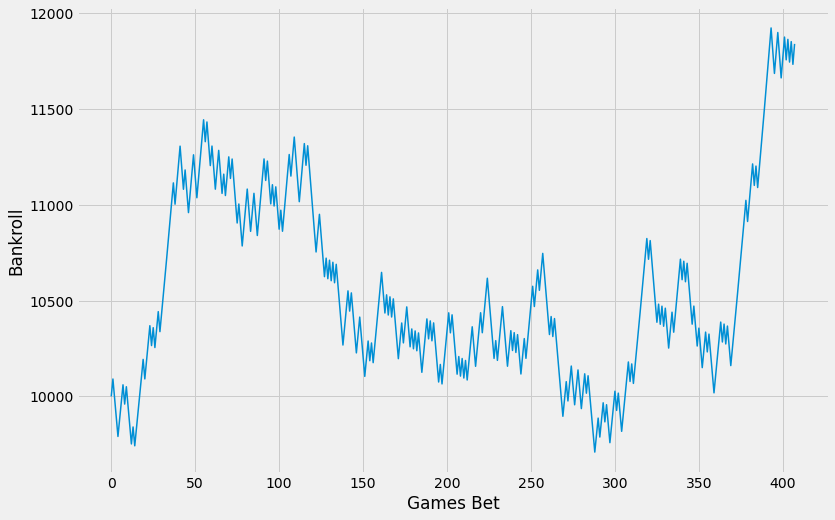

min balance: 9709.590158242947 
max balance: 11922.651989431763 
final balance: 11721.048950478526 
win percentage 54.66


,index,GAME_DATE,home_team,away_team,spread,HOME_SCORE,AWAY_SCORE,point_diff,pred_home,pred_away,home_cover,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,43,2014-11-19,DET,PHX,2.5,86,88,-2,103.876845,103.609150,1.0,0.267695,1,1,2.767695,10000.000000,100.000000,10090.909091
1,45,2014-11-19,MIN,NYK,-1.0,115,99,16,93.621736,95.080778,1.0,-1.459042,0,0,-2.459042,10090.909091,100.909091,9990.000000
2,64,2014-11-22,CLE,TOR,-3.0,93,110,-17,106.572943,101.090736,0.0,5.482207,1,0,2.482207,9990.000000,99.900000,9890.100000
3,91,2014-11-26,PHI,BKN,7.0,91,99,-8,103.972836,108.839991,0.0,-4.867156,1,0,2.132844,9890.100000,98.901000,9791.199000
4,94,2014-11-26,DET,LAC,8.5,98,104,-6,92.754694,98.422898,1.0,-5.668204,1,1,2.831796,9791.199000,97.911990,9880.209900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,5938,2019-02-07,ORL,MIN,-3.5,122,112,10,116.286934,115.561331,1.0,0.725603,0,0,-2.774397,11863.157837,118.631578,11744.526258
404,5953,2019-02-09,ATL,CHA,2.0,120,129,-9,115.081604,119.645749,0.0,-4.564146,0,1,-2.564146,11744.526258,117.445263,11851.294679
405,5958,2019-02-09,HOU,OKC,-2.5,112,117,-5,116.076912,111.159266,0.0,4.917646,1,0,2.417646,11851.294679,118.512947,11732.781732
406,5976,2019-02-12,MEM,SAS,7.0,107,108,-1,105.319031,109.777114,1.0,-4.458083,1,1,2.541917,11732.781732,117.327817,11839.443384


In [495]:
select_bets_lr, best_thresholds_lr = find_optimal_threshold(lr_preds, test_indices)
simulate_bets(select_bets_lr)

In [497]:
coefs = lr_pipeline.named_steps['linreg'].coef_
coefs_df = pd.DataFrame({'feature':features.columns, 'coefficient':coefs})
coefs_df.sort_values('coefficient')


,feature,coefficient
8,DREB_team_x,-2.323936e+13
114,OREB_PCT_team_y,-2.069669e+13
155,DREB_PCT_opp_y,-2.069669e+13
7,OREB_team_x,-1.875359e+13
33,OREB_PCT_team_x,-1.272630e+13
...,...,...
73,OREB_PCT_opp_x,1.253598e+13
34,DREB_PCT_team_x,1.253598e+13
154,OREB_PCT_opp_y,2.746404e+13
115,DREB_PCT_team_y,2.746404e+13


In [93]:
# Save the Model to file
filename = "../models/linreg_team_score_model.pkl"
with open(filename, 'wb') as file:
    pickle.dump(lr_pipeline, file)
    


In [ ]:
select_bets_lr, best_thresholds_lr = find_optimal_threshold(lr_preds, test_indices)
simulate_bets(select_bets_lr)

#### Some Features

<AxesSubplot:>

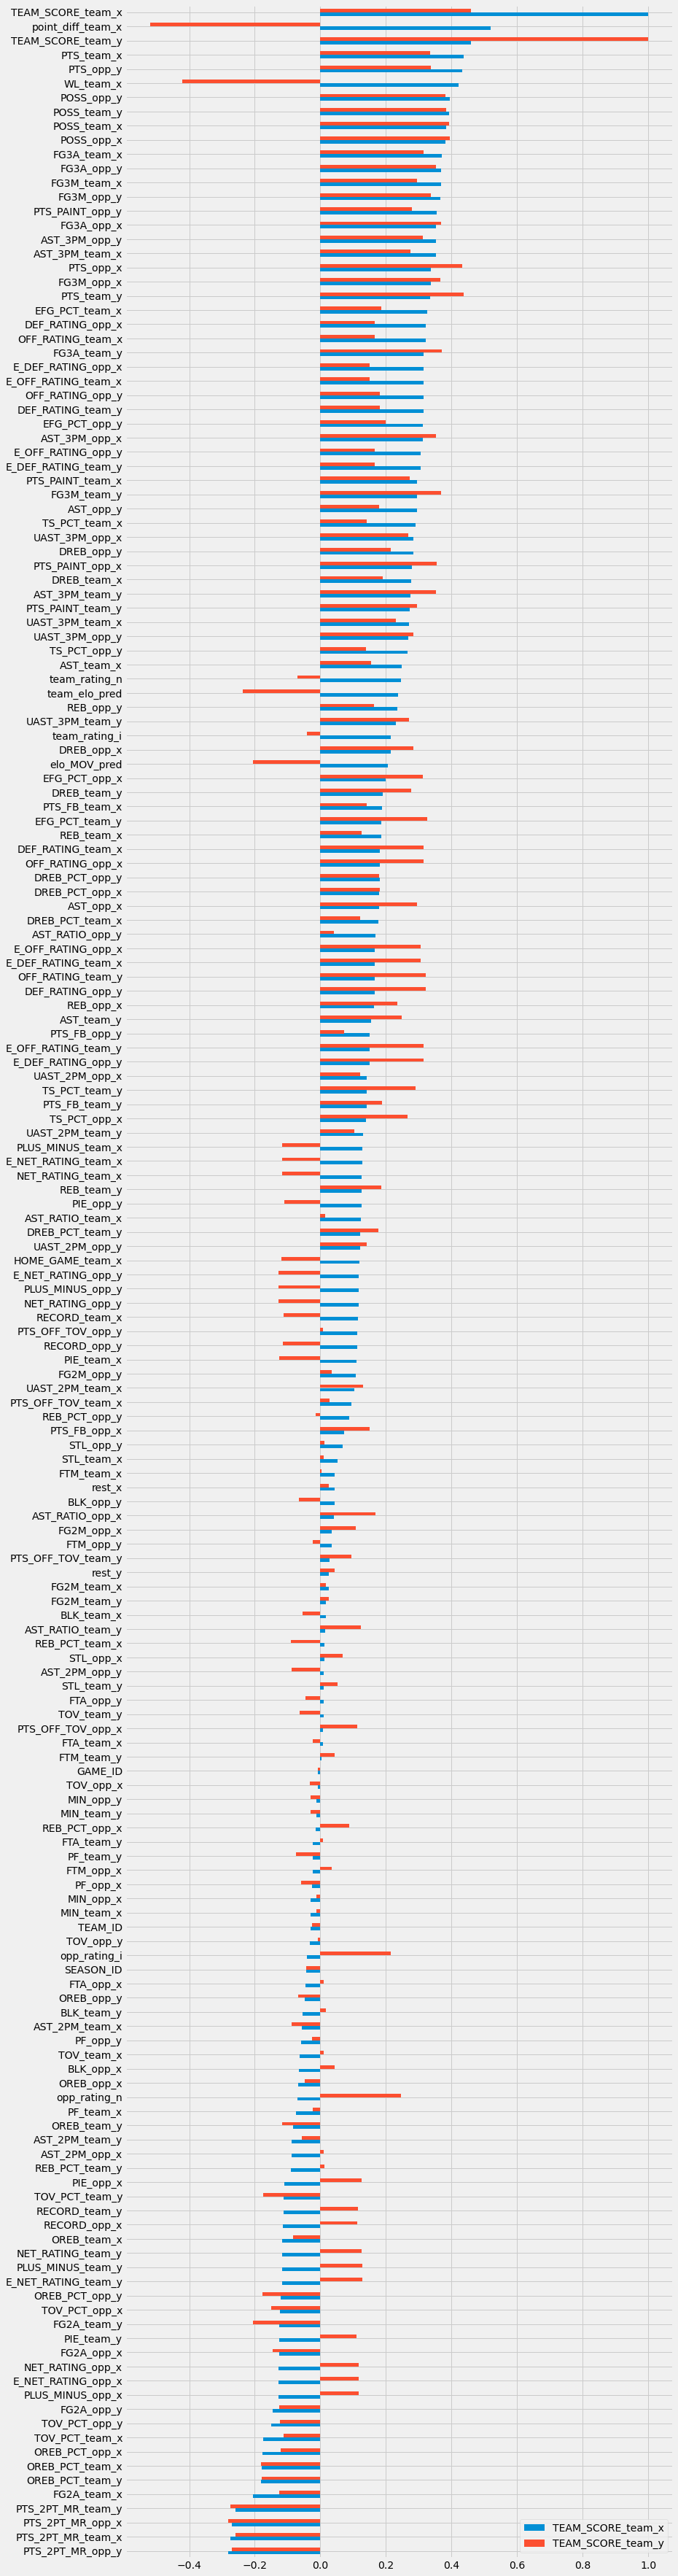

In [556]:
corr = full_df.corr()
corr[['TEAM_SCORE_team_x', 'TEAM_SCORE_team_y']].sort_values("TEAM_SCORE_team_x").plot(kind='barh', figsize=(12,60))

In [ ]:
some_features = features[['team_rating_i', 'opp_rating_i', 'PTS_team_x', 'PTS_team_y', 'PTS_opp_x', 'PTS_opp_y',
                         '']]

In [557]:
features.columns

Index(['RECORD_team_x', 'FG2M_team_x', 'FG2A_team_x', 'FG3M_team_x',
       'FG3A_team_x', 'FTM_team_x', 'FTA_team_x', 'OREB_team_x', 'DREB_team_x',
       'REB_team_x',
       ...
       'TS_PCT_opp_y', 'EFG_PCT_opp_y', 'AST_RATIO_opp_y', 'TOV_PCT_opp_y',
       'rest_y', 'team_elo_pred', 'team_rating_i', 'opp_rating_i',
       'elo_MOV_pred', 'HOME_GAME'],
      dtype='object', length=167)

### Ridge Regression

In [569]:

params = {'ridge__alpha':np.logspace(2, 3, 30)}

rr_pipeline = Pipeline([('scaler', StandardScaler()),
                          ('ridge', Ridge())])

ridge_gs = GridSearchCV(rr_pipeline, param_grid=params, scoring='neg_root_mean_squared_error', cv=tscv)
ridge_gs.fit(X_train, score_train)

best_ridge = ridge_gs.best_estimator_
print(best_ridge)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=788.0462815669912))])


In [570]:
feature_names = X_train.columns
ridge_coefs = best_ridge.named_steps['ridge'].coef_
coefs = pd.DataFrame({'feature':feature_names, 'coefficient':ridge_coefs})
coefs.sort_values('coefficient')

,feature,coefficient
164,opp_rating_i,-0.645077
66,PTS_FB_opp_x,-0.388194
95,PF_team_y,-0.382384
11,STL_team_x,-0.312109
105,PIE_team_y,-0.275158
...,...,...
165,elo_MOV_pred,0.618888
26,PTS_FB_team_x,0.676497
144,POSS_opp_y,0.770514
166,HOME_GAME,0.935601


best thresholds: (8, 9)
num_games_bet: 349
win percetange at threshold: 0.5444126074498568


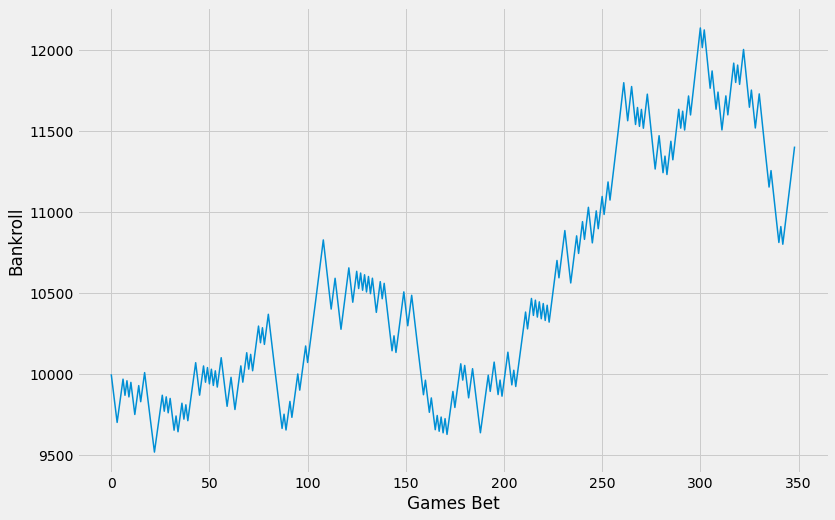

min balance: 9519.851467972092 
max balance: 12137.661357733334 
final balance: 11291.502380208904 
win percentage 54.44


,index,GAME_DATE,home_team,away_team,spread,HOME_SCORE,AWAY_SCORE,point_diff,pred_home,pred_away,home_cover,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,16,2014-11-15,POR,BKN,-2.5,97,87,10,105.049623,110.683051,1.0,-5.633427,0,0,-8.133427,10000.000000,100.000000,9900.000000
1,23,2014-11-16,LAL,GSW,8.0,115,136,-21,104.380607,103.638512,0.0,0.742095,1,0,8.742095,9900.000000,99.000000,9801.000000
2,34,2014-11-18,MIL,NYK,-1.5,117,113,4,98.271378,105.498179,1.0,-7.226800,0,0,-8.726800,9801.000000,98.010000,9702.990000
3,36,2014-11-18,SAC,NOP,-3.0,100,106,-6,94.743602,100.307021,0.0,-5.563419,0,1,-8.563419,9702.990000,97.029900,9791.199000
4,37,2014-11-19,CLE,SAS,-1.5,90,92,-2,98.738997,106.065398,0.0,-7.326401,0,1,-8.826401,9791.199000,97.911990,9880.209900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,5920,2019-02-04,PHX,HOU,8.5,110,118,-8,110.048834,109.857022,1.0,0.191812,1,1,8.691812,11000.067783,110.000678,11100.068399
345,5922,2019-02-05,CHA,LAC,-3.5,115,117,-2,115.076363,120.138430,0.0,-5.062067,0,1,-8.562067,11100.068399,111.000684,11200.978112
346,5930,2019-02-06,BKN,DEN,3.0,135,130,5,119.299701,113.452549,1.0,5.847152,1,1,8.847152,11200.978112,112.009781,11302.805185
347,5940,2019-02-07,BOS,LAL,-9.5,128,129,-1,114.152517,113.475384,0.0,0.677133,0,1,-8.822867,11302.805185,113.028052,11405.557960


In [573]:
best_ridge = Pipeline([('scaler', StandardScaler()),
                          ('ridge', Ridge(alpha=348))])
best_ridge.fit(X_train, score_train)
ridge_preds = best_ridge.predict(X_test)
select_bets_ridge, best_thresholds_ridge = find_optimal_threshold(ridge_preds, test_indices)
simulate_bets(select_bets_ridge)

In [575]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

tscv = TimeSeriesSplit()
ridge_rfe = RFECV(Ridge(alpha=348), min_features_to_select=20, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
ridge_rfe.fit(X_train_scaled, score_train)

ridge_feature_mask = ridge_rfe.support_
ridge_reduced = ridge_rfe.estimator_


Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.


best thresholds: (16, 19)
num_games_bet: 317
win percetange at threshold: 0.5425867507886435


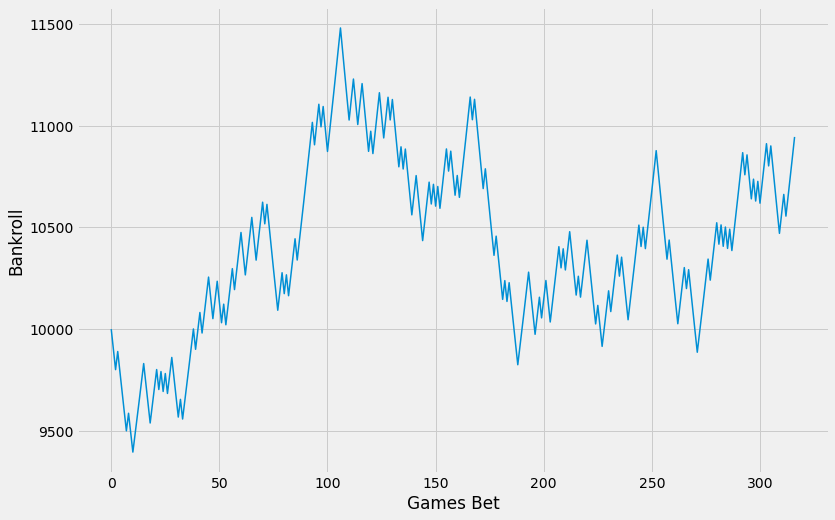

min balance: 9395.981305823474 
max balance: 11479.470763040612 
final balance: 11043.677625864695 
win percentage 54.26


,index,GAME_DATE,home_team,away_team,spread,HOME_SCORE,AWAY_SCORE,point_diff,pred_home,pred_away,home_cover,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,12,2014-11-15,TOR,UTA,-11.5,111,93,18,87.961192,93.187938,1.0,-5.226745,0,0,-16.726745,10000.000000,100.000000,9900.000000
1,51,2014-11-21,PHI,PHX,9.0,96,122,-26,107.602482,99.077391,0.0,8.525091,1,0,17.525091,9900.000000,99.000000,9801.000000
2,81,2014-11-24,DAL,IND,-14.0,100,111,-11,99.047221,103.575763,0.0,-4.528542,0,1,-18.528542,9801.000000,98.010000,9890.100000
3,85,2014-11-25,MIL,DET,-3.5,98,86,12,97.955694,110.546281,1.0,-12.590587,0,0,-16.090587,9890.100000,98.901000,9791.199000
4,97,2014-11-26,OKC,UTA,-4.5,97,82,15,93.794540,107.001432,1.0,-13.206892,0,0,-17.706892,9791.199000,97.911990,9693.287010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,5908,2019-02-02,GSW,LAL,-15.0,115,101,14,114.372263,116.235325,0.0,-1.863062,0,1,-16.863062,10555.097579,105.550976,10651.053011
313,5948,2019-02-08,PHX,GSW,17.0,107,117,-10,116.398557,116.235416,1.0,0.163141,1,1,17.163141,10651.053011,106.510530,10747.880766
314,5949,2019-02-08,NOP,MIN,-6.0,122,117,5,108.884704,120.039011,0.0,-11.154307,0,1,-17.154307,10747.880766,107.478808,10845.588773
315,5964,2019-02-10,GSW,MIA,-13.5,120,118,2,108.417756,113.729323,0.0,-5.311568,0,1,-18.811568,10845.588773,108.455888,10944.185035


In [577]:
X_test_reduced = X_test_scaled[:, feature_mask]

ridge_reduced.fit(X_test_reduced, score_test)
ridge_reduced_preds = ridge_reduced.predict(X_test_reduced)

select_bets_ridge, best_thresholds_ridge = find_optimal_threshold(ridge_reduced_preds, test_indices)
simulate_bets(select_bets_ridge)

In [578]:
X_test_reduced

# feature_names = X_train.columns
# en_coefs = best_en.named_steps['en'].coef_
# coefs = pd.DataFrame({'feature':feature_names, 'coefficient':en_coefs})
# coefs.sort_values('coefficient')

array([[ 0.43287161, -0.86133678,  1.81786336, ...,  0.86661788,
        -0.0796242 ,  0.99997236],
       [ 0.43287161,  1.49096053,  1.51229114, ...,  0.76938314,
         0.0796286 , -1.00002764],
       [ 0.43287161, -0.61799568,  1.81786336, ...,  0.92433643,
        -0.19662625,  0.99997236],
       ...,
       [-0.04156639, -1.51024639,  2.78550874, ...,  1.76469959,
        -0.33637871, -1.00002764],
       [ 0.90730961, -1.10467788,  3.04015226, ...,  1.40052041,
         0.25513168, -1.00002764],
       [-0.04156639, -1.51024639,  2.68365133, ...,  1.71410529,
        -0.25512728,  0.99997236]])

### Elastic Net Pipeline

In [501]:
pipeline_en = Pipeline([('scaler', StandardScaler()),
                    ('en', ElasticNet(max_iter=5000))])

params = {'en__alpha':np.logspace(-1, 2, 10),
         'en__l1_ratio':np.linspace(0.05, 1, 20),
         'en__normalize': [True, False]}


en_gs = GridSearchCV(pipeline_en, param_grid=params, n_jobs=-1, cv=tscv, verbose=1)
en_gs.fit(X_train, score_train)

print("best estimator:", en_gs.best_estimator_)
print("best parameters:", en_gs.best_params_)
best_en = en_gs.best_estimator_
en_preds = best_en.predict(X_test)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  4.4min finished


best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.1, l1_ratio=0.05, max_iter=5000))])
best parameters: {'en__alpha': 0.1, 'en__l1_ratio': 0.05, 'en__normalize': False}


In [502]:
best_en = Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.1, l1_ratio=0.05, max_iter=5000))])


best_en.fit(X_train, score_train)
en_preds = best_en.predict(X_test)

In [503]:
feature_names = X_train.columns
en_coefs = best_en.named_steps['en'].coef_
coefs = pd.DataFrame({'feature':feature_names, 'coefficient':en_coefs})
coefs.sort_values('coefficient')

,feature,coefficient
164,opp_rating_i,-0.559913
66,PTS_FB_opp_x,-0.321978
93,BLK_team_y,-0.265546
52,BLK_opp_x,-0.213474
11,STL_team_x,-0.210051
...,...,...
144,POSS_opp_y,0.588534
26,PTS_FB_team_x,0.608257
165,elo_MOV_pred,0.614783
166,HOME_GAME,0.922715


best thresholds: (4, 5)
num_games_bet: 414
win percetange at threshold: 0.5314009661835749


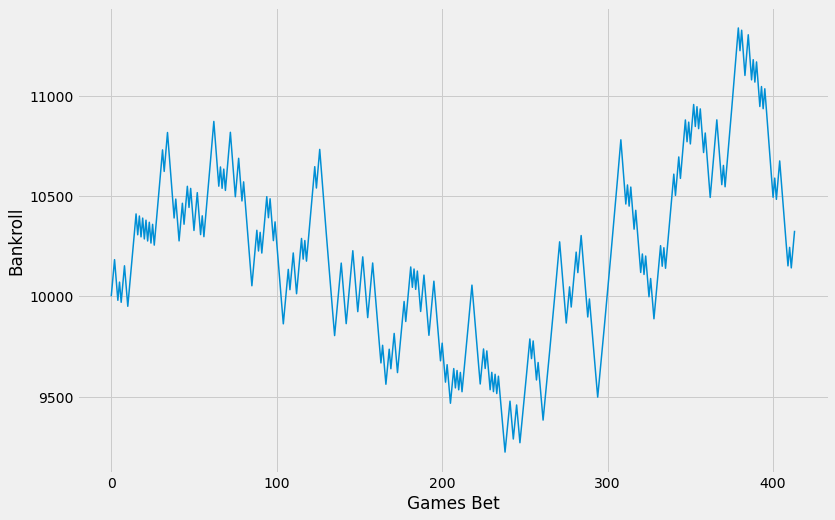

min balance: 9223.235482713253 
max balance: 11337.809427273896 
final balance: 10420.590991971905 
win percentage 53.14


,index,GAME_DATE,home_team,away_team,spread,HOME_SCORE,AWAY_SCORE,point_diff,pred_home,pred_away,home_cover,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,26,2014-11-17,BOS,PHX,2.0,114,118,-4,98.311422,105.006802,0.0,-6.695380,0,1,-4.695380,10000.000000,100.000000,10090.909091
1,44,2014-11-19,TOR,MEM,-6.0,96,92,4,101.848768,100.200045,0.0,1.648723,0,1,-4.351277,10090.909091,100.909091,10182.644628
2,61,2014-11-21,POR,CHI,-8.0,105,87,18,107.890815,104.128858,1.0,3.761957,0,0,-4.238043,10182.644628,101.826446,10080.818182
3,106,2014-11-28,HOU,LAC,4.5,85,102,-17,105.099890,105.079122,0.0,0.020768,1,0,4.520768,10080.818182,100.808182,9980.010000
4,128,2014-12-01,WAS,MIA,-4.5,107,86,21,106.017519,97.001166,1.0,9.016353,1,1,4.516353,9980.010000,99.800100,10070.737364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,5950,2019-02-08,SAC,MIA,-4.0,102,96,6,118.840003,109.905459,1.0,8.934544,1,1,4.934544,10151.634688,101.516347,10243.922277
410,5956,2019-02-09,CHI,WAS,2.0,125,134,-9,114.479059,111.577036,0.0,2.902023,1,0,4.902023,10243.922277,102.439223,10141.483054
411,5974,2019-02-12,ATL,LAL,6.0,117,113,4,111.838658,113.490262,1.0,-1.651604,1,1,4.348396,10141.483054,101.414831,10233.678354
412,5988,2019-02-13,POR,GSW,2.0,129,107,22,108.377194,105.450253,1.0,2.926940,1,1,4.926940,10233.678354,102.336784,10326.711794


In [504]:
select_bets_en, best_thresholds_en = find_optimal_threshold(en_preds, test_indices)
simulate_bets(select_bets_en)

### RFECV ElasticNet

In [559]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

tscv = TimeSeriesSplit()
en_rfe = RFECV(ElasticNet(alpha=0.1, l1_ratio=0.05, max_iter=5000), min_features_to_select=20, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
en_rfe.fit(X_train_scaled, score_train)

feature_mask = en_rfe.support_
en_reduced = en_rfe.estimator_



Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
Fitting estimator with 151 features.
Fitting estimator with 150 features.
Fitting estimator with 149 features.
Fitting estimator with 148 features.
Fitting estimator with 147 features.
Fitting estimator with 146 features.
Fitting estimator with 145 features.
Fitting estimator with 144 features.
Fitting estimator with 143 features.
Fitting estimator with 142 features.
Fitting estimator with 141 features.
F

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [ ]:
X_test_reduced = X_test_scaled[:, feature_mask]




best thresholds: (3, 5)
num_games_bet: 852
win percetange at threshold: 0.534037558685446


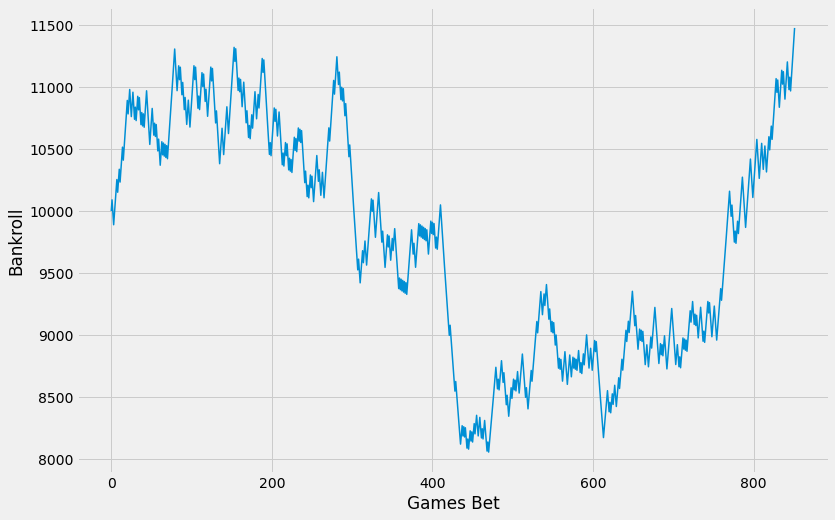

min balance: 8057.212765460743 
max balance: 11476.79598518756 
final balance: 11362.028025335685 
win percentage 53.400000000000006


,index,GAME_DATE,home_team,away_team,spread,HOME_SCORE,AWAY_SCORE,point_diff,pred_home,pred_away,home_cover,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,0,2014-11-14,IND,DEN,-2.5,87,108,-21,108.526025,109.886941,0.0,-1.360917,0,1,-3.860917,10000.000000,100.000000,10090.909091
1,9,2014-11-14,LAL,SAS,8.5,80,93,-13,101.990305,106.737085,0.0,-4.746780,1,0,3.753220,10090.909091,100.909091,9990.000000
2,13,2014-11-15,CHI,IND,-9.0,90,99,-9,116.682104,104.058241,0.0,12.623863,1,0,3.623863,9990.000000,99.900000,9890.100000
3,17,2014-11-15,SAC,SAS,1.5,94,91,3,97.771822,96.094271,1.0,1.677551,1,1,3.177551,9890.100000,98.901000,9980.010000
4,20,2014-11-16,NYK,DEN,-2.0,109,93,16,105.747146,98.883806,1.0,6.863340,1,1,4.863340,9980.010000,99.800100,10070.737364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,5976,2019-02-12,MEM,SAS,7.0,107,108,-1,105.170073,108.724285,1.0,-3.554211,1,1,3.445789,11068.773155,110.687732,11169.398366
848,5988,2019-02-13,POR,GSW,2.0,129,107,22,107.826149,105.475180,1.0,2.350969,1,1,4.350969,11169.398366,111.693984,11270.938351
849,5990,2019-02-14,ORL,CHA,-4.0,127,89,38,109.703383,101.602219,1.0,8.101164,1,1,4.101164,11270.938351,112.709384,11373.401427
850,5994,2019-02-21,PHI,MIA,-5.5,106,102,4,109.206752,107.389025,0.0,1.817727,0,1,-3.682273,11373.401427,113.734014,11476.795985


In [560]:
X_test_reduced = X_test_scaled[:, feature_mask]

en_reduced.fit(X_test_reduced, score_test)
en_reduced_preds = en_reduced.predict(X_test_reduced)

select_bets_en, best_thresholds_en = find_optimal_threshold(en_reduced_preds, test_indices)
simulate_bets(select_bets_en)

In [53]:
feature_names = X_train.loc[:, feature_mask].columns
coefs = en_reduced.coef_

coef_df = pd.DataFrame({'feature':feature_names, 'coefficient':coefs})
coef_df = coef_df.sort_values('coefficient').loc[coef_df['coefficient'] != 0]

coef_df

NameError: name 'en_reduced' is not defined

### Lasso Regression

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso_cv = LassoCV(cv = tscv, max_iter=10000)

lasso_cv.fit(X_train_scaled, score_train)

best_alpha = lasso_cv.alpha_
print(best_alpha)

In [176]:
pipeline_lasso = Pipeline([('scaler', StandardScaler()),
                        ('lasso', Lasso(alpha=0.0122303788))])

pipeline_lasso.fit(X_train, score_train)
lasso_preds = pipeline_lasso.predict(X_test)


best thresholds: (4, 5)
num_games_bet: 472
win percetange at threshold: 0.5338983050847458


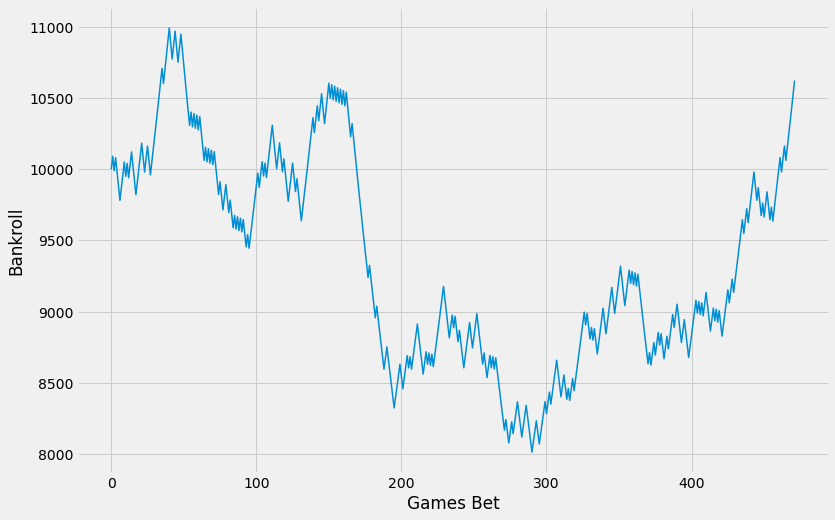

min balance: 8013.3737056649925 
max balance: 10992.092103265079 
final balance: 10719.55620762257 
win percentage 53.39


,index,GAME_DATE,home_team,away_team,spread,HOME_SCORE,AWAY_SCORE,point_diff,pred_home,pred_away,home_cover,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,9,2015-11-07,SAC,GSW,14.0,94,103,-9,107.592283,116.732090,1.0,-9.139808,1,1,4.860192,10000.000000,100.000000,10090.909091
1,34,2015-11-11,POR,SAS,6.5,101,113,-12,100.399461,102.121031,0.0,-1.721570,1,0,4.778430,10090.909091,100.909091,9990.000000
2,48,2015-11-13,DEN,HOU,6.5,107,98,9,104.591007,106.571184,1.0,-1.980177,1,1,4.519823,9990.000000,99.900000,10080.818182
3,57,2015-11-13,TOR,NOP,-10.5,100,81,19,107.023625,101.342476,1.0,5.681149,0,0,-4.818851,10080.818182,100.808182,9980.010000
4,103,2015-11-20,OKC,NYK,-6.5,90,93,-3,106.310548,95.795036,0.0,10.515512,1,0,4.015512,9980.010000,99.800100,9880.209900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,5949,2020-08-29,MIL,ORL,-14.5,118,104,14,122.324815,111.828631,0.0,10.496183,0,1,-4.003817,10245.315520,102.453155,10338.454752
468,5950,2020-08-29,LAL,POR,-14.0,131,122,9,119.063512,109.869773,0.0,9.193738,0,1,-4.806262,10338.454752,103.384548,10432.440704
469,5956,2020-08-31,OKC,HOU,4.5,104,100,4,114.247336,113.965435,1.0,0.281901,1,1,4.781901,10432.440704,104.324407,10527.281074
470,5990,2020-09-26,LAL,DEN,-5.5,117,107,10,111.109952,101.522578,1.0,9.587373,1,1,4.087373,10527.281074,105.272811,10622.983629


In [177]:
select_bets_lasso, best_thresholds_lasso = find_optimal_threshold(lasso_preds, test_indices)
simulate_bets(select_bets_lasso)

In [182]:
feature_names = X_train.columns
coefs = pipeline_lasso.named_steps['lasso'].coef_[0]

coef_df = pd.DataFrame({'feature':feature_names, 'coefficient':coefs})
coef_df = coef_df.sort_values('coefficient').loc[coef_df['coefficient'] != 0]

coef_df['coefficient'].value_counts()

-0.030414    167
Name: coefficient, dtype: int64

In [86]:
features

,HOME_RECORD,HOME_FG2M,HOME_FG2A,HOME_FG3M,HOME_FG3A,HOME_FTM,HOME_FTA,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,HOME_PTS,HOME_PLUS_MINUS,HOME_E_OFF_RATING,HOME_OFF_RATING,HOME_E_DEF_RATING,HOME_DEF_RATING,HOME_E_NET_RATING,HOME_NET_RATING,HOME_POSS,HOME_PIE,HOME_PTS_2PT_MR,HOME_PTS_FB,HOME_PTS_OFF_TOV,HOME_PTS_PAINT,HOME_AST_2PM,HOME_UAST_2PM,HOME_AST_3PM,HOME_UAST_3PM,HOME_OREB_PCT,HOME_DREB_PCT,HOME_REB_PCT,HOME_TS_PCT,HOME_EFG_PCT,HOME_AST_RATIO,HOME_TOV_PCT,HOME_RECORD_opp,HOME_FG2M_opp,HOME_FG2A_opp,HOME_FG3M_opp,HOME_FG3A_opp,HOME_FTM_opp,HOME_FTA_opp,HOME_OREB_opp,HOME_DREB_opp,HOME_REB_opp,HOME_AST_opp,HOME_STL_opp,HOME_BLK_opp,HOME_TOV_opp,HOME_PF_opp,HOME_PTS_opp,HOME_PLUS_MINUS_opp,HOME_E_OFF_RATING_opp,HOME_OFF_RATING_opp,HOME_E_DEF_RATING_opp,HOME_DEF_RATING_opp,HOME_E_NET_RATING_opp,HOME_NET_RATING_opp,HOME_POSS_opp,HOME_PIE_opp,HOME_PTS_2PT_MR_opp,HOME_PTS_FB_opp,HOME_PTS_OFF_TOV_opp,HOME_PTS_PAINT_opp,HOME_AST_2PM_opp,HOME_UAST_2PM_opp,HOME_AST_3PM_opp,HOME_UAST_3PM_opp,HOME_OREB_PCT_opp,HOME_DREB_PCT_opp,HOME_REB_PCT_opp,HOME_TS_PCT_opp,HOME_EFG_PCT_opp,HOME_AST_RATIO_opp,HOME_TOV_PCT_opp,HOME_rest,AWAY_RECORD,AWAY_FG2M,AWAY_FG2A,AWAY_FG3M,AWAY_FG3A,AWAY_FTM,AWAY_FTA,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PTS,AWAY_PLUS_MINUS,AWAY_E_OFF_RATING,AWAY_OFF_RATING,AWAY_E_DEF_RATING,AWAY_DEF_RATING,AWAY_E_NET_RATING,AWAY_NET_RATING,AWAY_POSS,AWAY_PIE,AWAY_PTS_2PT_MR,AWAY_PTS_FB,AWAY_PTS_OFF_TOV,AWAY_PTS_PAINT,AWAY_AST_2PM,AWAY_UAST_2PM,AWAY_AST_3PM,AWAY_UAST_3PM,AWAY_OREB_PCT,AWAY_DREB_PCT,AWAY_REB_PCT,AWAY_TS_PCT,AWAY_EFG_PCT,AWAY_AST_RATIO,AWAY_TOV_PCT,AWAY_RECORD_opp,AWAY_FG2M_opp,AWAY_FG2A_opp,AWAY_FG3M_opp,AWAY_FG3A_opp,AWAY_FTM_opp,AWAY_FTA_opp,AWAY_OREB_opp,AWAY_DREB_opp,AWAY_REB_opp,AWAY_AST_opp,AWAY_STL_opp,AWAY_BLK_opp,AWAY_TOV_opp,AWAY_PF_opp,AWAY_PTS_opp,AWAY_PLUS_MINUS_opp,AWAY_E_OFF_RATING_opp,AWAY_OFF_RATING_opp,AWAY_E_DEF_RATING_opp,AWAY_DEF_RATING_opp,AWAY_E_NET_RATING_opp,AWAY_NET_RATING_opp,AWAY_POSS_opp,AWAY_PIE_opp,AWAY_PTS_2PT_MR_opp,AWAY_PTS_FB_opp,AWAY_PTS_OFF_TOV_opp,AWAY_PTS_PAINT_opp,AWAY_AST_2PM_opp,AWAY_UAST_2PM_opp,AWAY_AST_3PM_opp,AWAY_UAST_3PM_opp,AWAY_OREB_PCT_opp,AWAY_DREB_PCT_opp,AWAY_REB_PCT_opp,AWAY_TS_PCT_opp,AWAY_EFG_PCT_opp,AWAY_AST_RATIO_opp,AWAY_TOV_PCT_opp,AWAY_rest,home_elo_pred,home_rating_i,away_rating_i,elo_MOV_pred
0,0.4,26.8,59.4,5.8,16.2,23.0,29.4,11.8,27.4,39.2,19.0,8.6,4.2,16.6,22.0,94.0,3.2,100.72,103.16,98.42,99.20,2.28,3.94,91.0,0.5110,18.0,7.0,18.2,34.6,14.2,12.0,4.6,1.0,0.290640,0.728723,0.501279,0.572696,0.469577,20.879121,15.789073,0.6,29.6,62.0,4.8,13.2,17.2,24.0,10.2,28.8,39.0,20.4,6.6,4.4,16.6,23.0,90.8,-3.2,98.42,99.20,100.72,103.16,-2.28,-3.94,91.4,0.4890,23.2,7.8,17.6,35.2,15.6,13.4,4.4,0.2,0.271277,0.709360,0.498721,0.564115,0.489362,22.319475,16.217272,2.0,0.8,31.4,69.8,3.6,12.0,22.4,30.4,12.8,32.4,45.2,22.8,9.8,3.8,16.2,24.0,96.0,8.4,97.46,99.48,90.12,90.34,7.36,9.12,96.6,0.5760,25.6,9.8,20.8,36.0,19.0,11.8,3.4,0.2,0.292237,0.710526,0.505593,0.542446,0.449878,23.602484,14.545324,0.2,30.6,67.8,3.6,13.2,15.6,23.0,13.2,31.0,44.2,18.0,8.6,8.0,19.4,25.2,87.6,-8.4,90.12,90.34,97.46,99.48,-7.36,-9.12,97.0,0.4240,15.4,10.4,16.2,44.6,14.8,15.2,2.8,0.6,0.289474,0.707763,0.494407,0.508947,0.444444,18.556701,17.553384,1.0,0.640065,1300.000000,1300.000000,3.57
1,0.4,31.0,69.6,4.2,12.6,12.8,16.0,13.6,29.0,42.6,23.4,7.8,7.6,17.6,25.8,87.4,-4.8,93.64,94.84,99.02,100.98,-5.40,-6.12,92.0,0.4580,24.6,16.0,17.2,36.6,19.2,11.2,3.8,0.4,0.323810,0.710784,0.514493,0.509799,0.453771,25.434783,16.473231,0.6,29.8,62.6,4.2,14.8,20.0,27.0,11.8,28.4,40.2,23.0,9.2,5.0,15.6,19.0,92.2,4.8,99.02,100.98,93.64,94.84,5.40,6.12,91.4,0.5420,17.4,15.4,19.0,41.2,18.8,10.0,3.8,0.2,0.289216,0.676190,0.485507,0.553156,0.466408,25.164114,14.874142,2.0,0.4,31.2,66.0,5.4,18.0,22.2,30.6,12.6,26.8,39.4,23.4,8.2,7.0,15.0,26.2,100.8,-4.4,101.00,102.72,103.54,107.86,-2.54,-5.14,98.2,0.4646,17.8,16.0,21.4,43.2,18.6,12.0,4.2,1.0,0.28

In [88]:
pipeline_lasso = Pipeline([('scaler', StandardScaler()),
                        ('lasso', Lasso(alpha=0.18149))])

pipeline_lasso.fit(features, scores)

filename = '../models/best_lasso.pkl'
pickle.dump(pipeline_lasso, open(filename, 'wb'))

In [191]:
X_train

,RECORD_team_x,FG2M_team_x,FG2A_team_x,FG3M_team_x,FG3A_team_x,FTM_team_x,FTA_team_x,OREB_team_x,DREB_team_x,REB_team_x,AST_team_x,STL_team_x,BLK_team_x,TOV_team_x,PF_team_x,PTS_team_x,PLUS_MINUS_team_x,E_OFF_RATING_team_x,OFF_RATING_team_x,E_DEF_RATING_team_x,DEF_RATING_team_x,E_NET_RATING_team_x,NET_RATING_team_x,POSS_team_x,PIE_team_x,PTS_2PT_MR_team_x,PTS_FB_team_x,PTS_OFF_TOV_team_x,PTS_PAINT_team_x,AST_2PM_team_x,UAST_2PM_team_x,AST_3PM_team_x,UAST_3PM_team_x,OREB_PCT_team_x,DREB_PCT_team_x,REB_PCT_team_x,TS_PCT_team_x,EFG_PCT_team_x,AST_RATIO_team_x,TOV_PCT_team_x,RECORD_opp_x,FG2M_opp_x,FG2A_opp_x,FG3M_opp_x,FG3A_opp_x,FTM_opp_x,FTA_opp_x,OREB_opp_x,DREB_opp_x,REB_opp_x,AST_opp_x,STL_opp_x,BLK_opp_x,TOV_opp_x,PF_opp_x,PTS_opp_x,PLUS_MINUS_opp_x,E_OFF_RATING_opp_x,OFF_RATING_opp_x,E_DEF_RATING_opp_x,DEF_RATING_opp_x,E_NET_RATING_opp_x,NET_RATING_opp_x,POSS_opp_x,PIE_opp_x,PTS_2PT_MR_opp_x,PTS_FB_opp_x,PTS_OFF_TOV_opp_x,PTS_PAINT_opp_x,AST_2PM_opp_x,UAST_2PM_opp_x,AST_3PM_opp_x,UAST_3PM_opp_x,OREB_PCT_opp_x,DREB_PCT_opp_x,REB_PCT_opp_x,TS_PCT_opp_x,EFG_PCT_opp_x,AST_RATIO_opp_x,TOV_PCT_opp_x,rest_x,RECORD_team_y,FG2M_team_y,FG2A_team_y,FG3M_team_y,FG3A_team_y,FTM_team_y,FTA_team_y,OREB_team_y,DREB_team_y,REB_team_y,AST_team_y,STL_team_y,BLK_team_y,TOV_team_y,PF_team_y,PTS_team_y,PLUS_MINUS_team_y,E_OFF_RATING_team_y,OFF_RATING_team_y,E_DEF_RATING_team_y,DEF_RATING_team_y,E_NET_RATING_team_y,NET_RATING_team_y,POSS_team_y,PIE_team_y,PTS_2PT_MR_team_y,PTS_FB_team_y,PTS_OFF_TOV_team_y,PTS_PAINT_team_y,AST_2PM_team_y,UAST_2PM_team_y,AST_3PM_team_y,UAST_3PM_team_y,OREB_PCT_team_y,DREB_PCT_team_y,REB_PCT_team_y,TS_PCT_team_y,EFG_PCT_team_y,AST_RATIO_team_y,TOV_PCT_team_y,RECORD_opp_y,FG2M_opp_y,FG2A_opp_y,FG3M_opp_y,FG3A_opp_y,FTM_opp_y,FTA_opp_y,OREB_opp_y,DREB_opp_y,REB_opp_y,AST_opp_y,STL_opp_y,BLK_opp_y,TOV_opp_y,PF_opp_y,PTS_opp_y,PLUS_MINUS_opp_y,E_OFF_RATING_opp_y,OFF_RATING_opp_y,E_DEF_RATING_opp_y,DEF_RATING_opp_y,E_NET_RATING_opp_y,NET_RATING_opp_y,POSS_opp_y,PIE_opp_y,PTS_2PT_MR_opp_y,PTS_FB_opp_y,PTS_OFF_TOV_opp_y,PTS_PAINT_opp_y,AST_2PM_opp_y,UAST_2PM_opp_y,AST_3PM_opp_y,UAST_3PM_opp_y,OREB_PCT_opp_y,DREB_PCT_opp_y,REB_PCT_opp_y,TS_PCT_opp_y,EFG_PCT_opp_y,AST_RATIO_opp_y,TOV_PCT_opp_y,rest_y,team_elo_pred,team_rating_i,opp_rating_i,elo_MOV_pred,HOME_GAME
142,0.4,26.8,59.4,5.8,16.2,23.0,29.4,11.8,27.4,39.2,19.0,8.6,4.2,16.6,22.0,94.0,3.2,100.72,103.16,98.42,99.20,2.28,3.94,91.0,0.5110,18.0,7.0,18.2,34.6,14.2,12.0,4.6,1.0,0.290640,0.728723,0.501279,0.572696,0.469577,20.879121,15.789073,0.6,29.6,62.0,4.8,13.2,17.2,24.0,10.2,28.8,39.0,20.4,6.6,4.4,16.6,23.0,90.8,-3.2,98.42,99.20,100.72,103.16,-2.28,-3.94,91.4,0.4890,23.2,7.8,17.6,35.2,15.6,13.4,4.4,0.2,0.271277,0.709360,0.498721,0.564115,0.489362,22.319475,16.217272,2.0,0.8,31.4,69.8,3.6,12.0,22.4,30.4,12.8,32.4,45.2,22.8,9.8,3.8,16.2,24.0,96.0,8.4,97.46,99.48,90.12,90.34,7.36,9.12,96.6,0.5760,25.6,9.8,20.8,36.0,19.0,11.8,3.4,0.2,0.292237,0.710526,0.505593,0.542446,0.449878,23.602484,14.545324,0.2,30.6,67.8,3.6,13.2,15.6,23.0,13.2,31.0,44.2,18.0,8.6,8.0,19.4,25.2,87.6,-8.4,90.12,90.34,97.46,99.48,-7.36,-9.12,97.0,0.4240,15.4,10.4,16.2,44.6,14.8,15.2,2.8,0.6,0.289474,0.707763,0.494407,0.508947,0.444444,18.556701,17.553384,1.0,0.593193,1299.375397,1333.852404,-1.23,1
143,0.4,31.0,69.6,4.2,12.6,12.8,16.0,13.6,29.0,42.6,23.4,7.8,7.6,17.6,25.8,87.4,-4.8,93.64,94.84,99.02,100.98,-5.40,-6.12,92.0,0.4580,24.6,16.0,17.2,36.6,19.2,11.2,3.8,0.4,0.323810,0.710784,0.514493,0.509799,0.453771,25.434783,16.473231,0.6,29.8,62.6,4.2,14.8,20.0,27.0,11.8,28.4,40.2,23.0,9.2,5.0,15.6,19.0,92.2,4.8,99.02,100.98,93.64,94.84,5.40,6.12,91.4,0.5420,17.4,15.4,19.0,41.2,18.8,10.0,3.8,0.2,0.289216,0.676190,0.485507,0.553156,0.466408,25.164114,14.874142,2.0,0.4,31.2,66.0,5.4,18.0,22.2,30.6,12.6,26.8,39.4,23.4,8.2,7.0,15.0,26.2,100.8,-4.4,101.00,102.72,103.54,107.86,-2.54,-5.14,98.2,0.4646,17.8,16.0,21.4,43.2,18.6,12.0,4.2,1.0,0.286364,0.687179,0.474699,0.555482,0.467857,23.828921,13.337601,0.6,35.2,

### LinearSVR

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   15.1s remaining:   22.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.0min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.1min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   17.3s remaining:   26.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   22.8s remaining:   34.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.1s remaining:   16.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   40.7s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.6s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.0s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   51.5s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.1min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('svr',
                 LinearSVR(C=0.028059090359016606,
                           loss='squared_epsilon_insensitive',
                           max_iter=10000))])
best parameters: OrderedDict([('svr__C', 0.028059090359016606), ('svr__loss', 'squared_epsilon_insensitive')])
best thresholds: (5, 6)
num_games_bet: 270
win percetange at threshold: 0.5333333333333333


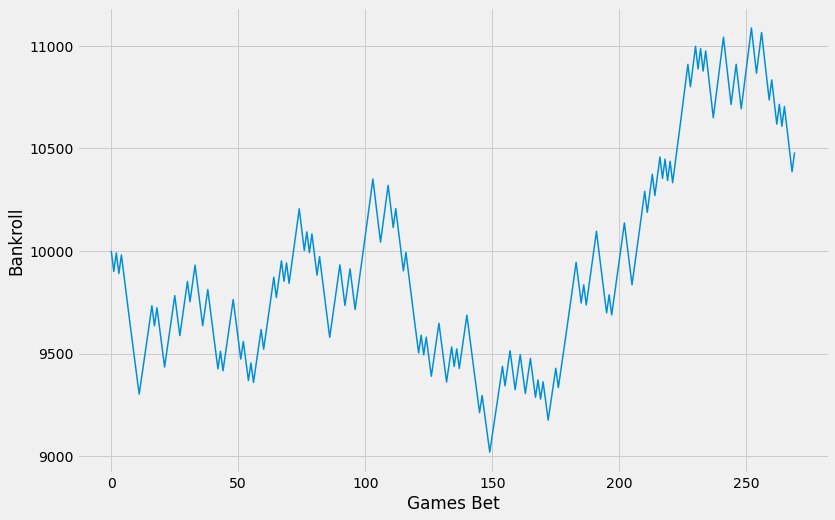

min balance: 9019.578117473284 
max balance: 11086.455161103282 
final balance: 10375.207753199462 
win percentage 53.33


,index,GAME_DATE,home_team,away_team,spread,HOME_SCORE,AWAY_SCORE,point_diff,pred_home,pred_away,home_cover,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,33,2015-11-10,WAS,OKC,6.5,101,125,-24,109.642124,110.603324,0.0,-0.961200,1,0,5.538800,10000.000000,100.000000,9900.000000
1,39,2015-11-11,ATL,NOP,-13.0,106,98,8,109.269332,102.105425,0.0,7.163908,0,1,-5.836092,9900.000000,99.000000,9990.000000
2,103,2015-11-20,OKC,NYK,-6.5,90,93,-3,106.754103,95.242829,0.0,11.511274,1,0,5.011274,9990.000000,99.900000,9890.100000
3,207,2015-12-04,WAS,PHX,2.5,109,106,3,108.139846,105.348646,1.0,2.791200,1,1,5.291200,9890.100000,98.901000,9980.010000
4,218,2015-12-05,MIA,CLE,-5.0,99,84,15,98.892339,98.982382,1.0,-0.090042,0,0,-5.090042,9980.010000,99.800100,9880.209900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,5967,2020-09-06,MIA,MIL,2.0,115,118,-3,110.440933,107.435668,0.0,3.005265,1,0,5.005265,10703.497939,107.034979,10596.462959
266,5971,2020-09-08,HOU,LAL,4.5,102,112,-10,112.146341,111.275828,0.0,0.870513,1,0,5.370513,10596.462959,105.964630,10490.498330
267,5975,2020-09-10,HOU,LAL,5.5,100,110,-10,111.109656,110.943506,0.0,0.166150,1,0,5.666150,10490.498330,104.904983,10385.593347
268,5991,2020-09-27,MIA,BOS,3.0,125,113,12,109.484320,107.066478,1.0,2.417842,1,1,5.417842,10385.593347,103.855933,10480.007832


In [194]:
pipeline_svr = Pipeline([('scaler', StandardScaler()),
                        ('svr', LinearSVR(max_iter=10000))])


search_spaces = {'svr__C': Real(1e-6, 1e+6, prior='log-uniform'),
                'svr__loss' : Categorical(['epsilon_insensitive', 'squared_epsilon_insensitive'])}


svr_bs = BayesSearchCV(pipeline_svr, search_spaces=search_spaces, n_jobs=-1, cv=tscv, verbose=3)
svr_bs.fit(X_train, score_train)

print("best estimator:", svr_bs.best_estimator_)
print("best parameters:", svr_bs.best_params_)
best_svr = svr_bs.best_estimator_
svr_preds = best_svr.predict(X_test)

select_bets_svr, best_thresholds_svr = find_optimal_threshold(svr_preds, test_indices)
simulate_bets(select_bets_svr)

best thresholds: (4, 5)
num_games_bet: 403
win percetange at threshold: 0.543424317617866


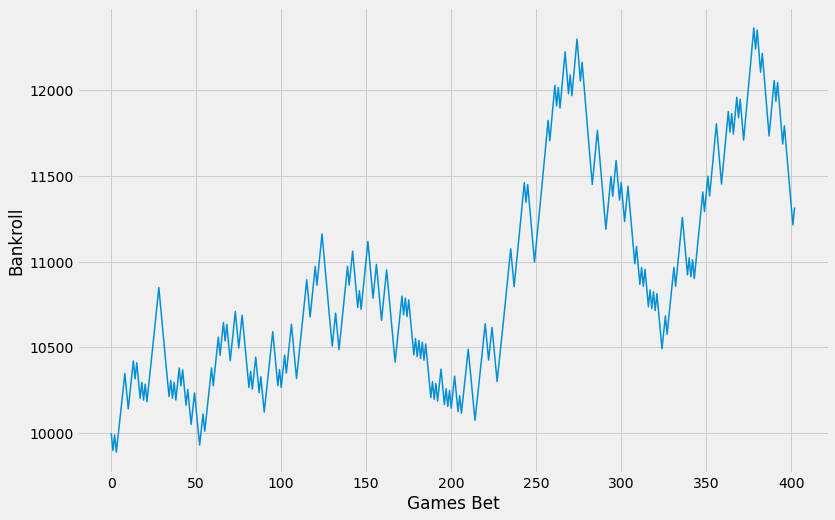

min balance: 9890.1 
max balance: 12361.590547072507 
final balance: 11418.527720980648 
win percentage 54.339999999999996


,index,GAME_DATE,home_team,away_team,spread,HOME_SCORE,AWAY_SCORE,point_diff,pred_home,pred_away,home_cover,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,18,2014-11-15,GSW,CHA,-11.5,112,87,25,109.369014,102.304958,1.0,7.064056,0,0,-4.435944,10000.000000,100.000000,9900.000000
1,20,2014-11-16,NYK,DEN,-2.0,109,93,16,107.208017,100.731620,1.0,6.476397,1,1,4.476397,9900.000000,99.000000,9990.000000
2,31,2014-11-17,POR,NOP,-3.5,102,93,9,105.860825,106.799814,1.0,-0.938989,0,0,-4.438989,9990.000000,99.900000,9890.100000
3,44,2014-11-19,TOR,MEM,-6.0,96,92,4,101.799706,100.017501,0.0,1.782205,0,1,-4.217795,9890.100000,98.901000,9980.010000
4,92,2014-11-26,DAL,NYK,-14.0,109,102,7,110.960142,101.314115,0.0,9.646027,0,1,-4.353973,9980.010000,99.800100,10070.737364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,5918,2019-02-04,BKN,MIL,7.5,94,113,-19,113.635635,116.627908,0.0,-2.992273,1,0,4.507727,11556.968765,115.569688,11441.399078
399,5927,2019-02-05,MEM,MIN,4.0,108,106,2,112.768332,121.392496,1.0,-8.624164,0,0,-4.624164,11441.399078,114.413991,11326.985087
400,5969,2019-02-11,CHI,MIL,11.5,99,112,-13,103.903978,110.992820,0.0,-7.088841,1,0,4.411159,11326.985087,113.269851,11213.715236
401,5988,2019-02-13,POR,GSW,2.0,129,107,22,109.064158,106.149370,1.0,2.914788,1,1,4.914788,11213.715236,112.137152,11315.658102


In [597]:
linear_svr = Pipeline(steps=[('scaler', StandardScaler()),
                ('svr',
                 LinearSVR(C=0.028059090359016606,
                           loss='squared_epsilon_insensitive',
                           max_iter=10000))])

linear_svr.fit(X_train, score_train)
svr_preds = best_svr.predict(X_test)

select_bets_svr, best_thresholds_svr = find_optimal_threshold(svr_preds, test_indices)
simulate_bets(select_bets_svr)

In [ ]:
# Save the Model to file
filename = "../models/svr_team_score_model.pkl"
with open(filename, 'wb') as file:
    pickle.dump(best_svr, file)
    
# Load the Model back from file
with open(filename, 'rb') as file:  
    best_svr = pickle.load(file)

best_svr

In [ ]:
select_bets_svr, best_thresholds_svr = find_optimal_threshold(svr_preds, test_indices)
simulate_bets(select_bets_svr)

### RFECV Linear SVC

### Random Forest

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   53.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   53.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


RandomForestRegressor(max_depth=24, max_features=0.74300937094178,
                      min_samples_leaf=0.01, min_samples_split=0.01)
best thresholds: (6, 8)
num_games_bet: 692
win percetange at threshold: 0.5317919075144508


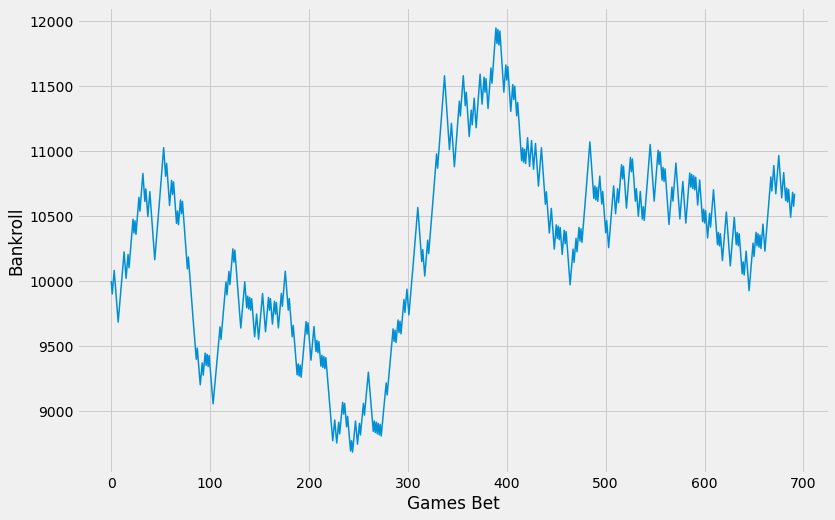

min balance: 8683.49312022547 
max balance: 11946.53310911688 
final balance: 10768.398152943962 
win percentage 53.18000000000001


,index,GAME_DATE,home_team,away_team,spread,HOME_SCORE,AWAY_SCORE,point_diff,pred_home,pred_away,home_cover,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,7,2015-11-07,SAS,CHA,-9.5,114,94,20,101.885857,98.725389,1.0,3.160468,0,0,-6.339532,10000.000000,100.000000,9900.000000
1,9,2015-11-07,SAC,GSW,14.0,94,103,-9,102.331922,109.257107,1.0,-6.925184,1,1,7.074816,9900.000000,99.000000,9990.000000
2,10,2015-11-07,UTA,MEM,-2.5,89,79,10,99.790103,90.490152,1.0,9.299952,1,1,6.799952,9990.000000,99.900000,10080.818182
3,15,2015-11-08,POR,DET,-2.0,103,120,-17,103.606390,95.567027,0.0,8.039363,1,0,6.039363,10080.818182,100.808182,9980.010000
4,16,2015-11-08,OKC,PHX,-8.5,124,103,21,106.910098,104.987760,1.0,1.922338,0,0,-6.577662,9980.010000,99.800100,9880.209900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,5956,2020-08-31,OKC,HOU,4.5,104,100,4,109.026591,106.608344,1.0,2.418247,1,1,6.918247,10490.464918,104.904649,10585.832781
688,5962,2020-09-03,BOS,TOR,2.5,103,104,-1,109.696034,105.334181,1.0,4.361853,1,1,6.861853,10585.832781,105.858328,10682.067625
689,5971,2020-09-08,HOU,LAL,4.5,102,112,-10,109.751471,106.700389,0.0,3.051082,1,0,7.551082,10682.067625,106.820676,10575.246948
690,5986,2020-09-22,DEN,LAL,6.0,114,106,8,106.746939,105.957619,1.0,0.789320,1,1,6.789320,10575.246948,105.752469,10671.385557


In [195]:
search_spaces = {'max_depth': Integer(2, 30),
              'min_samples_split': Real(0.01, 0.99),
                 'max_features':Real(0.1, 0.99),
                 'min_samples_leaf':Real(0.01, 0.5)
                }  

rf_bscv = BayesSearchCV(RandomForestRegressor(), search_spaces=search_spaces, n_iter=50, cv=tscv, verbose=1, n_jobs=-1)

rf_bscv.fit(X_train, score_train)


best_rf = rf_bscv.best_estimator_
print(best_rf)

best_rf.fit(X_train, score_train)

rf_preds = best_rf.predict(X_test)

select_bets_rf, best_thresholds_rf = find_optimal_threshold(rf_preds, test_indices)
simulate_bets(select_bets_rf)

In [63]:
best_rf = RandomForestRegressor(max_depth=17, max_features=0.6334551200752405,
                      min_samples_leaf=0.01, min_samples_split=0.01)
best_rf.fit(X_train, scores_train)

rf_preds = best_rf.predict(X_test)

In [94]:
best_rf.fit(features, scores)

RandomForestRegressor(max_depth=17, max_features=0.6334551200752405,
                      min_samples_leaf=0.01, min_samples_split=0.01)

In [95]:
# Save the Model to file
filename = "../models/rf_team_score_model.pkl"
with open(filename, 'wb') as file:
    pickle.dump(best_rf, file)
    


best thresholds: (4, 5)
num_games_bet: 575
win percetange at threshold: 0.5321739130434783


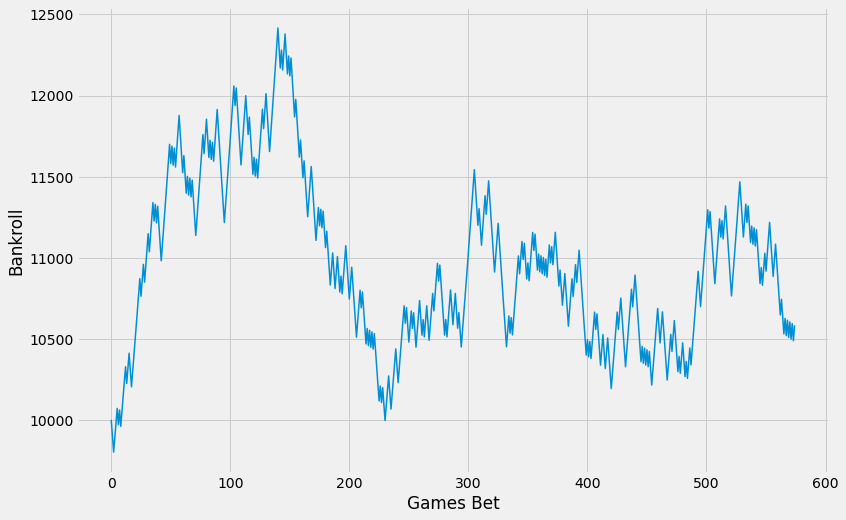

min balance: 9801.0 
max balance: 12416.827886793935 
final balance: 10679.162549581277 
win percentage 53.22


,index,GAME_DATE,home_team,away_team,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,point_diff,spread,home_cover,home_score_pred,away_score_pred,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,18112,2015-11-09,GSW,DET,109,95,14,-12.5,1.0,104.738545,96.966817,7.771728,0,0,-4.728272,10000.000000,100.000000,9900.000000
1,18120,2015-11-10,MIA,LAL,101,88,13,-11.0,1.0,103.895754,96.942360,6.953395,0,0,-4.046605,9900.000000,99.000000,9801.000000
2,18125,2015-11-11,HOU,BKN,98,106,-8,-11.5,0.0,107.792015,100.948626,6.843389,0,1,-4.656611,9801.000000,98.010000,9890.100000
3,18139,2015-11-13,NYK,CLE,84,90,-6,7.0,1.0,100.203467,102.643792,-2.440325,1,1,4.559675,9890.100000,98.901000,9980.010000
4,18148,2015-11-13,DEN,HOU,107,98,9,6.5,1.0,102.083858,103.836392,-1.752535,1,1,4.747465,9980.010000,99.800100,10070.737364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,24053,2020-09-03,LAC,DEN,120,97,23,-9.5,1.0,110.210411,105.375897,4.834515,0,0,-4.665485,10604.151577,106.041516,10498.110061
571,24056,2020-09-05,LAC,DEN,101,110,-9,-9.0,0.0,110.460376,105.463654,4.996722,0,1,-4.003278,10498.110061,104.981101,10593.547425
572,24074,2020-09-18,LAL,DEN,126,114,12,-7.5,1.0,106.956299,104.343853,2.612445,0,0,-4.887555,10593.547425,105.935474,10487.611951
573,24076,2020-09-20,LAL,DEN,105,103,2,-7.5,0.0,107.963541,104.892835,3.070707,0,1,-4.429293,10487.611951,104.876120,10582.953878


In [175]:
select_bets_rf, best_thresholds_rf = find_optimal_threshold(rf_preds, test_indices)
simulate_bets(select_bets_rf)

In [176]:
best_thresholds_rf

,index,confidence_range,num_games_bet,win_percentage
0,14,"(4, 5)",575,0.532174
1,65,"(10, 11)",120,0.533333
2,134,"(14, 16)",28,0.535714
3,135,"(15, 16)",11,0.545455


### XGB

In [200]:
score_train.isnull().sum()

0

In [481]:
xgb.XGBRegressor().get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [482]:
search_spaces = {'min_child_weight':Integer(1,8),
              'gamma': Real(0.5, 3),
              'subsample': Real(0.6, 1),
              'colsample_bytree': Real(0.5, 1),
              'max_depth': Integer(3, 30),
              'reg_lambda': Integer(1, 10),
              'reg_alpha': Integer(0, 10)}
    
    
xgb_bs = BayesSearchCV(xgb.XGBRegressor(), search_spaces=search_spaces, cv=tscv, verbose=1, n_jobs=-1)

xgb_bs.fit(X_train, score_train)

print(xgb_bs.best_estimator_)

best_xgb = xgb_bs.best_estimator_
xgb_preds = best_xgb.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   51.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.2s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.0s finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=8, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=10, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [489]:
xgb_bs.best_params_

OrderedDict([('colsample_bytree', 0.5),
             ('gamma', 0.5),
             ('max_depth', 3),
             ('min_child_weight', 8),
             ('reg_alpha', 10),
             ('reg_lambda', 10),
             ('subsample', 1.0)])

In [490]:
best_xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=8, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=10, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

best thresholds: (16, 19)
num_games_bet: 332
win percetange at threshold: 0.5331325301204819


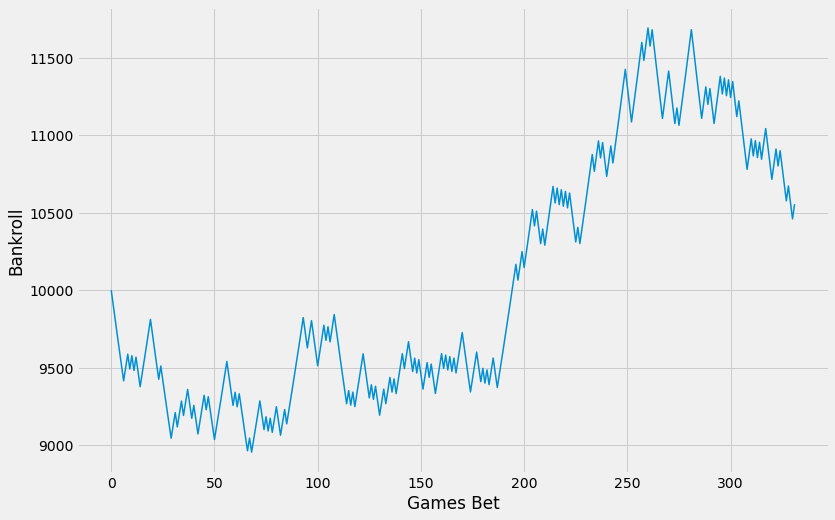

min balance: 8954.600263505668 
max balance: 11693.377082777706 
final balance: 10450.020318121657 
win percentage 53.31


,index,GAME_DATE,home_team,away_team,spread,HOME_SCORE,AWAY_SCORE,point_diff,pred_home,pred_away,home_cover,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,40,2014-11-19,PHI,BOS,6.5,90,101,-11,105.506287,93.926582,0.0,11.579704,1,0,18.079704,10000.000000,100.000000,9900.000000
1,51,2014-11-21,PHI,PHX,9.0,96,122,-26,105.601410,98.596268,0.0,7.005142,1,0,16.005142,9900.000000,99.000000,9801.000000
2,58,2014-11-21,DAL,LAL,-11.0,140,106,34,99.151146,104.618317,1.0,-5.467171,0,0,-16.467171,9801.000000,98.010000,9702.990000
3,60,2014-11-21,GSW,UTA,-12.5,101,88,13,103.319290,108.096565,1.0,-4.777275,0,0,-17.277275,9702.990000,97.029900,9605.960100
4,63,2014-11-22,ORL,MIA,1.5,92,99,-7,105.900368,88.518478,0.0,17.381889,1,0,18.881889,9605.960100,96.059601,9509.900499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,5949,2019-02-08,NOP,MIN,-6.0,122,117,5,100.841667,112.116737,0.0,-11.275070,0,1,-17.275070,10576.718940,105.767189,10672.870930
328,5951,2019-02-09,UTA,SAS,-8.0,125,105,20,98.685509,107.668968,1.0,-8.983459,0,0,-16.983459,10672.870930,106.728709,10566.142221
329,5982,2019-02-13,NYK,PHI,10.0,111,126,-15,99.628204,92.247307,0.0,7.380898,1,0,17.380898,10566.142221,105.661422,10460.480799
330,5983,2019-02-13,TOR,WAS,-9.5,129,120,9,92.208603,101.173759,0.0,-8.965157,0,1,-18.465157,10460.480799,104.604808,10555.576079


In [484]:
select_bets_xgb, best_thresholds_xgb = find_optimal_threshold(xgb_preds, test_indices)
simulate_bets(select_bets_xgb)

In [97]:

best_xgb.fit(features, scores)

NameError: name 'nan' is not defined

In [183]:
# Save the Model to file
filename = "../models/xgb_team_score_model.pkl"
with open(filename, 'wb') as file:
    pickle.dump(best_xgb, file)
    
# Load the Model back from file
with open(filename, 'rb') as file:  
    best_xgb = pickle.load(file)

best_xgb

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5, gamma=0.5,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=3,
                                            min_child_weight=6, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, reg_alpha=10,
                                            reg_

best thresholds: (11, 13)
num_games_bet: 236
win percetange at threshold: 0.5338983050847458


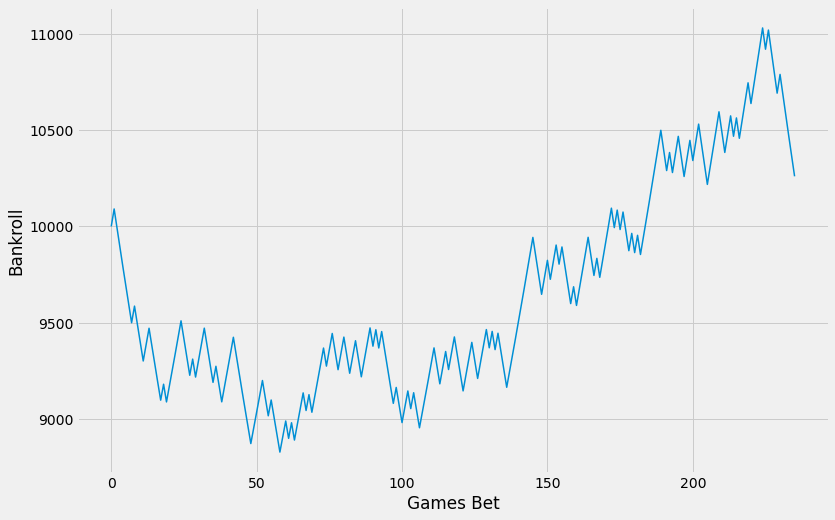

min balance: 8829.246937636215 
max balance: 11030.133546256506 
final balance: 10353.528967276114 
win percentage 53.39


,index,GAME_DATE,home_team,away_team,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,point_diff,spread,home_cover,home_score_pred,away_score_pred,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,18148,2015-11-13,DEN,HOU,107,98,9,6.5,1.0,107.867104,102.802269,5.064835,1,1,11.564835,10000.000000,100.000000,10090.909091
1,18190,2015-11-20,DEN,PHX,107,114,-7,3.0,0.0,107.781609,99.109589,8.672020,1,0,11.672020,10090.909091,100.909091,9990.000000
2,18262,2015-11-29,TOR,PHX,102,107,-5,-3.0,0.0,112.053307,97.325027,14.728279,1,0,11.728279,9990.000000,99.900000,9890.100000
3,18268,2015-11-30,MIL,DEN,92,74,18,-4.0,1.0,93.772675,100.842636,-7.069962,0,0,-11.069962,9890.100000,98.901000,9791.199000
4,18343,2015-12-10,BKN,PHI,100,91,9,-7.0,1.0,90.809036,96.231415,-5.422379,0,0,-12.422379,9791.199000,97.911990,9693.287010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,24009,2020-08-17,BOS,PHI,109,101,8,-6.5,1.0,98.999809,103.738457,-4.738647,0,0,-11.238647,10681.133197,106.811332,10574.321865
232,24015,2020-08-19,BOS,PHI,128,101,27,-4.5,1.0,96.721703,103.466515,-6.744812,0,0,-11.244812,10574.321865,105.743219,10468.578647
233,24028,2020-08-22,ORL,MIL,107,121,-14,12.5,0.0,113.059914,114.500946,-1.441032,1,0,11.058968,10468.578647,104.685786,10363.892860
234,24039,2020-08-25,LAC,DAL,154,111,43,-8.5,1.0,106.753502,110.046539,-3.293037,0,0,-11.793037,10363.892860,103.638929,10260.253932


In [181]:
select_bets_xgb, best_thresholds_xgb = find_optimal_threshold(xgb_preds, test_indices)
simulate_bets(select_bets_xgb)

### ADABoost

In [201]:
ada = AdaBoostRegressor()

search_spaces = {'learning_rate': Real(0.01,1, prior='log-uniform'),
                'loss': Categorical(['linear', 'square', 'exponential']), 
                'n_estimators': Integer(50, 500)}

ada_gs = BayesSearchCV(ada, search_spaces=search_spaces, n_iter=50, cv=tscv, n_jobs=-1, verbose=1)
ada_gs.fit(X_train, score_train)


best_ada = ada_gs.best_estimator_
print(ada_gs.best_params_)
print(best_ada)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   53.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.2min finished


OrderedDict([('learning_rate', 0.02978413312793186), ('loss', 'exponential'), ('n_estimators', 500)])
AdaBoostRegressor(learning_rate=0.02978413312793186, loss='exponential',
                  n_estimators=500)


    spread_threshold  win_percentage  number_bets  estimated_profit
0                  0             NaN            0                 0
1                  1        0.444444           18              -280
2                  2        0.483685          521             -3852
3                  3        0.498311         1184             -5152
4                  4        0.500280         1785             -7036
5                  5        0.491060         2405            -14092
6                  6        0.493662         2998            -15944
7                  7        0.496085         3576            -17216
8                  8        0.499261         4058            -16856
9                  9        0.495493         4438            -21912
10                10        0.495620         4794            -23544
11                11        0.497925         5061            -22428
12                12        0.498867         5296            -22432
13                13        0.498626         545

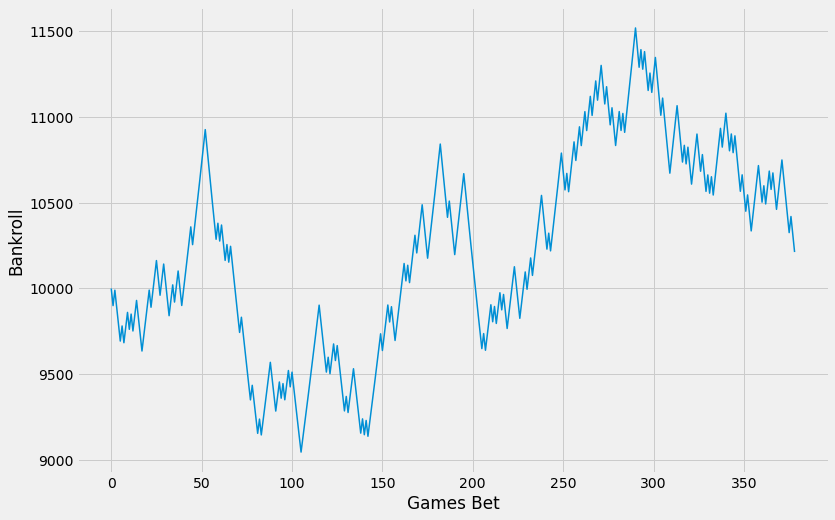

min balance: 9045.870878242558 
max balance: 11519.198926569561 
final balance: 10305.134339245005 
win percentage 53.03


,index,GAME_DATE,home_team,away_team,spread,HOME_SCORE,AWAY_SCORE,point_diff,pred_home,pred_away,home_cover,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,2,2015-11-06,SAC,HOU,4.5,110,116,-6,111.117014,105.098627,0.0,6.018388,1,0,10.518388,10000.000000,100.000000,9900.000000
1,3,2015-11-06,GSW,DEN,-17.5,119,104,15,107.263205,99.135157,0.0,8.128049,0,1,-9.371951,9900.000000,99.000000,9990.000000
2,21,2015-11-09,GSW,DET,-12.5,109,95,14,103.112764,99.689143,1.0,3.423621,0,0,-9.076379,9990.000000,99.900000,9890.100000
3,160,2015-11-28,GSW,SAC,-16.5,120,101,19,110.338639,104.534804,1.0,5.803836,0,0,-10.696164,9890.100000,98.901000,9791.199000
4,196,2015-12-02,CHA,GSW,9.0,99,116,-17,105.000000,104.983698,0.0,0.016302,1,0,9.016302,9791.199000,97.911990,9693.287010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,5943,2020-08-24,ORL,MIL,13.0,106,121,-15,111.013256,113.842818,0.0,-2.829562,1,0,10.170438,10430.076328,104.300763,10325.775565
375,5950,2020-08-29,LAL,POR,-14.0,131,122,9,114.951772,111.531754,0.0,3.420018,0,1,-10.579982,10325.775565,103.257756,10419.646252
376,5953,2020-08-30,DAL,LAC,9.5,97,111,-14,114.252153,113.510838,0.0,0.741314,1,0,10.241314,10419.646252,104.196463,10315.449789
377,5961,2020-09-03,LAC,DEN,-9.5,120,97,23,111.013256,113.495060,1.0,-2.481804,0,0,-11.981804,10315.449789,103.154498,10212.295291


In [211]:
ada_preds = best_ada.predict(X_test)
print(find_optimal_spreads(ada_preds, test_indices))
select_bets_ada, best_thresholds_ada= find_optimal_threshold(ada_preds, test_indices)
simulate_bets(select_bets_ada)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 23.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   53.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.6min finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.9s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.0s finished


OrderedDict([('learning_rate', 0.12645966693687635), ('loss', 'exponential'), ('n_estimators', 50)])
AdaBoostRegressor(base_estimator=Lasso(), learning_rate=0.12645966693687635,
                  loss='exponential')
best thresholds: (7, 19)
num_games_bet: 305
win percetange at threshold: 0.5377049180327869


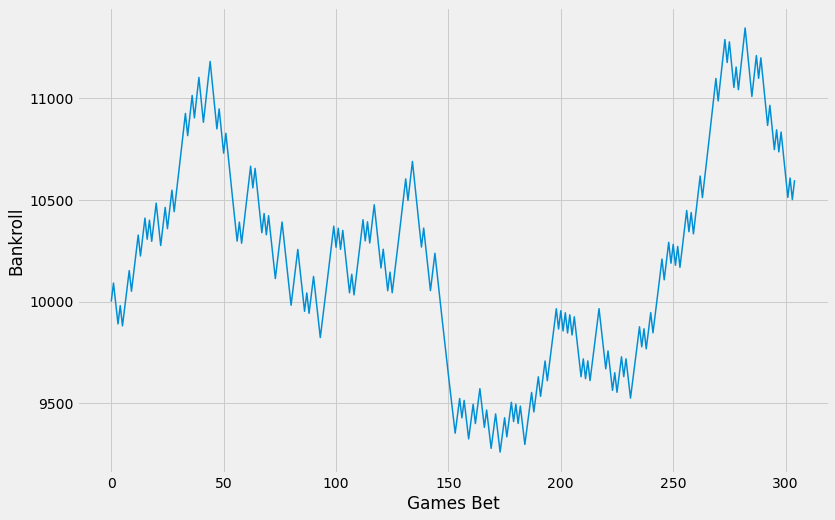

min balance: 9258.961560043826 
max balance: 11346.586447714079 
final balance: 10693.76394742357 
win percentage 53.769999999999996


,index,GAME_DATE,home_team,away_team,spread,HOME_SCORE,AWAY_SCORE,point_diff,pred_home,pred_away,home_cover,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,39,2015-11-11,ATL,NOP,-13.0,106,98,8,111.830797,106.546393,0.0,5.284403,0,1,-7.715597,10000.000000,100.000000,10090.909091
1,218,2015-12-05,MIA,CLE,-5.0,99,84,15,97.766586,100.800941,1.0,-3.034355,0,0,-8.034355,10090.909091,100.909091,9990.000000
2,323,2015-12-19,NYK,CHI,-2.5,107,91,16,101.275644,106.203952,1.0,-4.928308,0,0,-7.428308,9990.000000,99.900000,9890.100000
3,336,2015-12-21,ATL,POR,-11.0,106,97,9,103.537120,100.804845,0.0,2.732275,0,1,-8.267725,9890.100000,98.901000,9980.010000
4,345,2015-12-23,NOP,POR,-7.5,115,89,26,103.459060,103.803383,1.0,-0.344323,0,0,-7.844323,9980.010000,99.800100,9880.209900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,5943,2020-08-24,ORL,MIL,13.0,106,121,-15,114.321486,120.229806,0.0,-5.908321,1,0,7.091679,10618.650414,106.186504,10512.463910
301,5950,2020-08-29,LAL,POR,-14.0,131,122,9,118.112667,112.846284,0.0,5.266382,0,1,-8.733618,10512.463910,105.124639,10608.031763
302,5972,2020-09-08,MIL,MIA,5.5,94,103,-9,111.880184,109.714385,0.0,2.165799,1,0,7.665799,10608.031763,106.080318,10501.951446
303,5993,2020-10-02,LAL,MIA,-11.0,124,114,10,112.010559,108.200753,0.0,3.809806,0,1,-7.190194,10501.951446,105.019514,10597.423732


In [205]:
ada_lasso = AdaBoostRegressor(Lasso())
search_spaces = {'learning_rate': Real(0.01,1, prior='log-uniform'),
                'loss': Categorical(['linear', 'square', 'exponential']), 
                'n_estimators': Integer(50, 500)}

ada_lasso_gs = BayesSearchCV(ada_lasso, search_spaces=search_spaces, n_iter=50, cv=tscv, n_jobs=-1, verbose=1)
ada_lasso_gs.fit(X_train, score_train)

best_ada_lasso = ada_lasso_gs.best_estimator_
print(ada_lasso_gs.best_params_)
print(best_ada_lasso)

ada_lasso_preds = best_ada_lasso.predict(X_test)
select_bets_ada, best_thresholds_ada= find_optimal_threshold(ada_lasso_preds, test_indices)
simulate_bets(select_bets_ada)

best thresholds: (7, 19)
num_games_bet: 305
win percetange at threshold: 0.5377049180327869


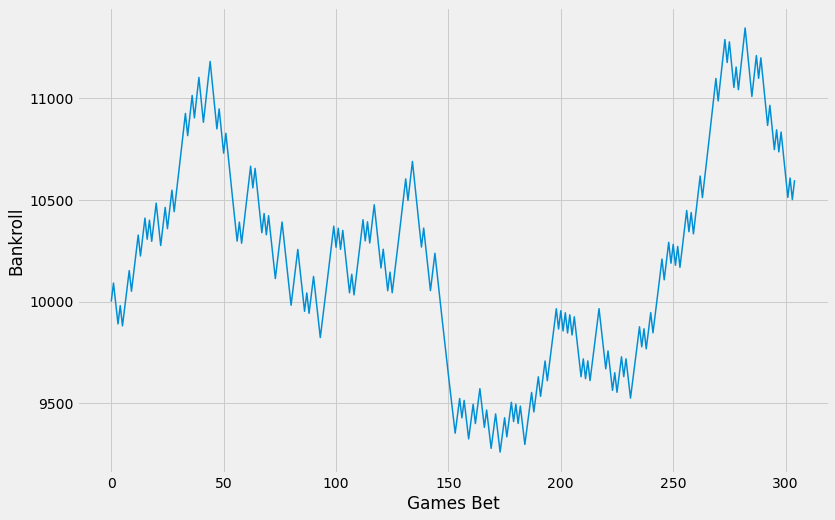

min balance: 9258.961560043826 
max balance: 11346.586447714079 
final balance: 10693.76394742357 
win percentage 53.769999999999996


,index,GAME_DATE,home_team,away_team,spread,HOME_SCORE,AWAY_SCORE,point_diff,pred_home,pred_away,home_cover,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,39,2015-11-11,ATL,NOP,-13.0,106,98,8,111.830797,106.546393,0.0,5.284403,0,1,-7.715597,10000.000000,100.000000,10090.909091
1,218,2015-12-05,MIA,CLE,-5.0,99,84,15,97.766586,100.800941,1.0,-3.034355,0,0,-8.034355,10090.909091,100.909091,9990.000000
2,323,2015-12-19,NYK,CHI,-2.5,107,91,16,101.275644,106.203952,1.0,-4.928308,0,0,-7.428308,9990.000000,99.900000,9890.100000
3,336,2015-12-21,ATL,POR,-11.0,106,97,9,103.537120,100.804845,0.0,2.732275,0,1,-8.267725,9890.100000,98.901000,9980.010000
4,345,2015-12-23,NOP,POR,-7.5,115,89,26,103.459060,103.803383,1.0,-0.344323,0,0,-7.844323,9980.010000,99.800100,9880.209900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,5943,2020-08-24,ORL,MIL,13.0,106,121,-15,114.321486,120.229806,0.0,-5.908321,1,0,7.091679,10618.650414,106.186504,10512.463910
301,5950,2020-08-29,LAL,POR,-14.0,131,122,9,118.112667,112.846284,0.0,5.266382,0,1,-8.733618,10512.463910,105.124639,10608.031763
302,5972,2020-09-08,MIL,MIA,5.5,94,103,-9,111.880184,109.714385,0.0,2.165799,1,0,7.665799,10608.031763,106.080318,10501.951446
303,5993,2020-10-02,LAL,MIA,-11.0,124,114,10,112.010559,108.200753,0.0,3.809806,0,1,-7.190194,10501.951446,105.019514,10597.423732


In [207]:
ada_lasso_preds = best_ada_lasso.predict(X_test)
select_bets_ada_lasso, best_thresholds_ada_lasso= find_optimal_threshold(ada_lasso_preds, test_indices)
simulate_bets(select_bets_ada_lasso)


In [210]:
find_optimal_spreads(ada_lasso_preds, test_indices)


,spread_threshold,win_percentage,number_bets,estimated_profit
0,0,NaN,0,0
1,1,0.388889,18,-488
2,2,0.470250,521,-5308
3,3,0.489865,1184,-7232
4,4,0.499720,1785,-7244
5,5,0.498545,2405,-10348
6,6,0.497332,2998,-13656
7,7,0.500839,3576,-13680
8,8,0.502957,4058,-13736
9,9,0.500676,4438,-17128


In [219]:
tuned_ada = AdaBoostRegressor(learning_rate=0.029784, loss='exponential', n_estimators=500)
tuned_ada.fit(X_train, score_train)

AdaBoostRegressor(learning_rate=0.029784, loss='exponential', n_estimators=500)

In [432]:
lgbr.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

### Light GB

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.4s finished


[LightGBM] [Warning] feature_fraction is set=0.19964747249541806, colsample_bytree=0.6354796756949583 will be ignored. Current value: feature_fraction=0.19964747249541806
[LightGBM] [Warning] num_leaves is set=31, num_leaf=1 will be ignored. Current value: num_leaves=31
best thresholds: (9, 10)
num_games_bet: 47
win percetange at threshold: 0.5531914893617021


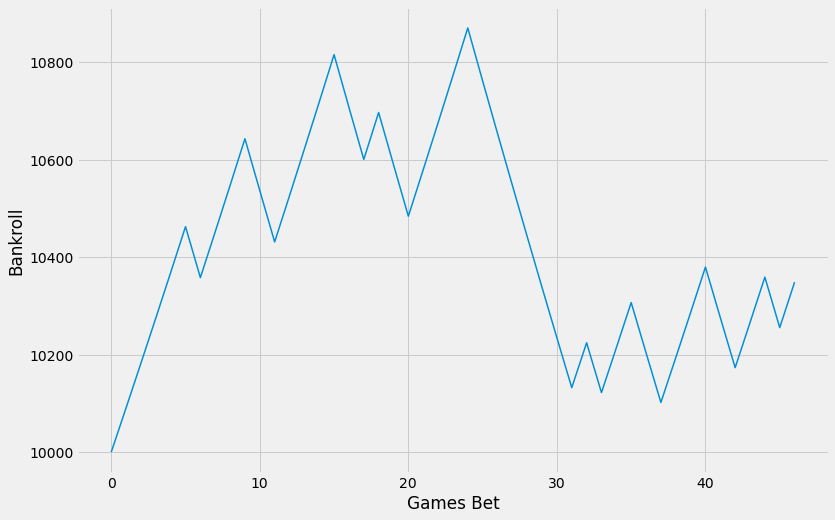

min balance: 10090.90909090909 
max balance: 10870.796199319331 
final balance: 10245.348150455444 
win percentage 55.32


,index,GAME_DATE,home_team,away_team,spread,HOME_SCORE,AWAY_SCORE,point_diff,pred_home,pred_away,home_cover,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,836,2016-03-04,MEM,UTA,1.5,94,88,6,107.802136,99.820012,1.0,7.982124,1,1,9.482124,10000.000000,100.000000,10090.909091
1,890,2016-03-11,MEM,NOP,3.0,121,114,7,110.391475,103.637397,1.0,6.754078,1,1,9.754078,10090.909091,100.909091,10182.644628
2,1018,2016-03-28,NOP,NYK,5.5,99,91,8,106.394728,102.663635,1.0,3.731093,1,1,9.231093,10182.644628,101.826446,10275.214125
3,1044,2016-03-31,OKC,LAC,-17.0,119,117,2,108.781405,100.923557,0.0,7.857848,0,1,-9.142152,10275.214125,102.752141,10368.625162
4,1045,2016-03-31,NOP,DEN,7.0,101,95,6,105.573065,103.526436,1.0,2.046628,1,1,9.046628,10368.625162,103.686252,10462.885391
5,1048,2016-03-31,CLE,BKN,-17.0,107,87,20,106.516484,98.691461,1.0,7.825022,0,0,-9.174978,10462.885391,104.628854,10358.256537
6,1134,2016-04-12,SAS,OKC,-13.0,102,98,4,103.307954,99.493838,0.0,3.814117,0,1,-9.185883,10358.256537,103.582565,10452.422506
7,1470,2016-12-05,ATL,OKC,-4.0,99,102,-3,102.578752,108.302385,0.0,-5.723633,0,1,-9.723633,10452.422506,104.524225,10547.444528
8,1489,2016-12-08,UTA,GSW,11.5,99,106,-7,106.203889,108.073323,1.0,-1.869434,1,1,9.630566,10547.444528,105.474445,10643.330388
9,1786,2017-01-18,GSW,OKC,-15.0,121,100,21,116.662147,111.296695,1.0,5.365453,0,0,-9.634547,10643.330388,106.433304,10536.897084


In [441]:
lgbr = lgb.LGBMRegressor()

search_spaces = {'min_child_weight':Integer(1,8),
              'subsample': Real(0.6, 1),
              'colsample_bytree': Real(0.5, 1),
              'max_depth': Integer(3, 30),
              'reg_lambda': Integer(1, 10),
              'reg_alpha': Integer(0, 10),
                'boosting_type':Categorical(['gbdt'], transform='string'),
                'num_leaf':Integer(1, 2048),
                'feature_fraction':Real(0.01, 1)}
    
    
lgbr_bs = BayesSearchCV(lgb.LGBMRegressor(objective='regression', subsample_freq=1), search_spaces=search_spaces, cv=tscv, verbose=1, n_jobs=-1)

lgbr_bs.fit(X_train, score_train)

best_lgbr = lgbr_bs.best_estimator_


lgbr_preds = best_lgbr.predict(X_test)

print("score:", best_lgbr.score(X_test, score_test))
print("best_lgbr:", best_lgbr)
print("mae", mean_absolute_error(score_test, lgbr_preds))




In [444]:
print(best_lgbr)

LGBMRegressor(colsample_bytree=0.6354796756949583,
              feature_fraction=0.19964747249541806, max_depth=3,
              min_child_weight=6, num_leaf=1, objective='regression',
              reg_alpha=10, reg_lambda=1, subsample=0.9096298377921476,
              subsample_freq=1)


In [442]:
select_bets_lgb, best_thresholds_lgb = find_optimal_threshold(lgbr_preds, test_indices)
simulate_bets(select_bets_lgb)
best_thresholds_lgb

,index,confidence_range,num_games_bet,win_percentage
0,54,"(9, 10)",47,0.553191
1,103,"(12, 14)",18,0.555556
2,104,"(13, 14)",4,0.750000


### Stacking Regressor

best thresholds: (14, 15)
num_games_bet: 180
win percetange at threshold: 0.5333333333333333


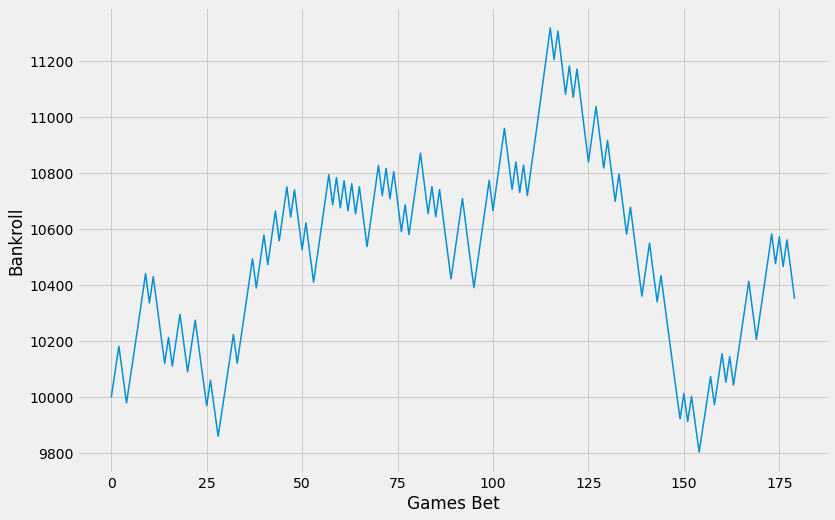

min balance: 9804.555076648508 
max balance: 11319.285493797563 
final balance: 10248.5997983292 
win percentage 53.33


,index,GAME_DATE,home_team,away_team,spread,HOME_SCORE,AWAY_SCORE,point_diff,pred_home,pred_away,home_cover,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,10,2014-11-15,WAS,ORL,-9.0,98,93,5,95.293902,100.376161,0.0,-5.082258,0,1,-14.082258,10000.000000,100.000000,10090.909091
1,22,2014-11-16,OKC,HOU,5.0,65,69,-4,107.489232,97.966594,1.0,9.522638,1,1,14.522638,10090.909091,100.909091,10182.644628
2,53,2014-11-21,TOR,MIL,-9.0,124,82,42,100.339178,105.622954,1.0,-5.283776,0,0,-14.283776,10182.644628,101.826446,10080.818182
3,58,2014-11-21,DAL,LAL,-11.0,140,106,34,99.491394,103.445517,1.0,-3.954123,0,0,-14.954123,10080.818182,100.808182,9980.010000
4,207,2014-12-12,WAS,LAC,2.5,104,96,8,105.414673,93.109821,1.0,12.304852,1,1,14.804852,9980.010000,99.800100,10070.737364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,5780,2019-01-15,MIL,MIA,-9.0,124,86,38,103.984305,109.347176,1.0,-5.362871,0,0,-14.362871,10572.883881,105.728839,10467.155042
176,5880,2019-01-29,SAS,PHX,-13.5,126,124,2,111.700702,112.241558,0.0,-0.540856,0,1,-14.040856,10467.155042,104.671550,10562.310997
177,5882,2019-01-30,BOS,CHA,-7.5,126,94,32,108.724791,115.346915,1.0,-6.622123,0,0,-14.122123,10562.310997,105.623110,10456.687887
178,5952,2019-02-09,IND,CLE,-14.0,105,90,15,117.411715,117.949655,1.0,-0.537940,0,0,-14.537940,10456.687887,104.566879,10352.121008


In [510]:
tuned_linear_svr = Pipeline(steps=[('scaler', StandardScaler()),
                ('svr', LinearSVR(C=0.028059090359016606,
                        loss='squared_epsilon_insensitive',
                        max_iter=10000))])

tuned_ada = AdaBoostRegressor(learning_rate=0.029784, loss='exponential', n_estimators=500)


tuned_rf = RandomForestRegressor(max_depth=24, max_features=0.74300937094178,
                      min_samples_leaf=0.01, min_samples_split=0.01)

# lr_pipeline = Pipeline([('scaler', StandardScaler()),
#                     ('linreg', LinearRegression())])

en_pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.1, l1_ratio=0.05, max_iter=5000))])

lgbr = lgb.LGBMRegressor(colsample_bytree=0.6354796756949583,
              feature_fraction=0.19964747249541806, max_depth=3,
              min_child_weight=6, num_leaf=1, objective='regression',
              reg_alpha=10, reg_lambda=1, subsample=0.9096298377921476,
              subsample_freq=1)

xgbr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.5, gpu_id=-1,
             importance_type='gain', learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=8, n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=10, subsample=1.0)

rr_pipeline = Pipeline([('scaler', StandardScaler()),
                          ('ridge', Ridge(alpha=348))])


estimators = [('svr', tuned_linear_svr), ('en', en_pipeline), ('ada',tuned_ada), ('rf', tuned_rf), ('lgrb', lgbr), ('xgbr', xgbr), ('rr', rr_pipeline)]

stacked_clf = StackingRegressor(estimators=estimators, final_estimator = LinearRegression(), verbose=2, n_jobs=-1)

stacked_clf.fit(X_train, score_train)

stacked_preds = stacked_clf.predict(X_test)

select_bets_stacked, best_thresholds_stacked= find_optimal_threshold(stacked_preds, test_indices)
simulate_bets(select_bets_stacked)

In [540]:
bets_stacked = bet_selector(stacked_preds, test_indices, 0, 30)
bets_stacked['home_won'] = (bets_stacked['HOME_SCORE'] - bets_stacked['AWAY_SCORE'] > 0).astype(int)
bets_stacked['home_win_pred'] = (bets_stacked['pred_home'] - bets_stacked['pred_away'] > 0).astype(int)
bets_stacked['win_pred_correct'] = (bets_stacked['home_won'] == bets_stacked['home_win_pred']).astype(int)
bets_stacked['win_pred_correct'].mean()

0.6597938144329897

In [ ]:
# y = range(14)
# cv = TimeSeriesSplit(5).split(features)
print(next(cv))

In [ ]:
tuned_linear_svr = Pipeline(steps=[('scaler', StandardScaler()),
                ('svr', LinearSVR(C=0.028059090359016606,
                        loss='squared_epsilon_insensitive',
                        max_iter=10000))])

tuned_ada = AdaBoostRegressor(learning_rate=0.029784, loss='exponential', n_estimators=500)


tuned_rf = RandomForestRegressor(max_depth=24, max_features=0.74300937094178,
                      min_samples_leaf=0.01, min_samples_split=0.01)

# lr_pipeline = Pipeline([('scaler', StandardScaler()),
#                     ('linreg', LinearRegression())])

en_pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.1, l1_ratio=0.05, max_iter=5000))])

lgbr = lgb.LGBMRegressor(colsample_bytree=0.6354796756949583,
              feature_fraction=0.19964747249541806, max_depth=3,
              min_child_weight=6, num_leaf=1, objective='regression',
              reg_alpha=10, reg_lambda=1, subsample=0.9096298377921476,
              subsample_freq=1)

xgbr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.5, gpu_id=-1,
             importance_type='gain', learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=8, n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=10, subsample=1.0)

rr_pipeline = Pipeline([('scaler', StandardScaler()),
                          ('ridge', Ridge(alpha=348))])


estimators = [('svr', tuned_linear_svr), ('en', en_pipeline), ('ada',tuned_ada), 
              ('rf', tuned_rf), ('lgrb', lgbr), ('xgbr', xgbr), ('rr', rr_pipeline)]

stacked_clf = StackingRegressor(estimators=estimators, final_estimator = LinearRegression(), verbose=2, n_jobs=-1)

stacked_clf.fit(features, score)


In [ ]:
with open("../models/stacked_regressor.pkl", 'wb') as file:
    pickle.dump(stacked_clv, "../models/stacked_regressor.pkl")
    


In [ ]:
loaded_stacked_model = pickle.load(open("../models/stacked_regressor.pkl", 'rb')


### Test on 2020-21 Season

In [ ]:
df = load_current_season_data()

df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = avg_data_for_model(df1)
df1 = add_percentage_features(df1)

home_df = df.loc[df['TEAM_ABBREVIATION'] == home].sort_values('GAME_DATE').reset_index(drop=True)
home_df.iloc[-1, 8] = 1
home_df['rest'] = (datetime.today() - home_df.iloc[-1, 6]) // np.timedelta64(1, 'D')

away_df = df.loc[df['TEAM_ABBREVIATION'] == away].sort_values('GAME_DATE').reset_index(drop=True)
away_df.iloc[-1, 8] = 0
away_df['rest'] = (datetime.today() - away_df.iloc[-1, 6]) // np.timedelta64(1, 'D')


home_cols = [col + '_x' for col in home_df.columns]
away_cols = [col + '_y' for col in away_df.columns]    
home_cols.extend(away_cols)

home_last = home_df.iloc[-1].values.reshape(1, -1)
away_last = away_df.iloc[-1].values.reshape(1, -1)
home_matchup = np.concatenate([home_last, away_last], axis=1)
away_matchup = np.concatenate([away_last, home_last], axis=1)

matchup_rows = np.concatenate([home_matchup, away_matchup], axis=0)

df_rows = pd.DataFrame(matchup_rows, columns = home_cols)
df_rows.rename(columns={'HOME_GAME_x':'HOME_GAME'}, inplace=True)
    
    # Add ELO Rating
#     print(home)
#     print(elo_ratings_dic[home])
df_rows['team_rating_i'] = [elo_ratings_dic[home], elo_ratings_dic[away]]
df_rows['opp_rating_i'] = [elo_ratings_dic[away], elo_ratings_dic[home]]
df_rows['team_elo_pred'] = df_rows.apply(lambda row: elo_prediction(row['team_rating_i'], row['opp_rating_i']), axis=1)
df_rows['elo_MOV_pred'] =  df_rows.apply(lambda row: ((row['team_rating_i']+100) 
                                                      - row['opp_rating_i'])/28 if row['HOME_GAME'] == 1 else (row['team_rating_i']
                                                                                                                          - (row['opp_rating_i']+100))/28, axis=1)


In [359]:
update_all_data(season='2020-21')

updating basic team boxscores
updating basic player boxscores
updating advanced boxscores


progress:   0%|                                                                                  | 0/4 [00:00<?, ?it/s]

Updating 4 Games


progress:   0%|                                                                                  | 0/4 [00:00<?, ?it/s]

updating scoring boxscores
Updating 4 Games


progress:   0%|                                                                                  | 0/2 [00:00<?, ?it/s]

updating tracking boxscores
Updating 2 Games


progress: 100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.16s/it]


## Using Model

In [579]:
from src.data.update_data import update_all_data
from src.data.update_data import update_moneyline_data
from src.data.update_data import update_spread_data

update_all_data(season='2020-21')
update_spread_data(season='2020-21')
update_moneyline_data(season='2020-21')

updating basic team boxscores
updating basic player boxscores
updating advanced boxscores


progress:   0%|                                                                                  | 0/7 [00:00<?, ?it/s]

Updating 7 Games


progress: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:16<00:00,  2.33s/it]


updating scoring boxscores


progress:   0%|                                                                                  | 0/7 [00:00<?, ?it/s]

Updating 7 Games


progress:   0%|                                                                                  | 0/7 [00:00<?, ?it/s]

updating tracking boxscores
Updating 7 Games


progress:   0%|                                                                                  | 0/1 [00:00<?, ?it/s]

Updating lines for 1 days


progress:   0%|                                                                                  | 0/1 [00:00<?, ?it/s]

Updating lines for 1 days


progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.72s/it]


In [56]:
def load_current_season_team_data(season):
    """Loads basic, advanced, and scoring boxscores from
    current season and merges them into one dataframe
    """
    basic_gls = pd.read_csv('../data/current_season_data/team_gamelogs_{}.csv'.format(season))

    adv_gls = pd.read_csv('../data/current_season_data/team_advanced_boxscores_{}.csv'.format(season))

    scoring_gls = pd.read_csv('../data/current_season_data/team_scoring_boxscores_{}.csv'.format(season))
    temp = pd.merge(basic_gls, adv_gls, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])
    full_df = pd.merge(temp, scoring_gls, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])
    full_df = full_df.drop(columns = ['VIDEO_AVAILABLE', 'TEAM_ID_y', 
                                      'TEAM_NAME_y', 'TEAM_CITY', 
                                      'MIN_y', 'TEAM_ID_y',
                                      'TEAM_NAME_y', 'TEAM_CITY_y',
                                      'MIN_y'], errors='ignore')
    
    full_df['SEASON_YEAR'] = season
    
    full_df = full_df[['SEASON_YEAR', 'SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'E_OFF_RATING',
       'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING',
       'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT',
       'REB_PCT', 'E_TM_TOV_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT',
       'E_USG_PCT', 'E_PACE', 'PACE', 'PACE_PER40', 'POSS', 'PIE',
       'PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_2PT', 'PCT_PTS_2PT_MR',
       'PCT_PTS_3PT', 'PCT_PTS_FB', 'PCT_PTS_FT', 'PCT_PTS_OFF_TOV',
       'PCT_PTS_PAINT', 'PCT_AST_2PM', 'PCT_UAST_2PM', 'PCT_AST_3PM',
       'PCT_UAST_3PM', 'PCT_AST_FGM', 'PCT_UAST_FGM']]
    
    full_df = full_df.dropna()
    
    return full_df

df = load_current_season_team_data(season='2020-21')
df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM
0,2020-21,22020,1610612747,LAL,Los Angeles Lakers,22000002,2020-12-22,LAL vs. LAC,L,240,38,81,0.469,9,29,0.310,24,31,0.774,8,37,45,22,4,2,19,20,109,-7,103.2,104.8,109.1,111.5,-5.9,-6.7,0.579,1.16,16.2,0.250,0.731,0.510,17.986,18.3,0.525,0.576,1.0,0.199,106.00,104.0,86.67,104,0.509,0.642,0.358,0.532,0.183,0.248,0.110,0.220,0.174,0.349,0.586,0.414,0.556,0.444,0.579,0.421
1,2020-21,22020,1610612746,LAC,LA Clippers,22000002,2020-12-22,LAC @ LAL,W,240,44,93,0.473,14,40,0.350,14,19,0.737,11,29,40,22,10,3,16,29,116,7,109.1,111.5,103.2,104.8,5.9,6.7,0.500,1.38,15.8,0.269,0.750,0.490,15.043,15.4,0.548,0.572,1.0,0.198,106.00,104.0,86.67,104,0.491,0.570,0.430,0.517,0.086,0.362,0.138,0.121,0.138,0.431,0.433,0.567,0.643,0.357,0.500,0.500
2,2020-21,22020,1610612751,BKN,Brooklyn Nets,22000001,2020-12-22,BKN vs. GSW,W,240,42,92,0.457,15,35,0.429,26,32,0.813,13,44,57,24,11,7,20,22,125,26,110.5,111.6,86.8,88.4,23.8,23.2,0.571,1.20,16.0,0.315,0.719,0.534,17.687,17.9,0.538,0.589,1.0,0.201,113.60,112.0,93.33,112,0.650,0.620,0.380,0.432,0.064,0.360,0.224,0.208,0.184,0.368,0.481,0.519,0.733,0.267,0.571,0.429
3,2020-21,22020,1610612744,GSW,Golden State Warriors,22000001,2020-12-22,GSW @ BKN,L,240,37,99,0.374,10,33,0.303,15,23,0.652,13,34,47,26,6,6,18,24,99,-26,86.8,88.4,110.5,111.6,-23.8,-23.2,0.703,1.44,17.0,0.281,0.685,0.466,15.773,16.1,0.424,0.454,1.0,0.201,113.60,112.0,93.33,112,0.350,0.667,0.333,0.545,0.101,0.303,0.121,0.152,0.192,0.444,0.630,0.370,0.900,0.100,0.703,0.297
4,2020-21,22020,1610612764,WAS,Washington Wizards,22000013,2020-12-23,WAS @ PHI,L,240,39,85,0.459,13,27,0.481,16,23,0.696,5,35,40,28,7,4,20,26,107,-6,97.2,100.0,104.4,104.6,-7.3,-4.6,0.718,1.40,19.6,0.184,0.720,0.455,18.162,18.7,0.535,0.562,1.0,0.196,109.16,107.5,89.58,107,0.462,0.682,0.318,0.486,0.243,0.364,0.196,0.150,0.159,0.243,0.577,0.423,1.000,0.000,0.718,0.282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197,2020-21,22020,1610612756,PHX,Phoenix Suns,22000628,2021-03-18,PHX vs. MIN,L,240,45,85,0.529,15,36,0.417,14,19,0.737,9,38,47,29,6,6,22,30,119,-4,111.9,114.4,112.4,118.3,-0.5,-3.8,0.644,1.32,20.1,0.302,0.691,0.520,20.684,21.2,0.618,0.637,1.0,0.201,107.88,104.0,86.67,104,0.493,0.576,0.424,0.504,0.134,0.378,0.143,0.118,0.143,0.370,0.500,0.500,0.933,0.067,0.644,0.356
1198,2020-21,22020,1610612747,LAL,Los Angeles Lakers,22000630,2021-03-18,LAL vs. CHA,W,240,44,91,0.484,13,39,0.333,15,20,0.750,11,37,48,23,7,6,12,19,116,11,115.1,112.6,102.1,104.0,12.9,8.7,0.523,1.92,17.1,0.260,0.830,0.536,11.905,11.7,0.555,0.581,1.0,0.200,101.80,102.0,85.00,103,0.536,0.571,0.429,0.534,0.086,0.336,0.095,0.129,0.121,0.448,0.387,0.613,0.846,0.154,0.523,0.477
1199,2020-21,22020,1610612766,CHA,Charlotte Hornets,22000630,2021-03-18,CHA @ LAL,L,240,41,83,0.494,11,29,0.379,12,20,0.600,8,35,43,26,8,8,19,19,105,-11,102.1,104.0,115.1,112.6,-12.9,-8.7,0.634,1.37,19.0,0.170,0.740,0.464,18.482,18.8,0.560,0.572,1.0,0.195,101.80,102.0,85.00,101,0.464,0.651,0.349,0.571,0.000,0.314,0.114,0.114,0.171,0.571,0.567,0.433,0.818,0.182,0.634,0.366
1200,2020-21,22020,1610612760,OKC,Oklahoma City Thunder,22000626,2021-03-18,OKC @ ATL,L,240,34,94,0.362,13,34,0.382,12,16,0.750,12,27,39,18,5,3,10,13,93,-23,93.9,95.9,1

In [57]:
from src.models.model_preparation import avg_data_for_model
from src.data.make_team_dataset import create_matchups, prep_for_aggregation
from src.features.build_team_features import add_percentage_features

df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = avg_data_for_model(df1)
df1 = add_percentage_features(df1)


# df1 = df1.loc[df1['HOME_GAME'] == 1]


df1 = df1.rename(columns = {'SEASON_YEAR_team':'SEASON_YEAR',
                          'SEASON_ID_team':'SEASON_ID',
                          'TEAM_ID_team':'TEAM_ID',
                          'TEAM_ABBREVIATION_team':'TEAM_ABBREVIATION',
                          'TEAM_NAME_team':'TEAM_NAME_team',
                          'GAME_ID':'GAME_ID',
                          'GAME_DATE_team':'GAME_DATE',
                          'MATCHUP_team':'MATCHUP',
                           'HOME_GAME_team':'HOME_GAME'})

df1 = df1.sort_values('GAME_DATE')
df1

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME_team,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,TEAM_SCORE_team,point_diff_team,WL_team,MIN_team,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,OREB_PCT_team,DREB_PCT_team,REB_PCT_team,TS_PCT_team,EFG_PCT_team,AST_RATIO_team,TOV_PCT_team,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,OREB_PCT_opp,DREB_PCT_opp,REB_PCT_opp,TS_PCT_opp,EFG_PCT_opp,AST_RATIO_opp,TOV_PCT_opp
0,2020-21,22020,1610612747,LAL,Los Angeles Lakers,22000002,2020-12-22,LAL vs. LAC,1,109,-7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,2020-21,22020,1610612751,BKN,Brooklyn Nets,22000001,2020-12-22,BKN vs. GSW,1,125,26,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124,2020-21,22020,1610612744,GSW,Golden State Warriors,22000001,2020-12-22,GSW @ BKN,0,99,-26,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,2020-21,22020,1610612746,LAC,LA Clippers,22000002,2020-12-22,LAC @ LAL,0,116,7,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
967,2020-21,22020,1610612761,TOR,Toronto Raptors,22000014,2020-12-23,TOR vs. NOP,1,99,-14,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,2020-21,22020,1610612762,UTA,Utah Jazz,22000166,2021-03-18,UTA @ WAS,0,122,-9,0,242.5,0.5,23.6,44.6,18.7,45.6,17.2,22.2,10.9,35.4,46.3,25.3,7.3,4.6,14.9,19.4,120.5,4.3,116.23,117.25,111.83,113.05,4.41,4.21,103.0,0.5150,3.5,10.5,13.6,42.7,10.5,12.3,14.2,3.6,0.240088,0.774617,0.508233,0.633650,0.572616,24.563107,12.971411,242.5,0.5,34.5,63.5,10.4,29.0,16.0,20.5,10.3,34.5,44.8,23.4,8.0,3.5,12.6,19.3,116.2,-4.3,

In [58]:
prev_season_final_elo = {}
for team in full_df['TEAM_ABBREVIATION'].unique():
    team_df = full_df.loc[full_df['TEAM_ABBREVIATION'] == team].sort_values('GAME_DATE').reset_index(drop=True)
    final_elo = team_df.loc[team_df.shape[0]-1, 'team_rating_n']
    prev_season_final_elo[team] = final_elo
    
    
prev_season_final_elo

{'CHA': 1382.5072363549284,
 'OKC': 1585.0639075165727,
 'MIN': 1352.101969968392,
 'PHI': 1553.1457609148322,
 'HOU': 1582.3502701636771,
 'MEM': 1528.497551587535,
 'ATL': 1306.3333602635025,
 'PHX': 1525.5998603704297,
 'POR': 1503.2168095093475,
 'DEN': 1578.6897768449896,
 'SAS': 1533.5966643435236,
 'DAL': 1560.2459277103192,
 'LAC': 1661.9787703495176,
 'NYK': 1297.632470934122,
 'BKN': 1475.2275123001655,
 'BOS': 1717.2267422021282,
 'CLE': 1285.1495463698027,
 'WAS': 1359.193221403689,
 'IND': 1540.5320532165367,
 'DET': 1328.6880813008488,
 'CHI': 1325.106080672829,
 'TOR': 1739.0895597821118,
 'MIL': 1676.7793025769213,
 'MIA': 1640.8694923214416,
 'LAL': 1714.4992619867126,
 'ORL': 1476.7142951146498,
 'GSW': 1351.4464594832848,
 'SAC': 1479.1275867753352,
 'UTA': 1569.9285976989383,
 'NOP': 1492.7837558958981}

In [59]:
# Add ELO ratings

def get_current_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    # Initialize the following columns
    df.sort_values(['GAME_DATE', 'GAME_ID'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['team_elo_pred'] = np.nan

    df['team_rating_i'] = np.nan
    df['team_rating_n'] = np.nan

    df['opp_rating_i'] = np.nan
    df['opp_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
    
    for idx, row in tqdm(df.iterrows(), desc="progress:"):               
        if (idx >= 1) and (row['GAME_ID'] == df.loc[idx-1, 'GAME_ID']):
            df.loc[idx, 'team_rating_i'] = df.loc[idx-1, 'opp_rating_i']
            df.loc[idx, 'team_rating_n'] = df.loc[idx-1, 'opp_rating_n']
            df.loc[idx, 'opp_rating_i'] = df.loc[idx-1, 'team_rating_i']
            df.loc[idx, 'opp_rating_n'] = df.loc[idx-1, 'team_rating_n']
            df.loc[idx, 'team_elo_pred'] = 1 - df.loc[idx-1, 'team_elo_pred']            
            continue
            
        team_abbr = row['MATCHUP'][:3]
        opp_abbr = row['MATCHUP'][-3:]
            
        team_score = row['TEAM_SCORE_team']
        opp_score = team_score - row['point_diff_team']
            
        team_rating = elo_dic[team_abbr]
        opp_rating = elo_dic[opp_abbr]

        if row['HOME_GAME'] == 1:
            team_rating_temp = team_rating + 100
            opp_rating_temp = opp_rating
        else:
            opp_rating_temp = opp_rating + 100
            team_rating_temp = team_rating
            
        team_update, opp_update = elo_update(team_score, opp_score, team_rating_temp, opp_rating_temp)

        df.loc[idx, 'team_rating_n'] = team_rating + team_update
        df.loc[idx, 'opp_rating_n'] = opp_rating + opp_update
        

        df.loc[idx, 'team_elo_pred'] = elo_prediction(team_rating_temp, opp_rating_temp)

        elo_dic[team_abbr] = df.loc[idx, 'team_rating_n']
        elo_dic[opp_abbr] = df.loc[idx, 'opp_rating_n']

    df['elo_MOV_pred'] = round((df['team_rating_i'] - df['opp_rating_i'])/28, 2)

    return elo_dic

elo_ratings_dic = get_current_elo_ratings(df1, prev_season_final_elo)


progress:: 1202it [00:01, 852.46it/s]


In [60]:
elo_ratings_dic

{'CHA': 1473.3658397009156,
 'OKC': 1417.3681460541184,
 'MIN': 1318.6521444389991,
 'PHI': 1628.1417967177147,
 'HOU': 1329.8018869246455,
 'MEM': 1523.2113896498552,
 'ATL': 1491.9818679993843,
 'PHX': 1628.8705483144774,
 'POR': 1523.553849837631,
 'DEN': 1648.8620398405228,
 'SAS': 1522.848491576982,
 'DAL': 1566.0616181350172,
 'LAC': 1606.2987448307604,
 'NYK': 1481.51801601441,
 'BKN': 1622.6845825222917,
 'BOS': 1546.15177068079,
 'CLE': 1330.196630387662,
 'WAS': 1372.6319407031385,
 'IND': 1500.6529374489778,
 'DET': 1377.1559672504718,
 'CHI': 1429.3514077780344,
 'TOR': 1558.2726624200664,
 'MIL': 1634.6298663004845,
 'MIA': 1558.1164776478324,
 'LAL': 1666.1793867846002,
 'ORL': 1351.9284728219577,
 'GSW': 1490.280300115437,
 'SAC': 1393.569021387067,
 'UTA': 1674.666344954253,
 'NOP': 1462.987265211238}

In [61]:
final_df

NameError: name 'final_df' is not defined

In [62]:
def create_matchup_rows(df, away, home):
    home_df = df.loc[df['TEAM_ABBREVIATION'] == home].sort_values('GAME_DATE').reset_index(drop=True)
    home_df.iloc[-1, 8] = 1
    home_df['rest'] = (datetime.today() - home_df.iloc[-1, 6]) // np.timedelta64(1, 'D')
    
    away_df = df.loc[df['TEAM_ABBREVIATION'] == away].sort_values('GAME_DATE').reset_index(drop=True)
    away_df.iloc[-1, 8] = 0
    away_df['rest'] = (datetime.today() - away_df.iloc[-1, 6]) // np.timedelta64(1, 'D')

    
    home_cols = [col + '_x' for col in home_df.columns]
    away_cols = [col + '_y' for col in away_df.columns]    
    home_cols.extend(away_cols)

    home_last = home_df.iloc[-1].values.reshape(1, -1)
    away_last = away_df.iloc[-1].values.reshape(1, -1)
    home_matchup = np.concatenate([home_last, away_last], axis=1)
    away_matchup = np.concatenate([away_last, home_last], axis=1)
    
    matchup_rows = np.concatenate([home_matchup, away_matchup], axis=0)

    df_rows = pd.DataFrame(matchup_rows, columns = home_cols)
    df_rows.rename(columns={'HOME_GAME_x':'HOME_GAME'}, inplace=True)
    
    # Add ELO Rating
#     print(home)
#     print(elo_ratings_dic[home])
    df_rows['team_rating_i'] = [elo_ratings_dic[home], elo_ratings_dic[away]]
    df_rows['opp_rating_i'] = [elo_ratings_dic[away], elo_ratings_dic[home]]
    df_rows['team_elo_pred'] = df_rows.apply(lambda row: elo_prediction(row['team_rating_i'], row['opp_rating_i']), axis=1)
    df_rows['elo_MOV_pred'] =  df_rows.apply(lambda row: ((row['team_rating_i']+100) 
                                                          - row['opp_rating_i'])/28 if row['HOME_GAME'] == 1 else (row['team_rating_i']
                                                                                                                              - (row['opp_rating_i']+100))/28, axis=1)
    
    return df_rows

test = create_matchup_rows(df1, 'SAC', 'WAS')

In [63]:
test

,SEASON_YEAR_x,SEASON_ID_x,TEAM_ID_x,TEAM_ABBREVIATION_x,TEAM_NAME_team_x,GAME_ID_x,GAME_DATE_x,MATCHUP_x,HOME_GAME,TEAM_SCORE_team_x,point_diff_team_x,WL_team_x,MIN_team_x,RECORD_team_x,FG2M_team_x,FG2A_team_x,FG3M_team_x,FG3A_team_x,FTM_team_x,FTA_team_x,OREB_team_x,DREB_team_x,REB_team_x,AST_team_x,STL_team_x,BLK_team_x,TOV_team_x,PF_team_x,PTS_team_x,PLUS_MINUS_team_x,E_OFF_RATING_team_x,OFF_RATING_team_x,E_DEF_RATING_team_x,DEF_RATING_team_x,E_NET_RATING_team_x,NET_RATING_team_x,POSS_team_x,PIE_team_x,PTS_2PT_MR_team_x,PTS_FB_team_x,PTS_OFF_TOV_team_x,PTS_PAINT_team_x,AST_2PM_team_x,UAST_2PM_team_x,AST_3PM_team_x,UAST_3PM_team_x,OREB_PCT_team_x,DREB_PCT_team_x,REB_PCT_team_x,TS_PCT_team_x,EFG_PCT_team_x,AST_RATIO_team_x,TOV_PCT_team_x,MIN_opp_x,RECORD_opp_x,FG2M_opp_x,FG2A_opp_x,FG3M_opp_x,FG3A_opp_x,FTM_opp_x,FTA_opp_x,OREB_opp_x,DREB_opp_x,REB_opp_x,AST_opp_x,STL_opp_x,BLK_opp_x,TOV_opp_x,PF_opp_x,PTS_opp_x,PLUS_MINUS_opp_x,E_OFF_RATING_opp_x,OFF_RATING_opp_x,E_DEF_RATING_opp_x,DEF_RATING_opp_x,E_NET_RATING_opp_x,NET_RATING_opp_x,POSS_opp_x,PIE_opp_x,PTS_2PT_MR_opp_x,PTS_FB_opp_x,PTS_OFF_TOV_opp_x,PTS_PAINT_opp_x,AST_2PM_opp_x,UAST_2PM_opp_x,AST_3PM_opp_x,UAST_3PM_opp_x,OREB_PCT_opp_x,DREB_PCT_opp_x,REB_PCT_opp_x,TS_PCT_opp_x,EFG_PCT_opp_x,AST_RATIO_opp_x,TOV_PCT_opp_x,rest_x,SEASON_YEAR_y,SEASON_ID_y,TEAM_ID_y,TEAM_ABBREVIATION_y,TEAM_NAME_team_y,GAME_ID_y,GAME_DATE_y,MATCHUP_y,HOME_GAME_y,TEAM_SCORE_team_y,point_diff_team_y,WL_team_y,MIN_team_y,RECORD_team_y,FG2M_team_y,FG2A_team_y,FG3M_team_y,FG3A_team_y,FTM_team_y,FTA_team_y,OREB_team_y,DREB_team_y,REB_team_y,AST_team_y,STL_team_y,BLK_team_y,TOV_team_y,PF_team_y,PTS_team_y,PLUS_MINUS_team_y,E_OFF_RATING_team_y,OFF_RATING_team_y,E_DEF_RATING_team_y,DEF_RATING_team_y,E_NET_RATING_team_y,NET_RATING_team_y,POSS_team_y,PIE_team_y,PTS_2PT_MR_team_y,PTS_FB_team_y,PTS_OFF_TOV_team_y,PTS_PAINT_team_y,AST_2PM_team_y,UAST_2PM_team_y,AST_3PM_team_y,UAST_3PM_team_y,OREB_PCT_team_y,DREB_PCT_team_y,REB_PCT_team_y,TS_PCT_team_y,EFG_PCT_team_y,AST_RATIO_team_y,TOV_PCT_team_y,MIN_opp_y,RECORD_opp_y,FG2M_opp_y,FG2A_opp_y,FG3M_opp_y,FG3A_opp_y,FTM_opp_y,FTA_opp_y,OREB_opp_y,DREB_opp_y,REB_opp_y,AST_opp_y,STL_opp_y,BLK_opp_y,TOV_opp_y,PF_opp_y,PTS_opp_y,PLUS_MINUS_opp_y,E_OFF_RATING_opp_y,OFF_RATING_opp_y,E_DEF_RATING_opp_y,DEF_RATING_opp_y,E_NET_RATING_opp_y,NET_RATING_opp_y,POSS_opp_y,PIE_opp_y,PTS_2PT_MR_opp_y,PTS_FB_opp_y,PTS_OFF_TOV_opp_y,PTS_PAINT_opp_y,AST_2PM_opp_y,UAST_2PM_opp_y,AST_3PM_opp_y,UAST_3PM_opp_y,OREB_PCT_opp_y,DREB_PCT_opp_y,REB_PCT_opp_y,TS_PCT_opp_y,EFG_PCT_opp_y,AST_RATIO_opp_y,TOV_PCT_opp_y,rest_y,team_rating_i,opp_rating_i,team_elo_pred,elo_MOV_pred
0,2020-21,22020,1610612764,WAS,Washington Wizards,22000166,2021-03-18,WAS vs. UTA,1,131,9,1,240,0.3,31.7,58.9,10.4,30,22.6,29.1,7.4,33.7,41.1,24.1,8,3.2,14.5,22.2,117.2,-4.8,107.68,108.51,110.93,112.81,-3.23,-4.28,108,0.4804,12.1,9.8,20.6,50.2,16.4,14.6,7.3,2.5,0.163717,0.759009,0.458705,0.614887,0.532058,22.3148,12.4781,240,0.7,32.2,60.5,12.5,32.7,20.1,25.7,10.7,37.8,48.5,26.1,8.7,4.2,16.3,24.3,122,4.8,110.93,112.81,107.68,108.51,3.23,4.28,108.2,0.5196,10.6,11.2,17.5,52.5,15.1,16.1,9.6,2.3,0.240991,0.836283,0.541295,0.617072,0.546674,24.122,13.4925,1,2020-21,22020,1610612758,SAC,Sacramento Kings,22000619,2021-03-17,SAC @ WAS,0,121,2,1,240,0.4,33.8,58.4,11,32.1,17.9,24.1,10,31.7,41.7,26.8,7,3.5,12.3,21.1,118.5,-2.6,114.81,117.54,119.14,120.39,-4.33,-2.84,100.9,0.487,8,12.5,14.4,58.8,17.5,15.5,8.1,2.1,0.231481,0.754762,0.489437,0.618463,0.555801,26.561,10.8462,240,0.6,31.8,55.6,12.5,33.7,20,25.3,10.3,33.2,43.5,25.1,6.3,4.2,11.8,19.6,121.1,2.6,119.14,120.39,114.81,117.54,4.33,2.84,100.8,0.513,9,10.5,14.9,53.6,15.5,15.6,8.7,3,0.245238,0.768519,0.510563,0.638269,0.566069,24.9008,10.5139,2,1372.631941,1393.569021,0.469906,2.823676
1,2020-21,22020,1610612758,SAC,Sacramento Kings,22000619,2021-03-17,SAC @ WAS,0,121,2,1,240,0.4,33.8,58.4,11,32.1,17.9,24.1,10,31.7,41.7,26.8,7,3.5,12.3,21.1,118.5,-2.6,114.81,117.54,119.14,120

In [589]:
stacked_clf.predict(test[features.columns].astype(float))

array([117.19408836, 115.73285093])

updating basic team boxscores
updating basic player boxscores
updating advanced boxscores


progress:   0%|                                                                                 | 0/13 [00:00<?, ?it/s]

Updating 13 Games


progress:   0%|                                                                                 | 0/13 [00:00<?, ?it/s]

updating scoring boxscores
Updating 13 Games


progress: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:36<00:00,  2.82s/it]


updating tracking boxscores
Updating 13 Games


progress:   0%|                                                                                  | 0/2 [00:00<?, ?it/s]

Updating lines for 2 days


progress:   0%|                                                                                  | 0/2 [00:00<?, ?it/s]

Updating lines for 2 days


progress: 100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:24<00:00, 12.19s/it]


In [54]:
from src.models.model_preparation import get_days_spreads
from datetime import datetime
todays_date = datetime.today().strftime('%Y-%m-%d')

todays_spreads = get_days_spreads(todays_date)
todays_spreads = clean_spread_data(todays_spreads)
todays_spreads


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  warn(f"Unable to sort modes: {err}")
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  warn(f"Unable to sort modes: {err}")


,away_team,home_team,game_date,away_spread1,away_spread2,away_spread3,away_spread4,home_spread1,home_spread2,home_spread3,home_spread4,away_spread_mode,home_spread_mode
0,SAS,CLE,2021-03-19,-5-110,-5-113,-5.0,-5.0,5.0,5.0,5.0,5.0,-5,5.0
1,SAC,BOS,2021-03-19,7-105,7-107,7.0,7.0,-7.0,-7.0,-7.0,-7.0,7,-7.0
2,GSW,MEM,2021-03-19,7.5-115,7-110,7.0,7.0,-7.5,-7.0,-7.0,-7.0,7,-7.0
3,DET,HOU,2021-03-19,1.5-110,1.5-111,1.5,1.5,-1.5,-1.5,-1.5,-1.5,1.5,-1.5
4,UTA,TOR,2021-03-19,-4-110,-4-110,-4.0,-4.0,4.0,4.0,4.0,4.0,-4,4.0
5,BKN,ORL,2021-03-19,-10.5-110,-10.5-111,-10.0,-10.5,10.5,10.5,10.0,10.5,-10.5-111,10.5
6,IND,MIA,2021-03-19,4-110,4-106,4.0,4.0,-4.0,-4.0,-4.0,-4.0,4,-4.0
7,CHI,DEN,2021-03-19,7-110,7-108,7.0,7.0,-7.0,-7.0,-7.0,-7.0,7,-7.0
8,DAL,POR,2021-03-19,-3.5-105,-3.5-105,-3.5,-3.5,3.5,3.5,3.5,3.5,-3.5,3.5
9,MIN,PHX,2021-03-19,11-110,10.5-110,11.0,11.0,-11.0,-10.5,-11.0,-11.0,11,-11.0


### Make Predictions

In [65]:
# Load Saved Model

loaded_stacked_model = pickle.load(open("../models/stacked_regressor.pkl", 'rb'))

In [67]:
def make_prediction(df, away_team, home_team):
    matchup_rows = create_matchup_rows(df, away_team, home_team)
    matchup_rows = matchup_rows[features.columns.tolist()]
    matchup_rows = matchup_rows.astype(float) 
    
    stacked_preds = loaded_stacked_model.predict(matchup_rows)
    home_pred, away_pred = stacked_preds[0], stacked_preds[1]
    return home_pred, away_pred

    
away_teams = []
home_teams = []
spreads = []
home_preds = []
away_preds = []

for idx, row in todays_spreads.iterrows():
    away_team = row['away_team']
    home_team = row['home_team']
    spread = row['home_spread_mode']
    home_pred, away_pred = make_prediction(df1, away_team, home_team)
    away_teams.append(away_team)
    home_teams.append(home_team)
    spreads.append(spread)
    home_preds.append(home_pred)
    away_preds.append(away_pred)
    
todays_betting_preds = pd.DataFrame({'away_team':away_teams,
                                     'home_team':home_teams,
                                     'spread':spreads,
                                     'home_pred':home_preds,
                                     'away_pred':away_preds})

todays_betting_preds['pred_diff'] = todays_betting_preds['home_pred'] - todays_betting_preds['away_pred']
todays_betting_preds['confidence'] = todays_betting_preds['pred_diff'] + todays_betting_preds['spread']

todays_betting_preds

,away_team,home_team,spread,home_pred,away_pred,pred_diff,confidence
0,SAS,CLE,5.0,105.750529,108.966138,-3.215609,1.784391
1,SAC,BOS,-7.0,119.236112,110.262088,8.974024,1.974024
2,GSW,MEM,-7.0,115.773974,109.722362,6.051612,-0.948388
3,DET,HOU,-1.5,108.206249,108.599354,-0.393105,-1.893105
4,UTA,TOR,4.0,114.247238,115.941854,-1.694615,2.305385
5,BKN,ORL,10.5,105.580016,113.023964,-7.443947,3.056053
6,IND,MIA,-4.0,110.956404,105.573200,5.383204,1.383204
7,CHI,DEN,-7.0,116.657046,106.708965,9.948080,2.948080
8,DAL,POR,3.5,109.158731,108.581474,0.577258,4.077258
9,MIN,PHX,-11.0,122.734273,111.162496,11.571777,0.571777
